# Load Libraries

In [1]:
import sys, os, pygmt, importlib, re, time, glob, io
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox, SeaIceToolboxManager
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from dask.diagnostics     import ProgressBar
from pyproj               import CRS, Transformer
from collections          import defaultdict
from scipy.interpolate      import interp1d
from tqdm                   import tqdm        
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation
from IPython.display        import Image, HTML, Video
import warnings
warnings.filterwarnings("ignore", message="Sending large graph of size", category=UserWarning, module="distributed.client")
from pyproj import Transformer
from pyresample.geometry import AreaDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest

## reload SeaIceToolbox if local changes have been made

In [23]:
import sys
import importlib
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
from sea_ice_toolbox import SeaIceToolbox, SeaIceToolboxManager

In [ ]:
import sys
sys.path.insert(0,'/home/581/da1339/AFIM/src/AFIM/src')
import sea_ice_toolbox
print([m for m in dir(sea_ice_toolbox) if 'Toolbox' in m])

['SeaIceToolbox', 'SeaIceToolboxManager']


# [Simulation Table](https://dpath2o.github.io/AFIM/ice_diag_summary.html)

# [Methodology](https://dpath2o.github.io/AFIM/AFIM_sensitivity_methodology.html)

# Abstract

1. quantify the fraction of FI that needs grounded icebergs

## helper functions

In [7]:
from scipy.ndimage import binary_dilation
def define_GIB_zone(GIB, buffer_cells=1, connectivity=8):
    if GIB.ndim != 2:
        raise ValueError(f"GIB must be 2D, got dims={GIB.dims}")
    GIB = GIB.rename({"nj": "y", "ni": "x"}).astype(bool).load()
    if connectivity == 8:
        structure = np.ones((3, 3), dtype=bool)
    elif connectivity == 4:
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=bool)
    else:
        raise ValueError("connectivity must be 4 or 8")
    zone = binary_dilation(GIB.values, structure=structure, iterations=buffer_cells)
    return xr.DataArray(zone, coords=GIB.coords, dims=GIB.dims, name="GIB_zone")

def fraction_FI_req_GIB(FI, GIB_zone, area=None, dims=("y", "x")):
    # Make sure FI doesn't treat NaNs as True
    FI = FI.fillna(0).astype("uint8")  # cheaper than bool for big arrays
    GIB_zone = GIB_zone.astype("uint8")
    # Align 2D zone/area to FI coords (handles SH subsets)
    sel = {d: FI[d] for d in dims if (d in FI.coords and d in GIB_zone.coords)}
    if sel:
        GIB_zone = GIB_zone.sel(sel)
        if area is not None:
            area = area.sel(sel)
    if area is None:
        w2 = xr.ones_like(GIB_zone, dtype="float32")
    else:
        w2 = area.astype("float32")
    # Avoid broadcast_like (not needed); xarray will broadcast 2D->3D lazily
    FI_ttl = (FI * w2).sum(dims)
    FI_GIB = (FI * w2 * GIB_zone).sum(dims)
    frac = (FI_GIB / FI_ttl).where(FI_ttl > 0)
    return xr.Dataset({"FI_total": FI_ttl, "FI_GIB": FI_GIB, "FI_frac_GIB": frac})

def load_fi_mask(sim_name, dt0, dtN, P_log):
    mgr   = SeaIceToolboxManager(P_log=P_log)
    tools = mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0, dtN_str=dtN)
    FI = tools.load_classified_ice(bin_days=True)["FI_mask"]
    # standardise dims and time range
    FI = FI.rename({"nj":"y", "ni":"x"}).sel(time=slice(dt0, dtN))
    # chunk to avoid KilledWorker 
    FI = FI.chunk({"time": 31})# "y": 180, "x": 360})
    return FI, tools

def FI_requires_GIB_fraction(FI_with, FI_noGI, area, dims=("y","x")):
    """
    FI_with, FI_noGI: DataArray(time,y,x) fast-ice masks (bool/0-1)
    area: DataArray(y,x) cell area (m^2)
    Returns: Dataset with FI_total_area, FI_req_area, FI_req_frac (all over time)
    """
    FI_with = FI_with.fillna(0).astype("uint8")
    FI_noGI = FI_noGI.fillna(0).astype("uint8")
    area    = area.astype("float32")
    # Align time + space; 'inner' avoids alignment crashes if time ranges differ slightly
    FI_with, FI_noGI = xr.align(FI_with, FI_noGI, join="inner")
    # Ensure area matches the spatial coords used by FI
    area = area.sel({dims[0]: FI_with[dims[0]], dims[1]: FI_with[dims[1]]})
    # "Requires GI" = present with GI, absent without GI
    FI_req = (FI_with == 1) & (FI_noGI == 0)
    FI_total_area = (FI_with * area).sum(dims)
    FI_req_area   = (FI_req.astype("uint8") * area).sum(dims)
    FI_req_frac   = (FI_req_area / FI_total_area).where(FI_total_area > 0)
    return xr.Dataset({"FI_total_area": FI_total_area,
                       "FI_req_area"  : FI_req_area,
                       "FI_req_frac"  : FI_req_frac})


### initialise

In [3]:
sim_name    = "elps-min" 
dt0_str     = "1994-01-01"
dtN_str     = "2018-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name,
                                      dt0_str  = dt0_str,
                                      dtN_str  = dtN_str)
FI_bin = SI_tools.load_classified_ice(bin_days=True)['FI_mask']
# change dimension names as scipy.ndimage requires 'x','y' spatial dims
FI_bin = FI_bin.rename({'nj':'y', 'ni':'x'})
# pull out the G_t grid
SI_tools.load_bgrid()
G    = SI_tools.G_t  # your b-grid dataset
korg = G["kmt_org"]
kmod = G["kmt_mod"]
area = G["area"]
# ocean/land masks (kmt is float)
ocn_org = korg > 0
ocn_mod = kmod > 0
# GIB cells: ocean originally, land in modified mask
GIB = ocn_org & (~ocn_mod)
GIB = GIB.rename("GI_mask")
# sanity check
lnd2ocn = (~ocn_org) & ocn_mod
print("GIB grid cells (count):", int(GIB.sum()))
print("Land->Ocean changes (should be 0):", int(lnd2ocn.sum()))
GIB_area = (GIB * G["area"]).sum(("nj","ni"))/1e9
print("GIB area (km^2):", float(GIB_area))
# attach back into grid dataset 
G_out   = G.assign(GI_mask=GIB)
GIB_pts = G[["lat","lon"]].where(GIB).stack(points=("nj","ni")).dropna("points")
GI_zone = define_GIB_zone(GIB, buffer_cells=2, connectivity=8)
# Align 2D fields to the exact nj/ni coordinates used by FI_bin
GI_zone_slc = GI_zone.sel(y=FI_bin["y"], x=FI_bin["x"])
area        = area.rename({'nj':'y', 'ni':'x'})
area_slc    = area.sel(y=FI_bin["y"], x=FI_bin["x"])
print("FI_bin sizes:", dict(FI_bin.sizes))
print("GI_zone sizes:", dict(GI_zone_slc.sizes))
print("area sizes:", dict(area_slc.sizes))
print("FI nj range:", int(FI_bin["y"][0]), int(FI_bin["x"][-1]))
print("GI nj range:", int(GI_zone["y"][0]), int(GI_zone["x"][-1]))
FI_bin = FI_bin.chunk({"time": 31})
GI_zone_slc = GI_zone_slc.load()         # 540x1440-ish, small
area_slc    = area_slc.astype("float32").load()
ds_frac  = fraction_FI_req_GIB(FI_bin, GI_zone_slc, area=area_slc, dims=("y", "x") )

2025-12-18 10:54:39,050 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-12-18 10:54:39,055 - INFO - Dask Client Connected
  Dashboard      : http://127.0.0.1:8787/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-12-18 10:54:39,057 - INFO - hemisphere initialised: SH
2025-12-18 10:54:39,058 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-12-18 10:54:39,062 - INFO -  self.ice_class defined as FI_['Tb']
2025-12-18 10:54:39,063 - INFO - --- SeaIceToolbox Summary ---
2025-12-18 10:54:39,064 - INFO - Simulation Name     : elps-min
2025-12-18 10:54:39,065 - INFO - Analysis Start Date : 1994-01-01
2025-12-18 10:54:39,067 - INFO - Analysis End Date   : 2018-12-31
2025-12-18 10:54:39,068 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-12-18 10:54:39,069 - INFO - B-regrid Type(s)    : ['Tb']
2025-12-18 10:54:39,070

GIB grid cells (count): 583
Land->Ocean changes (should be 0): 0
GIB area (km^2): 66.79160802164223
FI_bin sizes: {'time': 9131, 'y': 540, 'x': 1440}
GI_zone sizes: {'y': 540, 'x': 1440}
area sizes: {'y': 540, 'x': 1440}
FI nj range: 0 1439
GI nj range: 0 1439


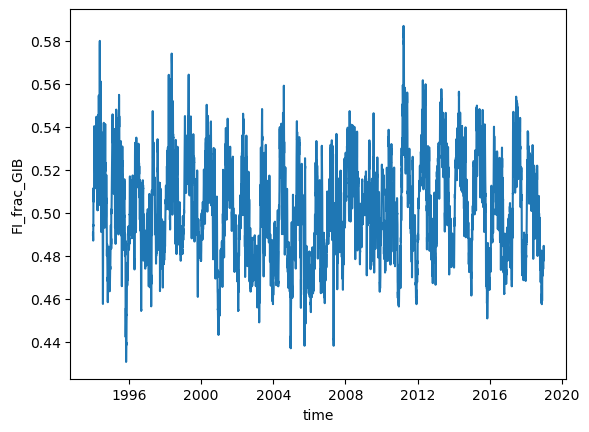

In [4]:
fi_frac = ds_frac["FI_frac_GIB"].compute()
fi_frac.plot()

In [ ]:
overall = (ds_frac.FI_GIB.sum("time") / ds_frac.FI_total.sum("time")).compute().item()
print(f"Percentage of FI that requires grounded icebergs: {int(overall*100)}")


0.49950432777404785

In [11]:
dt0 = "1994-01-01"
dtN = "1999-12-31"
P_log = Path(Path.home(), "logs", "paper1.log")
FI_with, tools_with = load_fi_mask("elps-min", dt0, dtN, P_log)
FI_nogi, tools_nogi = load_fi_mask("gi-nil",   dt0, dtN, P_log)
tools_with.load_bgrid()
area = tools_with.G_t["area"].rename({"nj":"y", "ni":"x"}).astype("float32")
# match any SH-subset you might have in FI
area = area.sel(y=FI_with["y"], x=FI_with["x"]).load()
# align (guards against any small time mismatches)
FI_with, FI_nogi = xr.align(FI_with, FI_nogi, join="inner")
FI_with = FI_with.fillna(0).astype("uint8")
FI_nogi = FI_nogi.fillna(0).astype("uint8")

FI_req = (FI_with == 1) & (FI_nogi == 0)
FI_total_area = (FI_with * area).sum(("y","x"))
FI_req_area   = (FI_req.astype("uint8") * area).sum(("y","x"))
FI_req_frac   = (FI_req_area / FI_total_area).where(FI_total_area > 0)

# Abstract-ready single number: area–time integrated %
pct_req = (FI_req_area.sum("time") / FI_total_area.sum("time")).compute().item() * 100
print(f"{int(pct_req)}% of simulated fast ice area requires grounded icebergs.")
tmax = FI_total_area.groupby("time.year").idxmax("time")
pct_req_at_max = (FI_req_area.sel(time=tmax) / FI_total_area.sel(time=tmax)).mean("year").compute().item() * 100
print(f"... and at annual maximum fast ice extent {int(pct_req_at_max)}%")

2025-12-18 11:34:14,036 - INFO - log file connected: /home/581/da1339/logs/paper1.log
2025-12-18 11:34:14,057 - INFO - Dask Client Connected
  Dashboard      : http://127.0.0.1:8787/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-12-18 11:34:14,058 - INFO - hemisphere initialised: SH
2025-12-18 11:34:14,060 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-12-18 11:34:14,062 - INFO -  self.ice_class defined as FI_['Tb']
2025-12-18 11:34:14,063 - INFO - --- SeaIceToolbox Summary ---
2025-12-18 11:34:14,065 - INFO - Simulation Name     : elps-min
2025-12-18 11:34:14,066 - INFO - Analysis Start Date : 1994-01-01
2025-12-18 11:34:14,067 - INFO - Analysis End Date   : 1999-12-31
2025-12-18 11:34:14,068 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-12-18 11:34:14,069 - INFO - B-regrid Type(s)    : ['Tb']
2025-12-18 11:34:14,070 - INFO 

62% of simulated fast ice area requires grounded icebergs.


AttributeError: 'DataArrayGroupBy' object has no attribute 'idxmax'

# Results

1. run the script:
```bash qsub ./scripts/all_stats.pbs```

## Figure 1

+ Sea ice area and volum comparisons are done against [NSIDC](https://nsidc.org/data/g02202/versions/4) and [ACCESS-OM2-025-IAF-ERA](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103) (``AOM2-ERA``). The rationale is to show two of my simulations ([AFIM](https://github.com/dpath2o/AFIM), *CICE6-standalone*) against both NSIDC and ACCESS-OM2 as a relative overall gauge of AFIM performance.

+ I've chosen two related AFIM simulations: ``elps-min`` and ``gi-nil``. Both of which have ellispse eccentrincities ($e_{f}=e_{g}=1.2$, and further just abbreviated $e$) and tensile stress parameter ($k_{t}=0.2$) and all other CICE namelist parameters set to *default* standalone configuration, with the exception of the landmask file used (``kmt_file``). ``elps-min`` uses a modified landmask where 25% of the non-isolated grounded iceberg cells remain, whereas ``gi-nil`` uses the same landmask file as ``AOM2-ERA5`` and hence has no grounded iceberg cells.
  
+ Animations of daily sea ice speed ($\sqrt{u^2 + v^2}$) are then shown of the above two AFIM simulations along with AOM2-ERA5 for the same period (Austral winter 1999). Implicitly, the animations show the effect of $e$ and $ktens$ on the coastal icepack, and for the ``elps-min`` simulation the animation clearly shows the significance of grouned icebergs. 

### SIA, SIT, (and SIV)

#### Helper functions

In [4]:
def compute_ORAS_sia_siv_sit(P_nc, A_da):
    ds = (xr.open_dataset(P_nc, 
                         engine="netcdf4", 
                         chunks={"time": 31, "latitude": 256, "longitude": 256},).isel(latitude=slice(0, 1020))[["siconc", "sithick"]].astype("float32"))
    # Make sure area is chunked compatibly
    area = A_da.isel(latitude=slice(0, 1020)).astype("float32").chunk({"latitude": 256, "longitude": 256})
    mask = ds["siconc"] > 0.15
    sic  = xr.where(mask, ds["siconc"], 0.0)
    hi   = xr.where(mask, ds["sithick"], 0.0)
    sia = (sic * area).sum(("latitude", "longitude")) / 1e12
    siv = (sic * hi * area).sum(("latitude", "longitude")) / 1e12
    sit = siv / sia
    return sia, siv, sit

def sia_siv_sit_for_year(sim_name: str, yr: int):
    dt0, dtN = f"{yr}-01-01", f"{yr}-12-31"
    SI_tools = SI_tool_mgr.get_toolbox(sim_name = sim_name, 
                                       dt0_str  = dt0,
                                       dtN_str  = dtN)
    so       = SI_tools.load_cice_zarr(slice_hem = True,
                                       variables = ["aice","hi","tarea"])
    sic      = so["aice"]  # [time, j, i] ...
    hi       = so["hi"]    # [time, j, i] ...
    A        = so["tarea"].isel(time=0).drop_vars("time", errors="ignore")  # [j, i]
    sia      = SI_tools.compute_hemisphere_ice_area(sic, A, ice_area_scale=SI_tools.SIC_scale)
    siv      = SI_tools.compute_hemisphere_ice_volume(sic, hi, A)
    sit      = SI_tools.compute_hemisphere_ice_thickness(sic, hi, A)
    sia      = sia.rename("SIA")
    siv      = siv.rename("SIV")
    sit      = sit.rename("SIT")
    return sia, siv, sit

#### Initialisation

In [5]:
sias, sivs, sits             = [], [], []
SIA_dict, SIV_dict, SIT_dict = {}, {}, {}
years       = range(1994, 2000)
sim_name    = "elps-min" #dummy name as a loop will redefine this ... 
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)

#### NSIDC

In [6]:
NSIDC_ts          = SI_tools.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = {'SIA' : NSIDC_ts['SIA'].sel(time=slice(dt0_str,dtN_str))}

NameError: name 'SI_tools' is not defined

#### ESA-CCI



In [ ]:
esa = xr.open_dataset(Path(os.path.expanduser("~/AFIM_gv90/SeaIce/ESA/CCI"),"SIT_ESA-CCI_envisat_v2p0_daily_climatology_2002-2012.nc"))["sit_climatology"]
esa = esa.rename({"clim_time": "time"}) 
esa = esa.rename("SIT")
SIT_dict["ESA-CCI"]["SIT"] = esa

#### ORAS

In [ ]:
G_CMEMS     = xr.open_dataset("/g/data/gv90/da1339/grids/GLORYS/CMEMS_0p083_grid.nc")
x_dist      = G_CMEMS['e1t'].load()
y_dist      = G_CMEMS['e2t'].load()
ORAS_A      = x_dist * y_dist
ORAS_A_SH   = ORAS_A.isel(latitude=slice(0,1020))
ORAS_A_da   = xr.DataArray(ORAS_A_SH.values, coords = ORAS_A_SH.coords, dims = ORAS_A_SH.dims)
for yr in years:
    P_ = f"/g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/{yr}0101_{yr}1231_CMEMS_0p083_org.nc"
    print("working on", P_)
    sia, siv, sit = compute_ORAS_sia_siv_sit(P_, ORAS_A_da)
    sias.append(sia.compute())
    sivs.append(siv.compute())
    sits.append(sit.compute())
# Concatenate along time 
SIA = xr.concat(sias, dim="time")
SIV = xr.concat(sivs, dim="time")
SIT = xr.concat(sits, dim="time")
# sort time in case any year has inclusive endpoints
SIA = SIA.sortby("time")
SIV = SIV.sortby("time")
SIT = SIT.sortby("time")
# write to disk
ts = xr.Dataset({"SIA": SIA, "SIV": SIV, "SIT": SIT})
ts.to_zarr("/g/data/gv90/da1339/SeaIce/CMEMS/CMEMS_SIA_SIV_SIT_1994-1999.zarr", mode="w", consolidated=True)
SIA_dict['ORAS'] = {'SIA' : SIA}
SIV_dict['ORAS'] = {'SIV' : SIV}
SIT_dict['ORAS'] = {'SIT' : SIT}

#### CICE-SA

In [ ]:
for sim_name in ["elps-min","notensnogi","ry93","AOM2-ERA5"]:
    sias, sivs = [], []
    for yr in range(1994, 2000):
        sia, siv, sit = sia_siv_sit_for_year(sim_name, yr)
        sias.append(sia)
        sivs.append(siv)
        sits.append(sit)
    SIA = xr.concat(sias, dim="time").sortby("time")
    SIV = xr.concat(sivs, dim="time").sortby("time")
    SIT = xr.concat(sits, dim="time").sortby("time")
    ds = xr.Dataset({ "SIA" : SIA, 
                      "SIV" : SIV,
                      "SIT" : SIT})
    SIA_dict[sim_name] = {"SIA": ds["SIA"]}
    SIV_dict[sim_name] = {"SIV": ds["SIV"]}
    SIT_dict[sim_name] = {"SIT": ds["SIT"]}

#### plot SIA

In [ ]:
SI_tools.pygmt_timeseries(SIA_dict, 
                          comp_name   = "SH",
                          primary_key = "SIA",
                          climatology = True,
                          yaxis_pri   = "a2f1g5+lSea Ice Area (@[1\\times10^6\\ \\mathrm{km}^2@[)",
                          ylim        = [0,20],
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6.5c")

#### plot SIV

In [ ]:
SI_tools.pygmt_timeseries(SIV_dict, 
                          comp_name   = "SH",
                          primary_key = "SIV",
                          climatology = True,
                          ylabel      = "Sea Ice Volume (@[1\\times10^6\\ \\mathrm{km}^3@[)",
                          ylim        = [0,21],
                          ytick_pri   = 2,
                          ytick_sec   = 1,
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6.5c")

#### plot SIT

In [ ]:
SI_tools.pygmt_timeseries(SIT_dict,
                          comp_name   = "SH",
                          primary_key = "SIT",
                          climatology = True,
                          yaxis_pri   = "a1f.5.g1+lSea Ice Thickness (m)",
                          ylim        = [0, 4],
                          show_fig    = True,
                          legend_pos  = "JTR+jTR+o0.2c+w6.5c",
                          clip_x_axis = True)

## Figure 2 : ice drift / speed

### helper functions

In [ ]:
def load_ispd_diffs(sim_name):
    D_search = Path(Path.home(), "seaice", "OSI_SAF", "ice_drift_455m")
    F_search = "ispd_diffs_pygmt_nn_{sim}_199*.nc".format(sim=sim_name)
    P_       = sorted(D_search.rglob(F_search))
    return xr.open_mfdataset(P_, combine="by_coords")

### load the data

In [ ]:
ISP_bias, ISP_rmse, ISP_ang, ISP_cos = {}, {}, {}, {}
ds                    = load_ispd_diffs("elps-min")
ISP_bias['elps-min']  = {'ispd_bias'  : ds['d_ispd_CICE'].mean(dim=['ny','nx']).compute()}
ISP_rmse['elps-min']  = {'ispd_rmse'  : ds['RMSE_CICE']}
ISP_ang['elps-min']   = {'ang_bias'   : ds['ANG_CICE_mean']}
ISP_cos['elps-min']   = {'cos_bias'   : ds['COS_CICE_mean']}
ISP_bias['AOM2-ERA5'] = {'ispd_bias'  : ds['d_ispd_AOM2'].mean(dim=['ny','nx']).compute()}
ISP_rmse['AOM2-ERA5'] = {'ispd_rmse'  : ds['RMSE_AOM2']}
ISP_ang['AOM2-ERA5']  = {'ang_bias'   : ds['ANG_AOM2_mean']}
ISP_cos['AOM2-ERA5']  = {'cos_bias'   : ds['COS_AOM2_mean']}
ISP_bias['ORAS']      = {'ispd_bias'  : ds['d_ispd_ORAS'].mean(dim=['ny','nx']).compute()}
ISP_rmse['ORAS']      = {'ispd_rmse'  : ds['RMSE_ORAS']}
ISP_ang['ORAS']       = {'ang_bias'   : ds['ANG_ORAS_mean']}
ISP_cos['ORAS']       = {'cos_bias'   : ds['COS_ORAS_mean']}
ds                     = load_ispd_diffs("notensnogi")
ISP_bias['notensnogi'] = {'ispd_bias'  : ds['d_ispd_CICE'].mean(dim=['ny','nx']).compute()}
ISP_rmse['notensnogi'] = {'ispd_rmse'  : ds['RMSE_CICE']}
ISP_ang['notensnogi']  = {'ang_bias'   : ds['ANG_CICE_mean']}
ISP_cos['notensnogi']  = {'cos_bias'   : ds['COS_CICE_mean']}

#### plot ispd_diffs

In [ ]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
sim_tools   = SI_tool_mgr.get_toolbox(sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
sim_tools.pygmt_timeseries(ISP_bias,
                           comp_name    = "ISP_ispd_bias",
                           primary_key  = "ispd_bias",
                           climatology  = True,
                           clim_smooth = 15,
                           yaxis_pri   = "a0.05f0.025g0.1+lSea Ice Speed Biases (m/s)",
                           ylim         = [-.1,.1],
                           legend_pos = "JBL+jBL+o0.2c+w6.5c",
                           show_fig   = True)

## Figures 3-6: Parameter Modifications (FIA + FIP)

2025-09-30 14:24:50,965 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox2.log
2025-09-30 14:24:50,972 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-09-30 14:24:50,973 - INFO - hemisphere initialised: SH
2025-09-30 14:24:50,975 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-30 14:24:50,996 - INFO -  self.ice_class defined as FI_BT
2025-09-30 14:24:50,998 - INFO - --- SeaIceToolbox Summary ---
2025-09-30 14:24:50,999 - INFO - Simulation Name     : elps-min
2025-09-30 14:24:51,000 - INFO - Analysis Start Date : 1994-01-01
2025-09-30 14:24:51,001 - INFO - Analysis End Date   : 1999-12-31
2025-09-30 14:24:51,002 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-09-30 14:24:51,004 - INFO - Speed Type(s)       : BT
2025-09-30 14:24:51,005 - INFO - Ice Typ

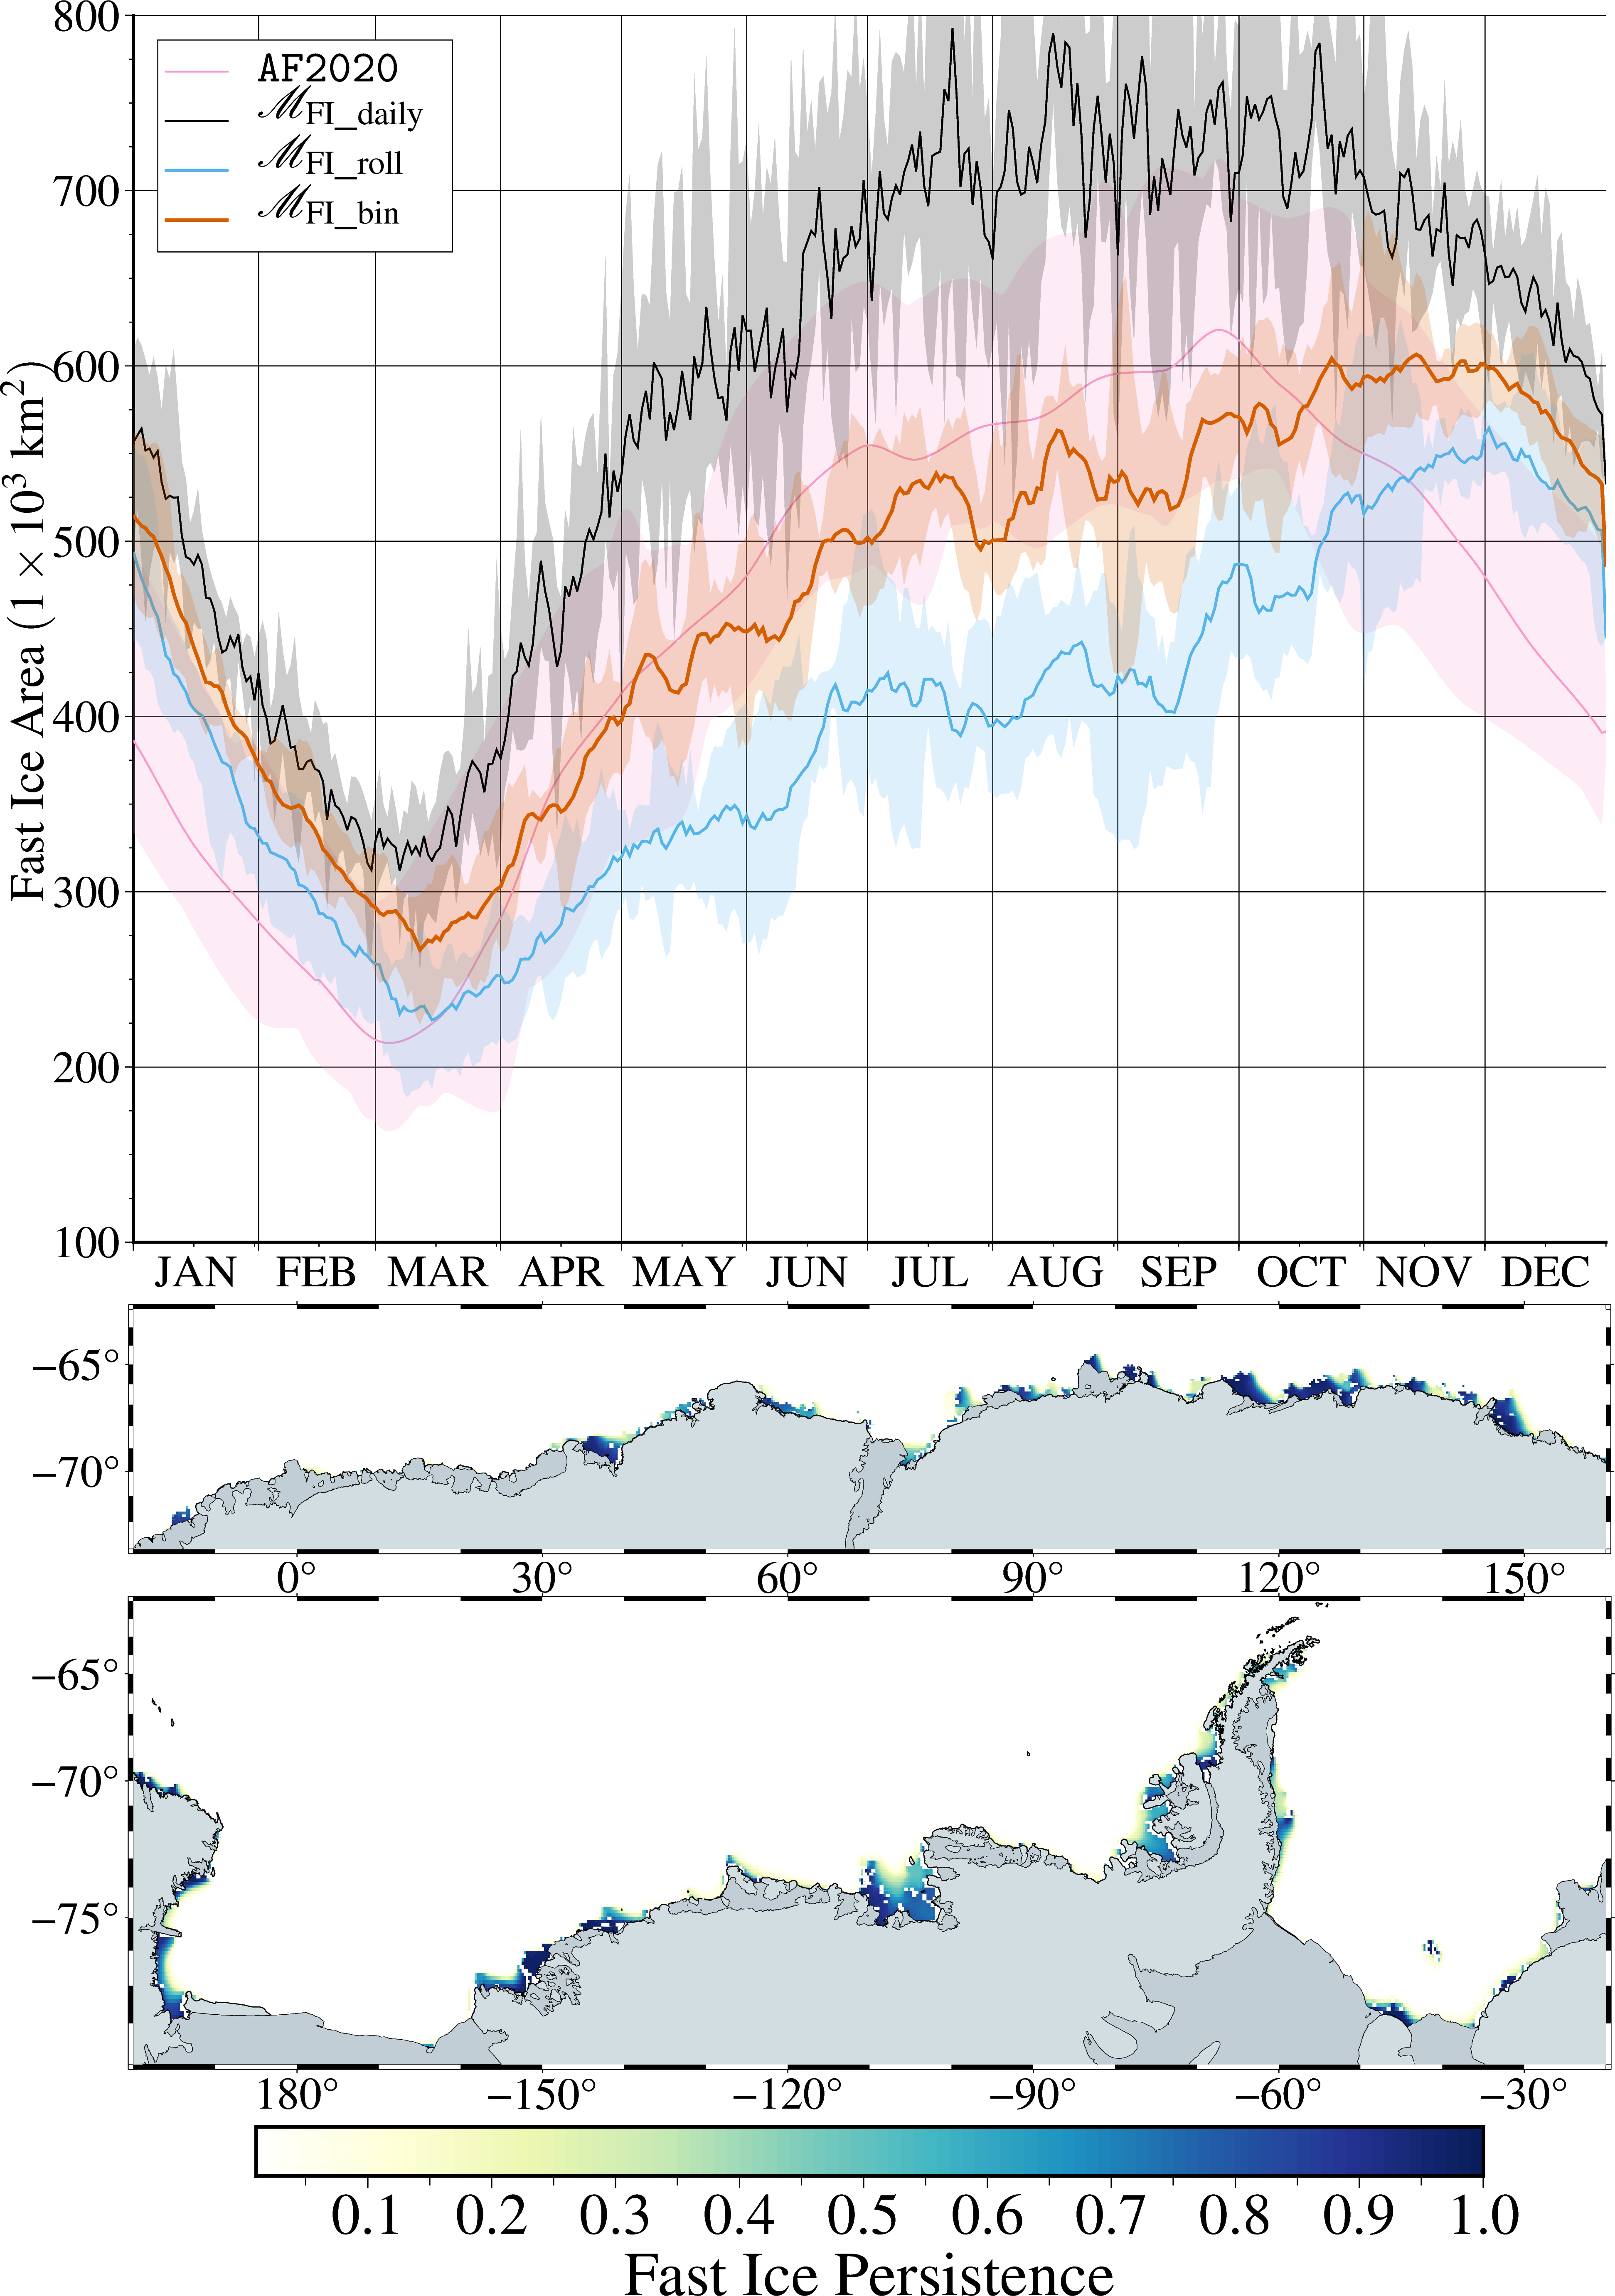

In [ ]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
for item in [sim_name]:#Path(SI_tools.D_dict["AFIM_out"]).iterdir():
    # if item.name in skip_names:
    #     continue
    sim_name = item#.name
    SI_tools = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                       dtN_str  = dtN_str,
                                       sim_name = sim_name)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIA",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 ylim              = [100,800],
                                 water_clr         = "#DCF8FA",
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = True)

### extra figures

In [ ]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1995-12-31"
P_log       = Path(Path.home(), "logs", "paper1.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
for item in ["notensnogi"]:#Path(SI_tools.D_dict["AFIM_out"]).iterdir():
    # if item.name in skip_names:
    #     continue
    sim_name = item#.name
    SI_tools = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                       dtN_str  = dtN_str,
                                       sim_name = sim_name)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIA",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = True)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIT",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIS",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMAR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMVR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITAR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITVR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)

## Figure 7 : Sensitivity Summary

In [3]:
ARCHIVE_ROOT = Path("~/AFIM_archive").expanduser()
THRESH_DIR   = "ispd_thresh_5.0e-4"
STORE_NAME   = "FI_Tb_bin.zarr"
YEARS        = list(range(1994, 2000))  # 1994–1999 inclusive
CONTROL_SIM  = "gi-mid"           # change if your default member differs
OUTDIR       = ARCHIVE_ROOT / "_paper1_sensitivity_summary"
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Output dir:", OUTDIR)

Output dir: /home/581/da1339/AFIM_archive/_paper1_sensitivity_summary


### Discover simulations + assign parameter groups

In [4]:
def infer_param_group(sim: str) -> str | None:
    # Paper-1 sweeps
    if sim.startswith("Cstar-"): return "Cstar"
    if sim.startswith("Pstar-"): return "Pstar"
    if sim.startswith("ktens-"): return "ktens"
    if sim.startswith("elps-"):  return "eratio"
    if sim.startswith("gi-mid-gi"): return "GI-placement"  # your GI perturb members
    if sim.startswith("gi-"):    return "githin"

    # Optional: include/exclude other experiments in your archive
    # if sim.startswith("ndte-"): return "ndte"
    # if sim in {"re-evp-off", "ndte-max-re-off"}: return "dynamics-switches"

    return None  # ignore everything else by default

def find_fi_stores():
    sims = []
    for sim_dir in sorted(ARCHIVE_ROOT.glob("*/zarr")):
        sim = sim_dir.parent.name
        zpath = sim_dir / THRESH_DIR / STORE_NAME
        if zpath.exists():
            group = infer_param_group(sim)
            if group is not None:
                sims.append((sim, group, zpath))
    return sims


SIMS = find_fi_stores()
df_sims = pd.DataFrame(SIMS, columns=["sim", "param_group", "zarr_path"]).sort_values(["param_group","sim"])
display(df_sims)

print("Found sims:", len(df_sims))


sim   param_group  \
0    Cstar-max         Cstar   
1    Cstar-min         Cstar   
10  gi-mid-gi1  GI-placement   
11  gi-mid-gi2  GI-placement   
12  gi-mid-gi3  GI-placement   
2    Pstar-max         Pstar   
3    Pstar-min         Pstar   
4     elps-ext        eratio   
5     elps-max        eratio   
6     elps-mid        eratio   
7     elps-min        eratio   
8       gi-max        githin   
9       gi-mid        githin   
13      gi-min        githin   
14      gi-nil        githin   
15  gi-nil-def        githin   
16   ktens-ext         ktens   
17   ktens-max         ktens   
18   ktens-min         ktens   
19   ktens-nil         ktens   

                                            zarr_path  
0   /home/581/da1339/AFIM_archive/Cstar-max/zarr/i...  
1   /home/581/da1339/AFIM_archive/Cstar-min/zarr/i...  
10  /home/581/da1339/AFIM_archive/gi-mid-gi1/zarr/...  
11  /home/581/da1339/AFIM_archive/gi-mid-gi2/zarr/...  
12  /home/581/da1339/AFIM_archive/gi-mid-gi3/zarr/...  
2   /home/581/da1339/AFIM_archive/Pstar-max/zarr/i...  
3   /home/581/da1339/AFIM_archive/Pstar-min/zarr/i...  
4   /home/581/da1339/AFIM_archive/elps-ext/zarr/is...  
5   /home/581/da1339/AFIM_archive/elps-max/zarr/is...  
6   /home/581/da1339/AFIM_archive/elps-mid/zarr/is...  
7   /home/581/da1339/AFIM_archive/elps-min/zarr/is...  
8   /home/581/da1339/AFIM_archive/gi-max/zarr/ispd...  
9   /home/581/da1339/AFIM_archive/gi-mid/zarr/ispd...  
13  /home/581/da1339/AFIM_archive/gi-min/zarr/ispd...  
14  /home/581/da1339/AFIM_archive/gi-nil/zarr/ispd...  
15  /home/581/da1339/AFIM_archive/gi-nil-def/zarr/...  
16  /home/581/da1339/AFIM_archive/ktens-ext/zarr/i...  
17  /home/581/da1339/AFIM_archive/ktens-max/zarr/i...  
18  /home/581/da1339/AFIM_archive/ktens-min/zarr/i...  
19  /home/581/da1339/AFIM_archive/ktens-nil/zarr/i...

Found sims: 20


### Sanity check one store/year

In [5]:
# Pick one example
example_sim = df_sims.iloc[0]["sim"]
example_path = df_sims.iloc[0]["zarr_path"]

def open_year(zarr_path: Path, year: int, chunks={"time": 31}):
    # Your store has subgroups per year: group="1994", "1995", etc.
    try:
        ds = xr.open_zarr(zarr_path, group=str(year), consolidated=True, chunks=chunks)
    except Exception:
        ds = xr.open_zarr(zarr_path, group=str(year), consolidated=False, chunks=chunks)
    return ds

ds94 = open_year(example_path, 1994)
ds94


/scratch/gv90/da1339/tmp/ipykernel_3540835/1635131991.py:10: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 31. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_zarr(zarr_path, group=str(year), consolidated=False, chunks=chunks)


<xarray.Dataset> Size: 309MB
Dimensions:  (nj: 540, ni: 1440, time: 365)
Coordinates:
    angle    (nj, ni) float64 6MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
  * time     (time) datetime64[ns] 3kB 1994-01-01 1994-01-02 ... 1994-12-31
    lon      (nj, ni) float64 6MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    lat      (nj, ni) float64 6MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    area     (nj, ni) float64 6MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Data variables:
    FI_mask  (time, nj, ni) uint8 284MB dask.array<chunksize=(31, 540, 1440), meta=np.ndarray>

### Functions: FIA fortnightly climatology and RMSD

In [6]:
def _standardise_dims(da: xr.DataArray) -> xr.DataArray:
    # Robust to common dim names
    ren = {}
    if "nj" in da.dims: ren["nj"] = "y"
    if "ni" in da.dims: ren["ni"] = "x"
    if "j"  in da.dims: ren["j"]  = "y"
    if "i"  in da.dims: ren["i"]  = "x"
    if ren:
        da = da.rename(ren)
    return da


def fortnightly_series_from_year_group(ds: xr.Dataset) -> xr.DataArray:
    """
    Convert ONE year's daily FIA series into 26-point fortnightly mean.
    - drops Feb 29
    - trims to first 364 days
    - coarsen into 14-day blocks (26 blocks)
    """
    FI = _standardise_dims(ds["FI_mask"]).astype("float32")
    A  = _standardise_dims(ds["area"]).astype("float32")

    # Ensure area is 2D (y,x)
    if "time" in A.dims:
        A = A.isel(time=0, drop=True)

    # FIA daily
    fia = (FI * A).sum(("y", "x"))

    # enforce daily step (protects against any missing/duplicate times)
    fia = fia.resample(time="1D").mean()

    # drop leap day (if present)
    fia = fia.sel(time=~((fia.time.dt.month == 2) & (fia.time.dt.day == 29)))

    # trim to 364 days => exactly 26 fortnights
    fia = fia.isel(time=slice(0, 364))

    fia14 = fia.coarsen(time=14, boundary="trim").mean()

    # replace time with 0..25 so we can average across years cleanly
    fia14 = fia14.assign_coords(fortnight=("time", np.arange(fia14.sizes["time"], dtype=int)))
    fia14 = fia14.swap_dims({"time": "fortnight"}).drop_vars("time")

    return fia14


def climatology_1994_1999(zarr_path: Path, years=YEARS) -> xr.DataArray:
    out = []
    for y in years:
        ds = open_year(zarr_path, y)
        out.append(fortnightly_series_from_year_group(ds))
    clim = xr.concat(out, dim="year").mean("year")
    return clim  # dims: fortnight


def rmsd(a: xr.DataArray, b: xr.DataArray, dim="fortnight") -> float:
    return float(np.sqrt(((a - b) ** 2).mean(dim)))


### Compute fortnightly climatologies for all sims

In [7]:
# Control climatology
ctl_row = df_sims[df_sims["sim"] == CONTROL_SIM]
if ctl_row.empty:
    raise ValueError(f"CONTROL_SIM='{CONTROL_SIM}' not found. Available: {sorted(df_sims['sim'].unique())}")

CTL_PATH = ctl_row.iloc[0]["zarr_path"]
fia_ctl = climatology_1994_1999(CTL_PATH)

# Compute all
clims = []
for sim, group, zpath in df_sims[["sim","param_group","zarr_path"]].itertuples(index=False):
    fia = climatology_1994_1999(zpath)
    fia = fia.assign_coords(sim=sim, param_group=group).expand_dims("sim")
    clims.append(fia)

FIA_CLIM = xr.concat(clims, dim="sim")  # dims: sim, fortnight
FIA_CLIM.name = "FIA_fortnightly_clim"

# Save a lightweight cache (optional but recommended)
cache_path = OUTDIR / "FIA_fortnightly_climatologies_1994_1999.nc"
FIA_CLIM.to_netcdf(cache_path)
print("Wrote:", cache_path)

FIA_CLIM


/scratch/gv90/da1339/tmp/ipykernel_3540835/1635131991.py:10: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 31. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_zarr(zarr_path, group=str(year), consolidated=False, chunks=chunks)
/scratch/gv90/da1339/tmp/ipykernel_3540835/1635131991.py:10: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 31. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_zarr(zarr_path, group=str(year), consolidated=False, chunks=chunks)
/scratch/gv90/da1339/tmp/ipykernel_3540835/1635131991.py:10: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 31. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_zarr(zarr_path, group=str(year), consolidated=False, chunks=chunks)
/scratch/gv90/da1339/t

Wrote: /home/581/da1339/AFIM_archive/_paper1_sensitivity_summary/FIA_fortnightly_climatologies_1994_1999.nc


<xarray.DataArray 'FIA_fortnightly_clim' (sim: 20, fortnight: 26)> Size: 2kB
dask.array<concatenate, shape=(20, 26), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * fortnight    (fortnight) int64 208B 0 1 2 3 4 5 6 7 ... 19 20 21 22 23 24 25
  * sim          (sim) <U10 800B 'Cstar-max' 'Cstar-min' ... 'ktens-nil'
    param_group  (sim) <U12 960B 'Cstar' 'Cstar' ... 'ktens' 'ktens'

### Compute RMSD vs control and summarise by parameter group

In [8]:
records = []
ctl_mean = float(fia_ctl.mean("fortnight"))

for sim in FIA_CLIM["sim"].values:
    group = str(FIA_CLIM.sel(sim=sim)["param_group"].values)
    fia = FIA_CLIM.sel(sim=sim)

    r = rmsd(fia, fia_ctl)
    records.append({
        "sim": sim,
        "param_group": group,
        "rmsd": r,
        "rmsd_rel": r / ctl_mean,  # fraction of control mean
    })

df_rmsd = pd.DataFrame(records).sort_values(["param_group","rmsd"])
display(df_rmsd)

# Group summary (this is what Will asked for)
df_group = (df_rmsd.groupby("param_group")
            .agg(mean_rmsd=("rmsd","mean"),
                 min_rmsd=("rmsd","min"),
                 max_rmsd=("rmsd","max"),
                 n=("rmsd","count"))
            .sort_values("mean_rmsd"))

display(df_group)


sim   param_group          rmsd  rmsd_rel
0    Cstar-max         Cstar  3.590690e+10  0.146336
1    Cstar-min         Cstar  6.265250e+10  0.255335
4   gi-mid-gi3  GI-placement  2.765470e+10  0.112704
2   gi-mid-gi1  GI-placement  2.897906e+10  0.118102
3   gi-mid-gi2  GI-placement  2.997642e+10  0.122166
5    Pstar-max         Pstar  5.031030e+10  0.205035
6    Pstar-min         Pstar  9.653762e+10  0.393431
8     elps-max        eratio  5.847143e+10  0.238295
9     elps-mid        eratio  7.476286e+10  0.304690
10    elps-min        eratio  1.688070e+11  0.687959
7     elps-ext        eratio  2.220881e+11  0.905101
12      gi-mid        githin  0.000000e+00  0.000000
14      gi-nil        githin  4.320632e+10  0.176084
11      gi-max        githin  5.300526e+10  0.216018
13      gi-min        githin  6.162058e+10  0.251129
15  gi-nil-def        githin  1.687239e+11  0.687620
18   ktens-min         ktens  6.746516e+10  0.274949
17   ktens-max         ktens  7.900755e+10  0.321989
19   ktens-nil         ktens  1.413758e+11  0.576165
16   ktens-ext         ktens  2.235724e+11  0.911150

mean_rmsd      min_rmsd      max_rmsd  n
param_group                                              
GI-placement  2.887006e+10  2.765470e+10  2.997642e+10  3
Cstar         4.927970e+10  3.590690e+10  6.265250e+10  2
githin        6.531122e+10  0.000000e+00  1.687239e+11  5
Pstar         7.342396e+10  5.031030e+10  9.653762e+10  2
ktens         1.278552e+11  6.746516e+10  2.235724e+11  4
eratio        1.310323e+11  5.847143e+10  2.220881e+11  4

### Plot: “Sensitivity by parameter” (bar + whiskers)

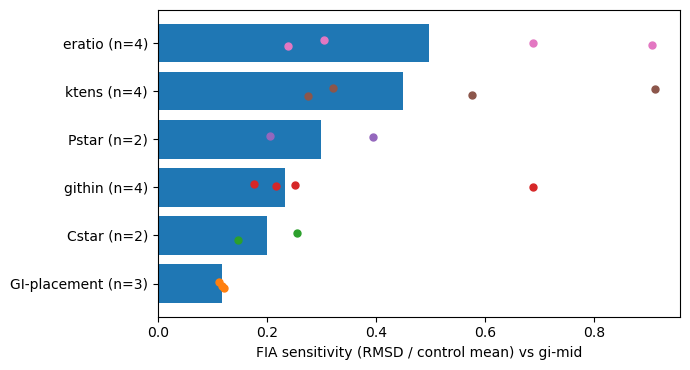

In [11]:
df_plot = df_rmsd.copy()
df_plot = df_plot[df_plot["sim"] != CONTROL_SIM]  # exclude control from group stats
metric = "rmsd_rel"

# order groups by median sensitivity
order = (df_plot.groupby("param_group")[metric]
         .median()
         .sort_values()
         .index.tolist())

fig, ax = plt.subplots(figsize=(7, 3.8))

# bars = group median
med = df_plot.groupby("param_group")[metric].median().reindex(order)
y = np.arange(len(order))
ax.barh(y, med.values)

# overlay dots = individual members (with small vertical jitter)
rng = np.random.default_rng(0)
for i, g in enumerate(order):
    vals = df_plot.loc[df_plot.param_group == g, metric].values
    jitter = (rng.random(len(vals)) - 0.5) * 0.18
    ax.scatter(vals, np.full_like(vals, i, dtype=float) + jitter, s=25)

n = df_plot.groupby("param_group")[metric].count().reindex(order)
ax.set_yticks(y)
ax.set_yticklabels([f"{g} (n={int(nn)})" for g, nn in zip(order, n.values)])
ax.set_xlabel(f"FIA sensitivity (RMSD / control mean) vs {CONTROL_SIM}")
fig.tight_layout()
plt.show()



### unitless version

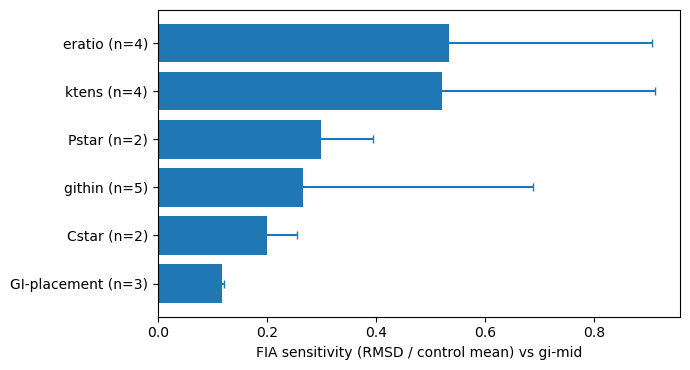

Wrote: /home/581/da1339/AFIM_archive/_paper1_sensitivity_summary/paper1_sensitivity_summary_FIA_rel.png


In [ ]:
df_group_rel = (df_rmsd.groupby("param_group")
                .agg(mean=("rmsd_rel","mean"),
                     min=("rmsd_rel","min"),
                     max=("rmsd_rel","max"),
                     n=("rmsd_rel","count"))
                .sort_values("mean"))

df_plot = df_rmsd.copy()
df_plot = df_plot[df_plot["sim"] != CONTROL_SIM]  # exclude control from group stats



## Figures 8-13: Sensitivity Time Series

In [ ]:
sim_name    = "__dummy__"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
sim_names   = ["Cstar-max","gi-mid","Cstar-min"]
comp_name   = "Cstar-comparison"
# "FI-heavy"         : ["elps-min","FI-heavy"]
# "GI-perturbation"  : ["gi-mid","gi-mid-gi1","gi-mid-gi2","gi-mid-gi3"]
# "GI-comparison"    : ["gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi"]
# "Cstar-comparison" : "@[\\texttt{gi-mid}\\ \\mathrm{C}^{\\ast}=20@["
# "Pstar-comparison" : "@[\\texttt{gi-mid}\\ \\mathrm{P}^{\\ast}=2.75\\times10^4@["
# "ktens-comparison" : "@[\\texttt{gi-mid}\\ k_{T}=0.2@[", ["ktens-ext","ktens-max","gi-mid","ktens-min","ktens-nil"]
# "ktens-comparison" : "@[\\texttt{gi-mid}\\ \\mathrm{e}=2.0@[", ["elps-max","gi-mid","elps-mid","elps-min","elps-ext"]
FIA_dict    = {}
FIT_dict    = {}
#FITVR_dict  = {}
#FITAR_dict  = {}
#FIMAR_dict  = {}
for sim_name in sim_names:
    SI_tools = SI_tool_mgr.get_toolbox(sim_name = sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
    FIA_dict['AF2020']  = {'FIA' : SI_tools.load_AF2020_FIA_summary()['FIA_obs']}
    P_zarr = Path(SI_tools.D_ispd_thresh, "FI_BT_bin_mets.zarr")
    SI_tools.logger.info(f"opening zarr met file: {P_zarr}")
    ds                   = xr.open_zarr(P_zarr, consolidated=False)
    FIA_dict[sim_name]   = {'FIA'   : ds['FIA']}
    FIT_dict[sim_name]   = {'FIT'   : ds['FIT']}
    #FITVR_dict[sim_name] = {'FITVR' : ds['FITVR']}
    #FITAR_dict[sim_name] = {'FITAR' : ds['FITAR']}
    #FIMAR_dict[sim_name] = {'FIMAR' : ds['FIMAR']}

2025-10-02 09:20:05,780 - INFO - Cstar-max simulation will be included in extract_min_max_dates()
2025-10-02 09:20:05,785 - INFO - gi-mid simulation will be included in extract_min_max_dates()
2025-10-02 09:20:05,787 - INFO - Cstar-min simulation will be included in extract_min_max_dates()
2025-10-02 09:20:06,109 - INFO - pulling out data array for AF2020 and putting into dataframe
2025-10-02 09:20:06,111 - INFO - legend label: @[\texttt{AF2020}@[
2025-10-02 09:20:06,112 - INFO - line color  : black
2025-10-02 09:20:06,186 - INFO - pulling out data array for Cstar-max and putting into dataframe
2025-10-02 09:20:06,187 - INFO - legend label: @[\texttt{cstar-max}\ \mathrm{C}^{\ast}=30@[
2025-10-02 09:20:06,189 - INFO - line color  : #D55E00
2025-10-02 09:20:06,329 - INFO - pulling out data array for gi-mid and putting into dataframe
2025-10-02 09:20:06,330 - INFO - legend label: @[\texttt{gi-mid}\ \mathrm{C}^{\ast}=20@[
2025-10-02 09:20:06,331 - INFO - line color  : #56B4E9
2025-10-02 09

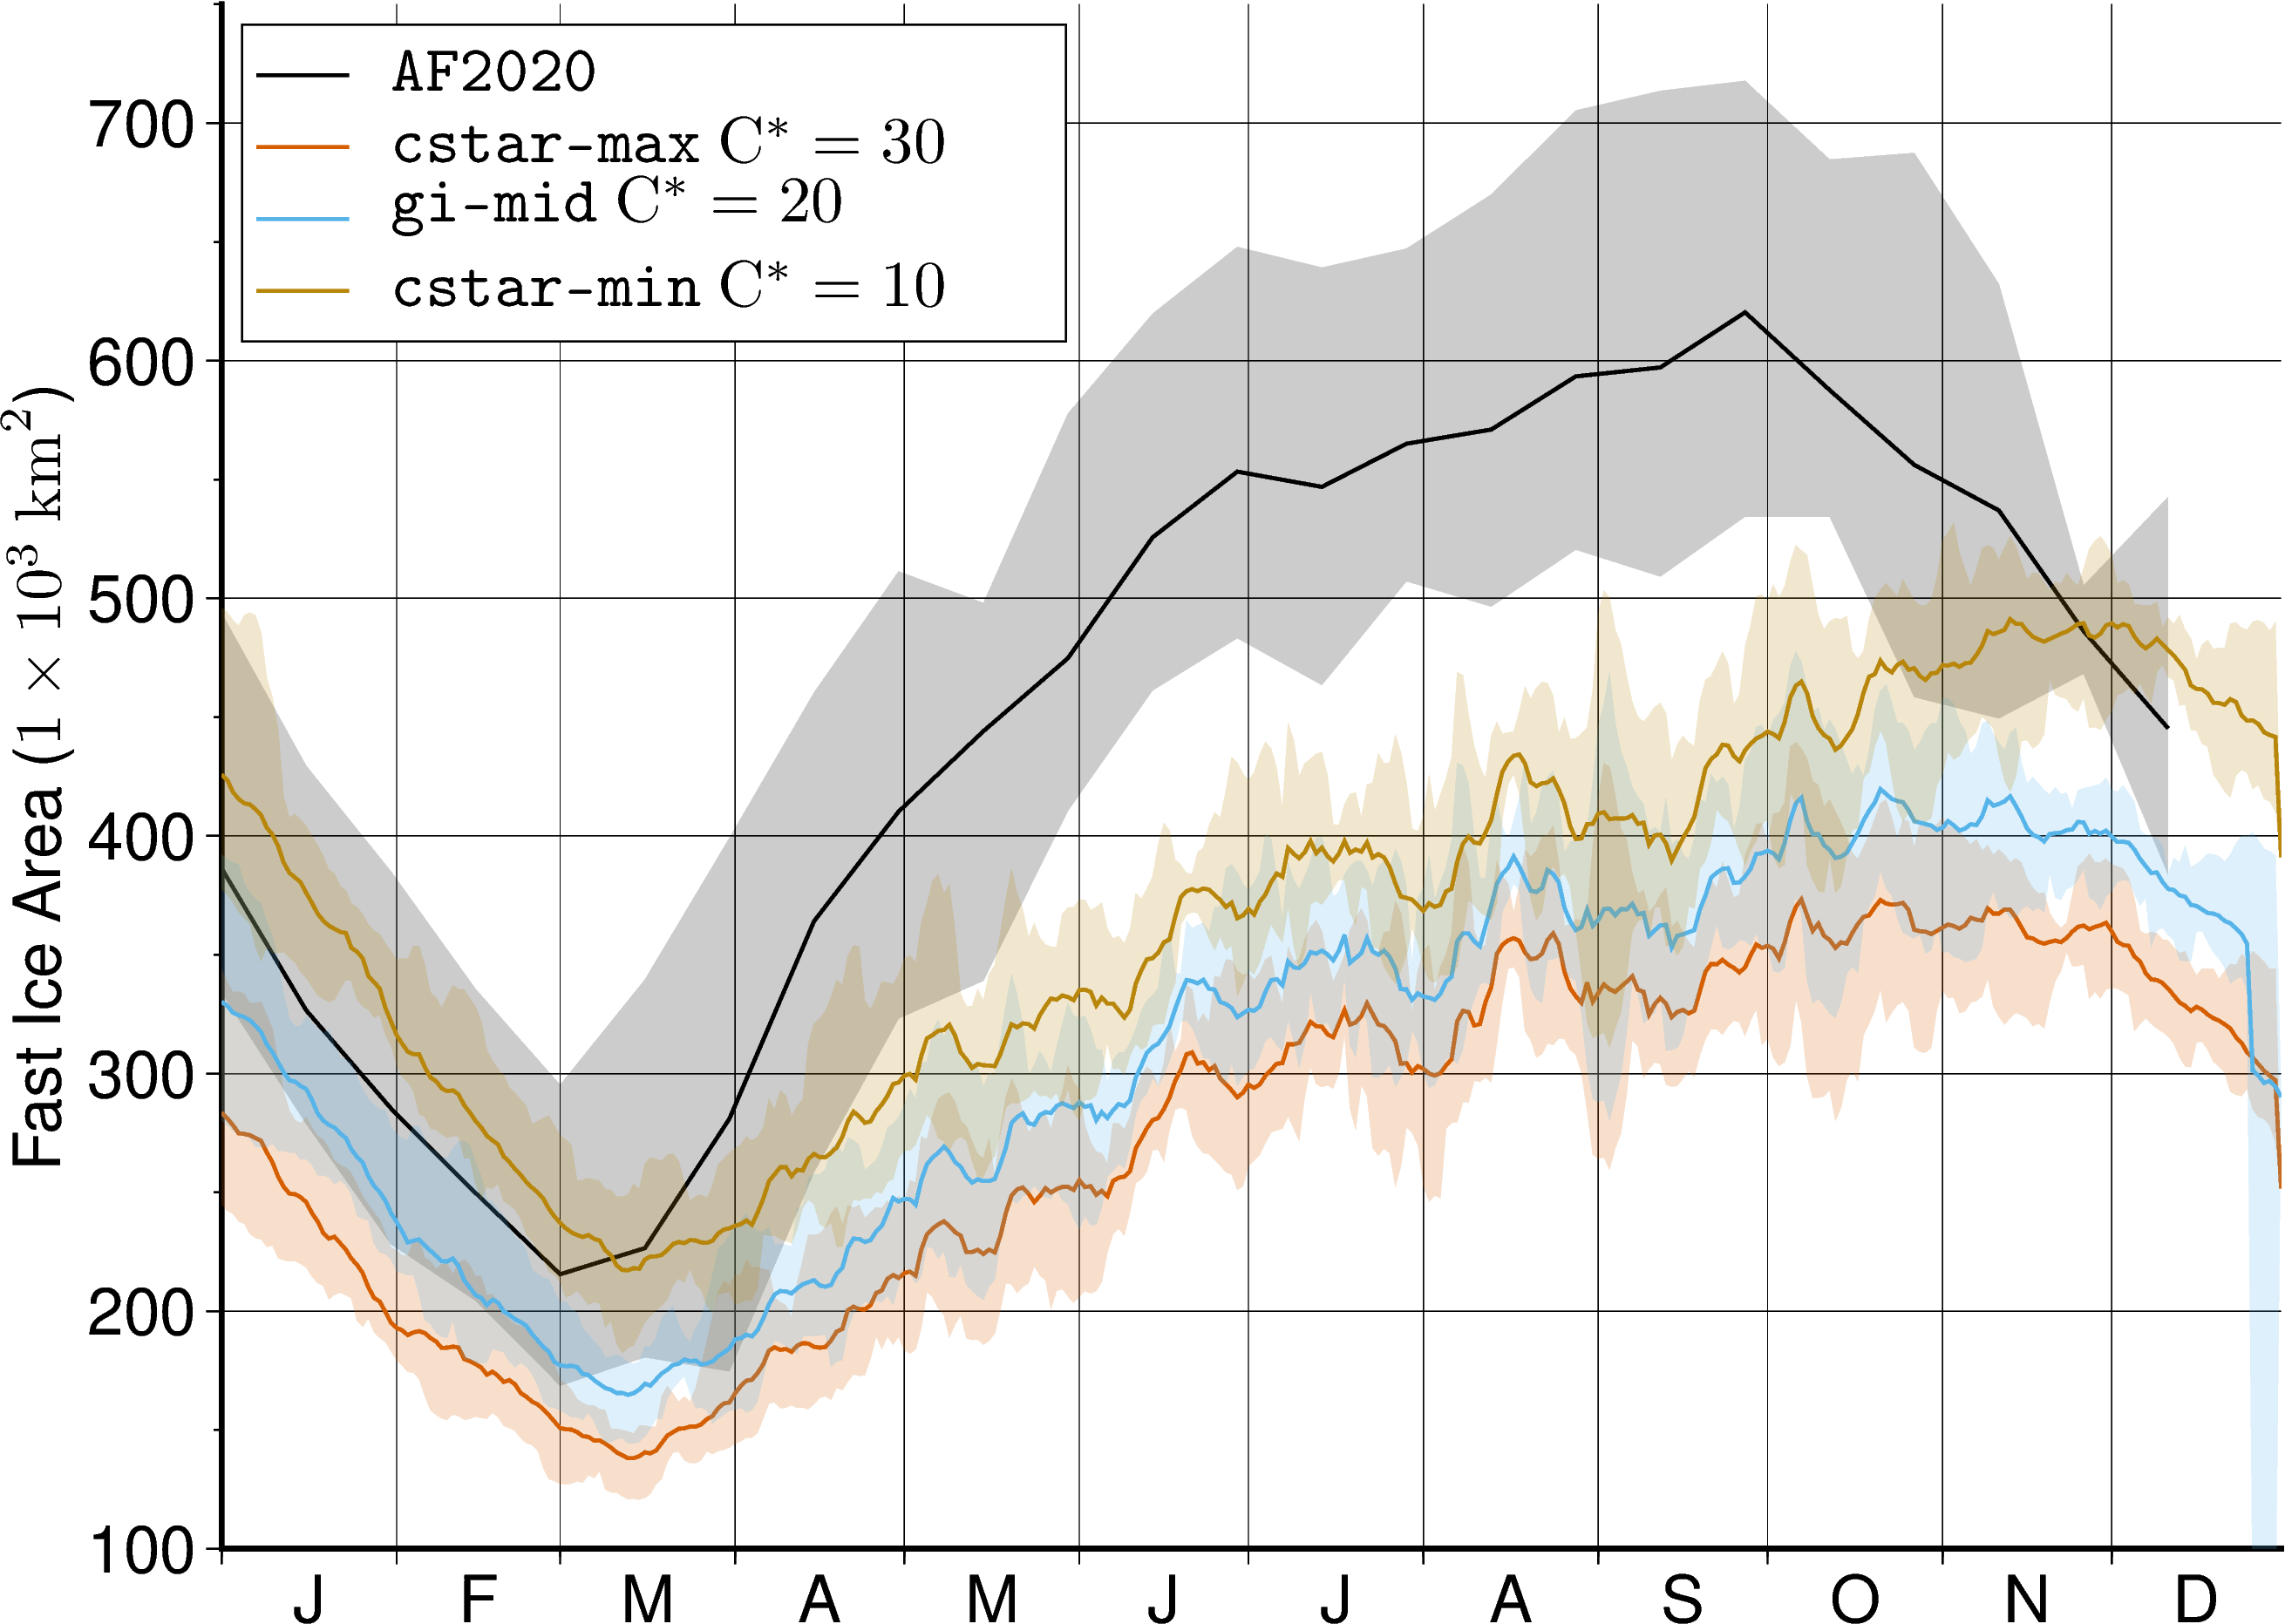

2025-10-02 09:20:09,103 - INFO - Cstar-max simulation will be included in extract_min_max_dates()
2025-10-02 09:20:09,106 - INFO - gi-mid simulation will be included in extract_min_max_dates()
2025-10-02 09:20:09,107 - INFO - Cstar-min simulation will be included in extract_min_max_dates()
2025-10-02 09:20:09,382 - INFO - pulling out data array for Cstar-max and putting into dataframe
2025-10-02 09:20:09,384 - INFO - legend label: @[\texttt{cstar-max}\ \mathrm{C}^{\ast}=30@[
2025-10-02 09:20:09,385 - INFO - line color  : #D55E00
2025-10-02 09:20:09,544 - INFO - pulling out data array for gi-mid and putting into dataframe
2025-10-02 09:20:09,545 - INFO - legend label: @[\texttt{gi-mid}\ \mathrm{C}^{\ast}=20@[
2025-10-02 09:20:09,547 - INFO - line color  : #56B4E9
2025-10-02 09:20:09,667 - INFO - pulling out data array for Cstar-min and putting into dataframe
2025-10-02 09:20:09,668 - INFO - legend label: @[\texttt{cstar-min}\ \mathrm{C}^{\ast}=10@[
2025-10-02 09:20:09,669 - INFO - line 

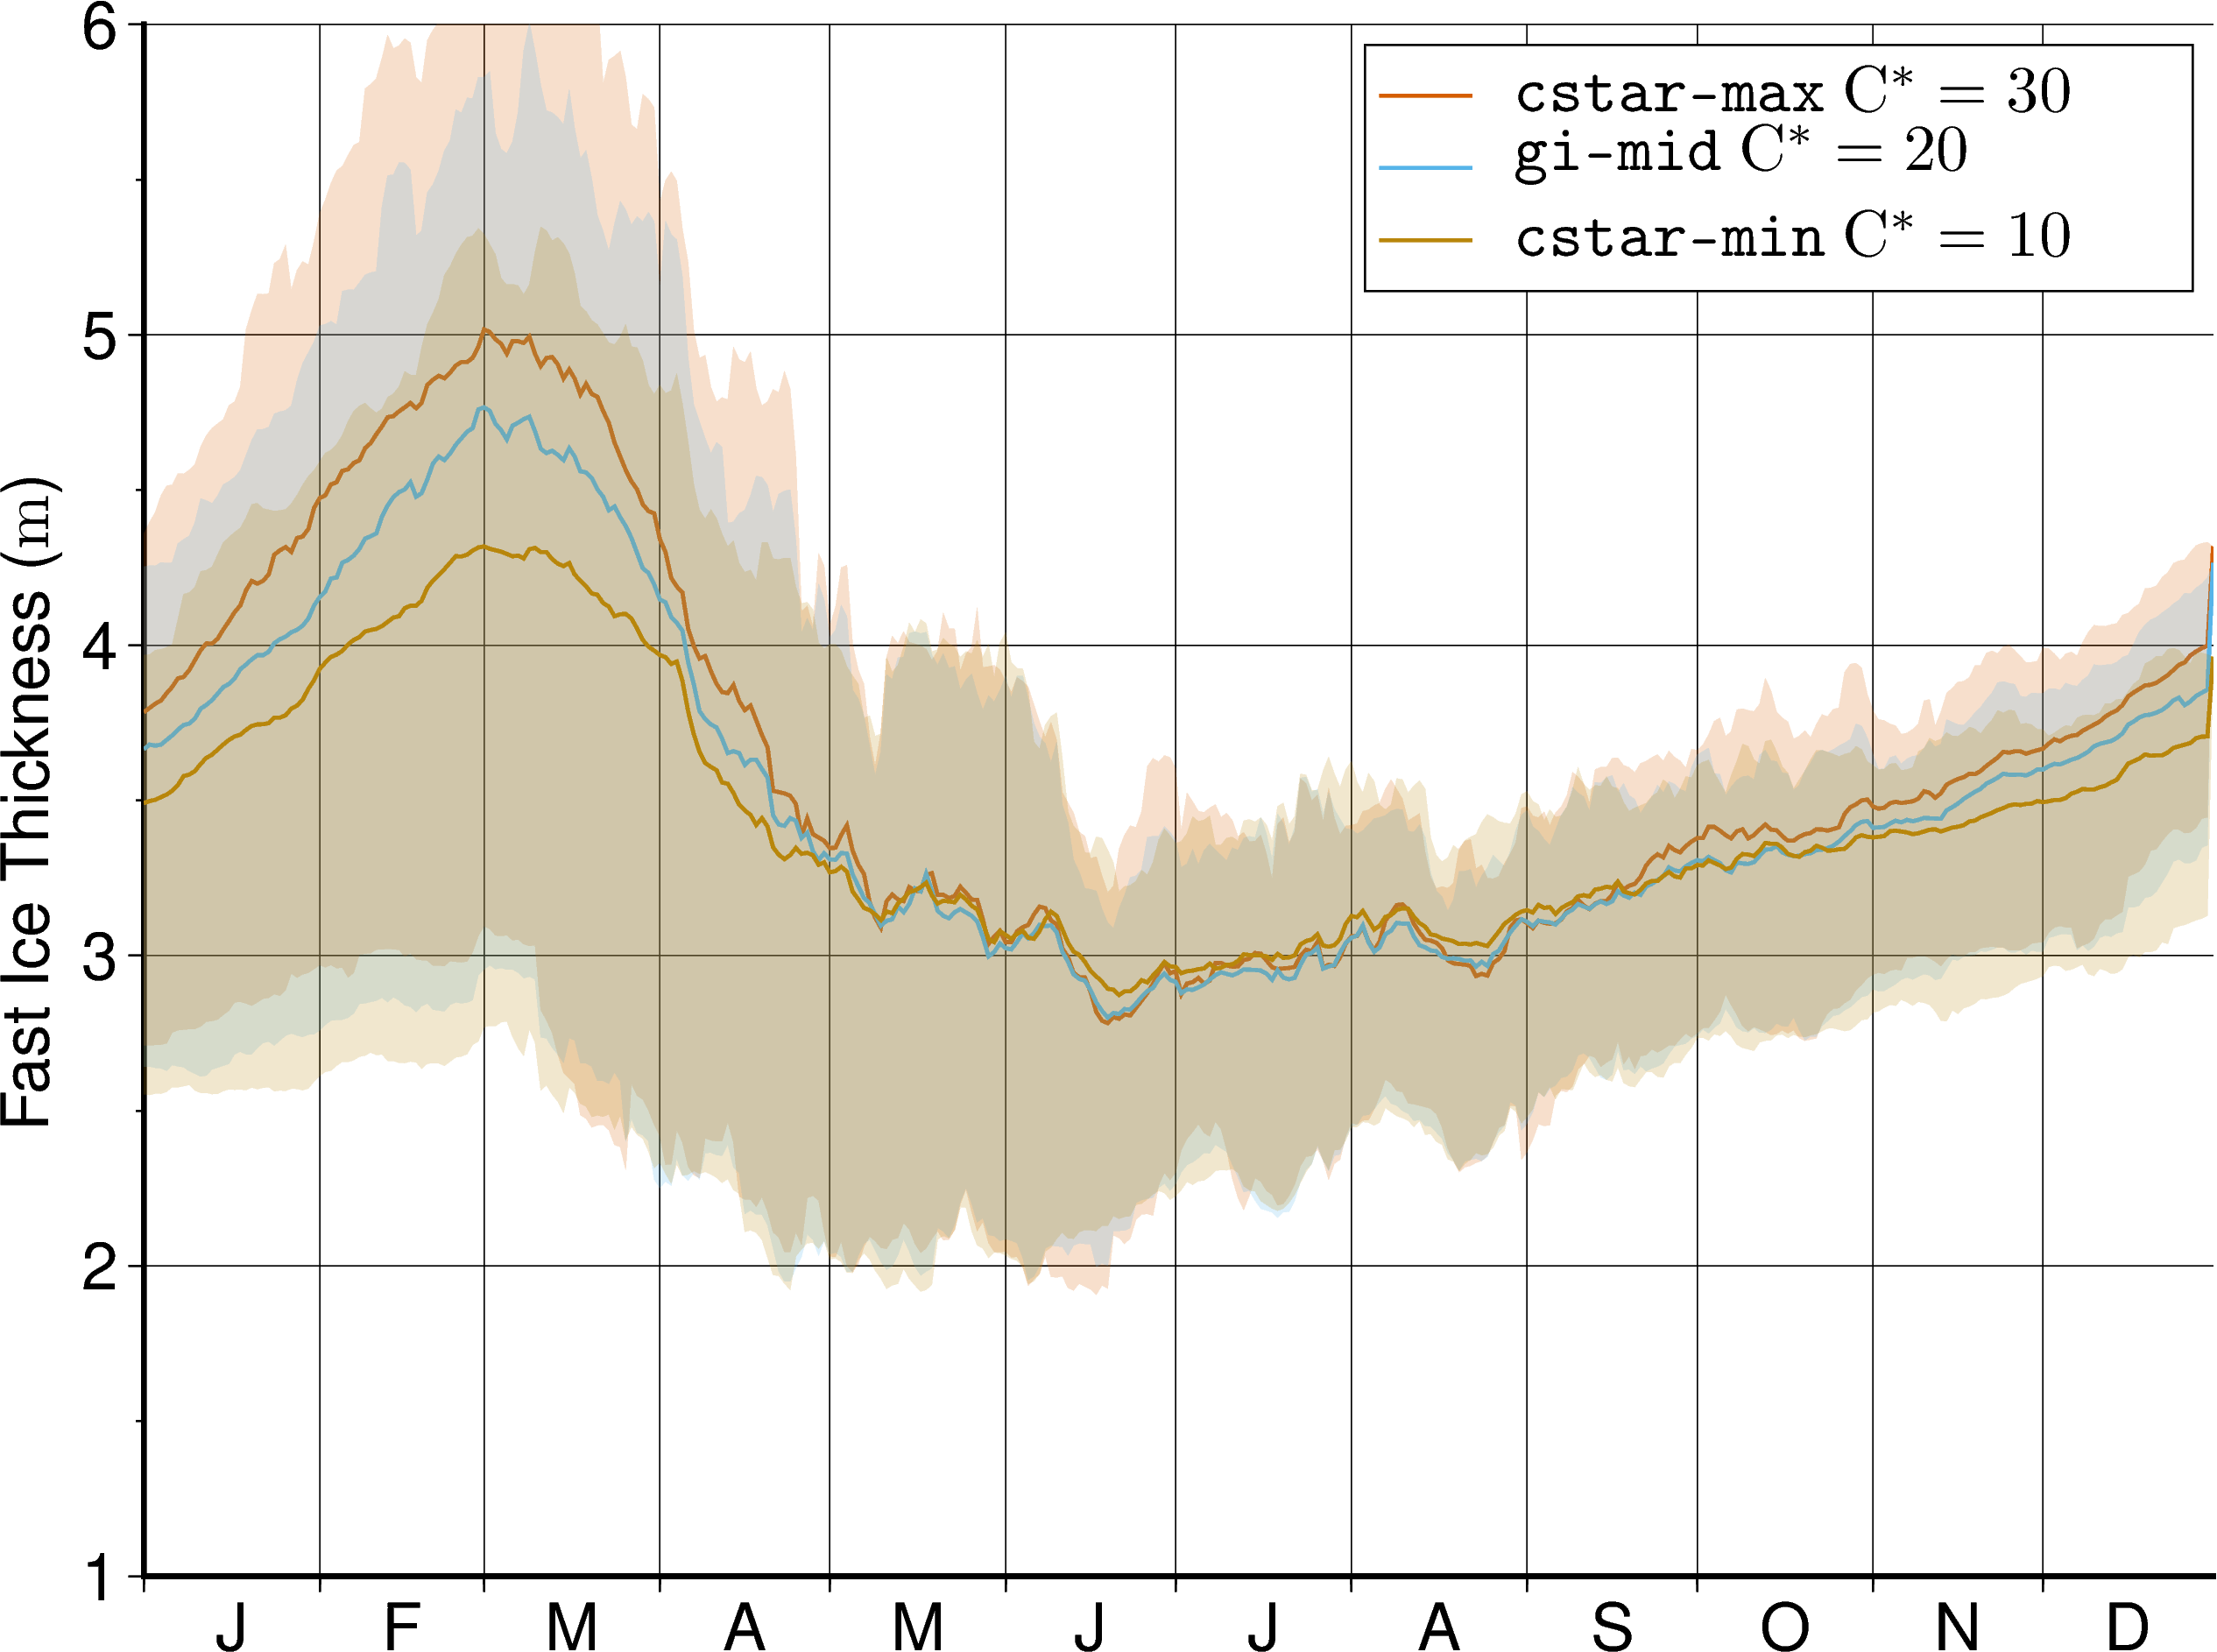

In [ ]:
SI_tools.pygmt_timeseries(FIA_dict,
                          comp_name   = comp_name,
                          primary_key = "FIA",
                          climatology = True,
                          ylabel      = "Fast Ice Area (@[1\\times10^3\\ \\mathrm{km}^2@[)",
                          ylim        = [100,750],
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIT_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIT",
                          climatology = True,
                          ylabel      = "Fast Ice Thickness (@[\\mathrm{m}@[)",
                          ylim        = [1,6],
                          ytick_pri   = 1,
                          ytick_sec   = 0.5,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")

### more fields (beyond FIA & FIT)

In [ ]:
SI_tools.pygmt_timeseries(FITVR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FITVR",
                          climatology = True,
                          clim_smooth = 15, 
                          ylabel      = "Fast Ice Thermodynamic Volume Rate (@[\\mathrm{m}/\\mathrm{s}@[)",
                          ylim        = [-4,4],
                          ytick_pri   = 1,
                          ytick_sec   = 0.5,
                          show_fig    = True, 
                          legend_pos  = "JBC+jBC+o0.2c+w7c")
SI_tools.pygmt_timeseries(FITAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FITAR",
                          climatology = True,
                          clim_smooth = 15,
                          ylabel      = "Fast Ice Thermodynamic Area Rate (@[\\mathrm{m}/\\mathrm{s}@[)",
                          ylim        = [-1,1],
                          ytick_pri   = 1,
                          ytick_sec   = 0.5,
                          show_fig    = True, 
                          legend_pos  = "JBC+jBC+o0.2c+w7c")
SI_tools.pygmt_timeseries(FIMAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIMAR",
                          climatology = True,
                          ylabel      = "Fast Ice Mechanical Area Rate (@[\\mathrm{m}/\\mathrm{s}@[)",
                          ylim        = [-1,1],
                          ytick_pri   = 1,
                          ytick_sec   = 0.5,
                          show_fig    = True, 
                          legend_pos  = "JTC+jTC+o0.2c+w13c")

### extra figures

In [ ]:
#AF2020 = xr.open_zarr(SI_tools.AF_FI_dict['P_AF2020_reG_zarr'], consolidated=False)
D_obs   = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs  = sorted(D_obs.glob("FastIce_70_*.nc"))
FI_obs  = xr.open_mfdataset(P_orgs, engine='netcdf4', combine='by_coords')
lat_c   = FI_obs['latitude'].isel(time=0)
lon_c   = FI_obs['longitude'].isel(time=0)
FI_mask = xr.where(FI_obs['Fast_Ice_Time_series'] >= 4, 1.0, 0.0)

In [ ]:
def print_scalar_vars(ds, label=""):
    """Print scalar variables and their values from an xarray.Dataset."""
    print(f"\nScalar variables in dataset {label}:\n" + "-"*40)
    for var in ds.data_vars:
        if ds[var].dims == ():
            val = ds[var].values.item()  # extract scalar value
            print(f"{var:30s}: {val:.4f}")
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "FIA_and_FIP_figs.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name)
AF2020      = xr.open_dataset(SI_tools.AF_FI_dict['P_AF2020_FIA'])["AF2020"]
comp_name   = "Cstar-comparison"
comp_sims   = ["Cstar-min","Cstar-max","elps-min","gi-mid"]
sim_names   = ["Cstar-min","Cstar-max","Pstar-min","Pstar-max","elps-max","elps-mid","elps-min","elps-ext",
               "gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi","ktens-nil","ktens-min","ktens-max","ktens-ext"]
FIA_dict    = {'AF2020'     : {'FIA' : AF2020}}
FIT_dict    = {}
FIS_dict    = {}
FIMAR_dict  = {}
FIMVR_dict  = {}
FITAR_dict  = {}
FITVR_dict  = {}
for sim_name in comp_sims:
    FI_bn_mets = xr.open_zarr(Path('/','g','data','gv90','da1339','afim_output',sim_name,'zarr','ispd_thresh_5.0e-4',"FI_BT_bin_mets.zarr"))
    FIA_dict[sim_name]   = {'FIA'   : FI_bn_mets['FIA']}
    FIT_dict[sim_name]   = {'FIT'   : FI_bn_mets['FIT']}
    FIS_dict[sim_name]   = {'FIS'   : FI_bn_mets['FIS']}
    FIMAR_dict[sim_name] = {'FIMAR' : FI_bn_mets['FIMAR']}
    FIMVR_dict[sim_name] = {'FIMVR' : FI_bn_mets['FIMVR']}
    FITAR_dict[sim_name] = {'FITAR' : FI_bn_mets['FITAR']}
    FITVR_dict[sim_name] = {'FITVR' : FI_bn_mets['FITVR']}

In [ ]:
SI_tools.pygmt_timeseries(FIA_dict, 
                          comp_name   = f"{sim_name}-class",
                          primary_key = "FIA",
                          climatology = True,
                          ylabel      = "Fast Ice Area (@[1\\times10^3\\ \\mathrm{km}^2@[)",
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIT_dict, 
                          comp_name   = f"{sim_name}-class",
                          primary_key = "FIT",
                          climatology = True,
                          ylabel      = "Fast Ice Thickness (m)",
                          ylim        = [1,7],
                          ytick_pri   = 1,
                          ytick_sec   = .5,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIS_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIS",
                          climatology = True,
                          ylabel      = "Fast Ice Strength (mPa)",
                          ylim        = [0,1500],
                          ytick_pri   = 100,
                          ytick_sec   = 50,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIMAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIMAR",
                          climatology = True,
                          ylabel      = "Fast Ice Mechanical Area Rate (m/s)",
                          ylim        = [-1.5,0.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIMVR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIMVR",
                          climatology = True,
                          ylabel      = "Fast Ice Mechanical Volume Rate (m/s)",
                          ylim        = [-1.5,0.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FITAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FITAR",
                          climatology = True,
                          ylabel      = "Fast Ice Thermodynamic Area Rate (m/s)",
                          ylim        = [-0.5,1.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FITVR_dict, 
                          comp_name   = comp_name,
                          
                          primary_key = "FITVR",
                          climatology = True,
                          ylabel      = "Fast Ice Thermodynamic Volume Rate (m/s)",
                          ylim        = [-3.5,3.5],
                          ytick_pri   = .5,
                          ytick_sec   = .25,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")

## Table 2 **and** Figure 14 & 15: FIP map differences

### compute spatial difference for each time-step (432 in total) and plot for 8 Antarctic regions, show animation

+ [create_FI_diff_plots.py](https://github.com/dpath2o/AFIM/blob/main/scripts/plotting/create_FI_diff_plots.py) is responsible for creating these figures

### compute FIP differences
- FIP dataset with `diff_cat`, `lon`, `lat`
- PIXEL is grid spacing in metres (e.g., 5000.0 for 5-km grid)
- GI mask field, passed as `FIP['GI_mask']`

#### FIP-diff category area & percentage stats
+ Requirements: xarray as xr, numpy as np, pandas as pd (and your FIP dataset).
+ Assumptions:
  - `FIP['diff_cat']`: 0=agreement, 1=simulation(model-dominant), 2=observation-dominant, NaN=unclassified
  - `FIP` has lon/lat on the **same** grid as diff_cat (from `EPSG:3031`)
  - Grid is `EPSG:3031` with constant pixel size `PIXEL` (m). For speed we approximate area = PIXEL**2. (See the geodesic option at the bottom.)
  - Regions are applied with lon in $[-180, 180]$ (converted to $0..360$).
  - GI mask on the same grid: `FIP['GI_mask']` (boolean True for GI cells).
  - per-region GI areas (km^2) if you *don’t* have a GI mask; used to adjust denominators.


#### (Unrealised Option) Geodesic cell-areas (accuracy-focused, slower): 
If geodesic polygon areas is preferred for each cell, I can compute an area DataArray (km^2) once and multiply masks by it. For a regular PS grid, approximate each cell polygon by its four corner lon/lat (need to reconstruct corner coordinates). **Need to create a function using pyproj.Geod**

### intialise & setup spatial differencing

In [2]:
# -----------------------
# 1) Region definitions
# -----------------------
# Use your logged bounds (degrees). Define as left-closed/right-open where sensible.

PIXEL       = 5_000          # 5 km
ROI         = 10_000         # 10 km radius of influence
BUFFER      = 20_000
year        = 2000
sim_name    = "elps-min"
dt0_str     = "2000-01-01"
dtN_str     = "2018-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log = P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name,
                                      dt0_str  = dt0_str,
                                      dtN_str  = dtN_str)
SI_tools.load_cice_grid(slice_hem=True)
GIA_by_region = SI_tools.compute_grounded_iceberg_area(region=SI_tools.Ant_8sectors)
GI_AREA_KM2_BY_REGION = GIA_by_region #{"DML": 3412.79, "WIO": 5965.05, "EIO": 15759.30, "Aus": 16508.30, "VOL": 8804.76, "AS":  4236.16, "BS":  7756.61,  "WS":  7018.51,} 


2026-01-08 13:21:18,475 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2026-01-08 13:21:18,508 - INFO - Dask Client Connected
  Dashboard      : http://127.0.0.1:8787/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2026-01-08 13:21:18,509 - INFO - hemisphere initialised: SH
2026-01-08 13:21:18,511 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2026-01-08 13:21:18,530 - INFO -  self.ice_class defined as FI_['Tb']
2026-01-08 13:21:18,531 - INFO - --- SeaIceToolbox Summary ---
2026-01-08 13:21:18,532 - INFO - Simulation Name     : elps-min
2026-01-08 13:21:18,533 - INFO - Analysis Start Date : 2000-01-01
2026-01-08 13:21:18,534 - INFO - Analysis End Date   : 2018-12-31
2026-01-08 13:21:18,535 - INFO - Speed Threshold     : 5.0e-04 m/s
2026-01-08 13:21:18,536 - INFO - B-regrid Type(s)    : ['Tb']
2026-01-08 13:21:18,537

In [ ]:
FI_bin      = SI_tools.load_classified_ice(bin_days=True)['FI_mask']
CICE_SO     = SI_tools.load_cice_zarr(slice_hem=True, variables=['aice','tarea'])
A_SO        = CICE_SO['tarea'].isel(time=0)
FI_binly    = CICE_SO.where(FI_bin)
FI_aice     = FI_binly['aice'].coarsen(time=15,boundary='trim').mean()
#FI_mask_mod = xr.where(FI_aice>0,1,0)
D_obs       = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs      = sorted(D_obs.glob("FastIce_70_*.nc"))
P_AF2020    = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'],f"FastIce_70_{year}.nc")
FI_obs      = xr.open_mfdataset(P_orgs, engine="netcdf4", combine="by_coords")
FI_obs_da   = SI_tools.define_fast_ice_mask_da(FI_obs, AF2020=True)
FIP_obs     = SI_tools.compute_hemisphere_variable_aggregate(FI_obs_da)
FIP_obs_org = SI_tools.define_fast_ice_persistence_da(FIP_obs)
reG_obs     = SI_tools.define_reG_regular_weights(FI_obs, AF2020=True)
FIP_obs_reG = reG_obs(FIP_obs)
FI_mod_da   = SI_tools.define_fast_ice_mask_da(FI_binly, AF2020=False)
FI_mod_reT  = FI_mod_da.reindex(time=FI_obs[SI_tools.AF_FI_dict['time_coord_name']].values, method="nearest")
FIP_mod     = SI_tools.compute_hemisphere_variable_aggregate(FI_mod_reT)
FIP_mod_org = SI_tools.define_fast_ice_persistence_da(FIP_mod)
reG_mod     = SI_tools.define_reG_regular_weights(CICE_SO)
dlon        = float(np.nanmedian(np.diff(FIP_mod_org['lon'].isel(nj=0).values)))
FIP_mod_org_shift = FIP_mod_org.roll(ni=1, roll_coords=False) # roll data west by one cell (ni dimension name assumed)
FIP_mod_org_shift = FIP_mod_org.assign_coords(lon=((FIP_mod_org['lon'] + dlon) % 360))
FIP_mod_reG = reG_mod(FIP_mod_org_shift)
ext_mod   = SI_tools.to_3031_extent(CICE_SO["TLAT"].values                , CICE_SO["TLON"].values                 )
ext_obs   = SI_tools.to_3031_extent(FI_obs["latitude"].isel(time=0).values, FI_obs["longitude"].isel(time=0).values)
ext_union = SI_tools.snap_extent_to_grid(SI_tools.union_extents([ext_mod, ext_obs]))
area_5km  = SI_tools.make_area_definition(ext_union)
mod_resample = SI_tools.resample_swath_to_area(src_da     = FIP_mod_org,
                                               lat2d      = CICE_SO["TLAT"].values,
                                               lon2d      = CICE_SO["TLON"].values+0.25,
                                               area_def   = area_5km,
                                               radius     = ROI,
                                               fill_value = np.nan)
obs_resample = SI_tools.resample_swath_to_area(src_da     = FIP_obs_org,
                                               lat2d      = FI_obs["latitude"].isel(time=0).values,
                                               lon2d      = FI_obs["longitude"].isel(time=0).values,
                                               area_def   = area_5km,
                                               radius     = ROI,
                                               fill_value = np.nan)
FIP_resample = xr.Dataset(data_vars = {'mod' : mod_resample,
                                       'obs' : obs_resample},
                          coords    = mod_resample.coords,
                          attrs     = {'crs'                   : "EPSG:3031",
                                       'resolution_m'          : float(PIXEL),
                                       'description'           : "CICE-SA elps-min FIP + AF2020 FIP resampled (nearest) to common 5-km EPSG:3031",
                                       'pyresample_method'     : "nearest",
                                       'radius_of_influence_m' : float(ROI)})
FIP          = SI_tools.add_lonlat_from_epsg3031(FIP_resample, wrap="0..360")
mod, obs     = xr.align(FIP['mod'], FIP['obs'], join="exact")
tol          = 1e-8  # treat tiny values as zero
both_zero    = np.isclose(mod, 0.0, atol=tol) & np.isclose(obs, 0.0, atol=tol) # mask out places where both were zero (or ~zero) BEFORE differencing
diff         = (mod - obs)
diff         = diff.where(~both_zero)
diff         = diff.where(np.isfinite(diff))
diff         = diff.clip(min=-1.0, max=1.0)
FIP['diff']  = diff
# --- build categories for PyGMT ---
# Codes:
#   0 → agreement       [-0.5, 0.5]
#   1 → simulation       (0.5, 1)
#   2 → observation      (-1, -0.5)
# Values exactly ≤-1 or ≥1 remain unclassified (NaN).
cat = xr.full_like(diff, np.nan, dtype="float32")
valid_for_cat = (diff > -1.0) & (diff < 1.0)
cat = xr.where(valid_for_cat & (diff < -0.5), 2.0, cat)                 # observation
cat = xr.where(valid_for_cat & (diff >= -0.5) & (diff <= 0.5), 0.0, cat) # agreement
cat = xr.where(valid_for_cat & (diff > 0.5), 1.0, cat)                   # simulation
FIP = FIP.copy()
FIP["diff_cat"] = cat
FIP["diff_cat"].attrs.update({"long_name": "FIP difference category",
                              "flag_values": "0 1 2",
                              "flag_meanings": "agreement simulation observation",
                              "comment": "Edges at -0.5 and 0.5 included in 'agreement'; values ≤-1 or ≥1 left as NaN."})

2026-01-08 13:21:50,694 - INFO - Loading Zarr groups between 2000-01-01 and 2018-12-31
2026-01-08 13:22:29,940 - INFO -   slicing hemisphere
2026-01-08 13:22:36,223 - INFO - Computing Ice **AGGREGATE OVER TIME** (percentage of occurence)
2026-01-08 13:23:50,107 - INFO - Computing Ice **AGGREGATE OVER TIME** (percentage of occurence)


In [ ]:
GI_on_FIP = SI_tools.regrid_gi_to_fip_bool(gi_mask_da    = SI_tools.G_GI['mask'],
                                  gi_lon2d      = SI_tools.G_GI['lon'],
                                  gi_lat2d      = SI_tools.G_GI['lat'],
                                  fip_lon2d     = FIP['lon'],
                                  fip_lat2d     = FIP['lat'],
                                  dilate_pixels = 0)

NameError: name 'xe' is not defined

In [ ]:
from dask import compute as dcompute

df_w = SI_tools.compute_fipdiff_stats_weighted(FIP,
                                               PIXEL                 = FIP.attrs.get("resolution_m", 5000.0),
                                               gi_mask_da            = GI_on_FIP,
                                               threecat_percent_only = True)
print(df_w)
df_w.to_csv("fip_diff_stats.csv")
with open("fip_diff_stats.tex", "w") as f:
    f.write(df_w.to_latex(float_format=lambda x: f"{x:,.0f}", na_rep="--"))
FI_aice     = FI_binly['aice'].coarsen(time=15,boundary='trim').mean()
FI_aice_reT = FI_aice.reindex(time=FI_obs[SI_tools.AF_FI_dict['time_coord_name']].values, method="nearest")
region = SI_tools.Ant_8sectors['EIO']['plot_region']
t0 = time.time()
aice_region = SI_tools.subset_by_lonlat_box(FI_aice_reT, lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
print(f"operation took {time.time()-t0} seconds")
A_region    = SI_tools.subset_by_lonlat_box(A_SO, lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
print(f"operation took {time.time()-t0} seconds")
FIA_region = SI_tools.compute_hemisphere_ice_area( aice_region, A_region, ice_area_scale=SI_tools.FIC_scale )

A_obs = xr.DataArray(FI_obs['area'].isel(time=0).values,
                     dims = ("nj","ni"),
                     coords = {'lon' : (("nj","ni"), FI_obs['longitude'].isel(time=0).values),
                               'lat' : (("nj","ni"), FI_obs['latitude'].isel(time=0).values)})
fias = []
region_names = []
for reg_name, reg_vals in SI_tools.Ant_8sectors.items():
    region = reg_vals['plot_region']
    FI_obs_region = SI_tools.subset_by_lonlat_box(FI_obs_da, lon_name="lon", lat_name="lat", jdim="nj", idim="ni",
                                                  lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
    A_obs_region  = SI_tools.subset_by_lonlat_box(A_obs,      lon_name="lon", lat_name="lat", jdim="nj", idim="ni",
                                                  lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
    fia = SI_tools.compute_hemisphere_ice_area(FI_obs_region, A_obs_region,
                                               ice_area_scale=1, add_grounded_iceberg_area=False).rename("FIA_km2")
    fias.append(fia)
    region_names.append(reg_name)
    
scale = 1e-3  # km^2 -> ×10^3 km^2
per_region_stats = []
for name, fia in zip(region_names, fias):
    ext = SI_tools.extrema_means_antarctic_year(fia)
    per_region_stats.append(xr.Dataset({"max_mean": ext["max_mean"], "min_mean": ext["min_mean"]}, coords={"region": name}))
per_region_tbl = xr.concat(per_region_stats, dim="region")  # dims: region
# --- circum-Antarctic from sum of regions (true total) ---
FIA_sum_ts = xr.concat(fias, dim="region").sum("region")
tot_ext = SI_tools.extrema_means_antarctic_year(FIA_sum_ts)
# --- (optional) circum-Antarctic direct from full field (sanity check) ---
FIA_obs_Ant = SI_tools.compute_hemisphere_ice_area(FI_obs_da, A_obs, ice_area_scale=1, add_grounded_iceberg_area=False).rename("FIA_km2").compute()
ant_ext = SI_tools.extrema_means_antarctic_year(FIA_obs_Ant)

# Compute once
per_region_max_mean, per_region_min_mean, \
tot_max_mean, tot_min_mean, \
ant_max_mean, ant_min_mean = dcompute(per_region_tbl["max_mean"], per_region_tbl["min_mean"],
                                      tot_ext["max_mean"],        tot_ext["min_mean"],
                                      ant_ext["max_mean"],        ant_ext["min_mean"],)

# Print
print("\nPer-region mean ANT-year extrema (×10^3 km²):")
for i, name in enumerate(per_region_tbl["region"].values):
    print(f"  {name:>12} | mean(max) = {float(per_region_max_mean[i])*scale:8.2f} "
          f"| mean(min) = {float(per_region_min_mean[i])*scale:8.2f}")

print("\nCircum-Antarctic (stats-of-sum):")
print(f"  mean(max) = {float(tot_max_mean)*scale:,.2f} ×10³ km²")
print(f"  mean(min) = {float(tot_min_mean)*scale:,.2f} ×10³ km²")

print("\nCircum-Antarctic (direct, check):")
print(f"  mean(max) = {float(ant_max_mean)*scale:,.2f} ×10³ km²")
print(f"  mean(min) = {float(ant_min_mean)*scale:,.2f} ×10³ km²")

NameError: name 'compute_fipdiff_stats_weighted' is not defined

### maps

In [ ]:
# Example:
P_cpt = SI_tools.D_graph / "CPTs" / "FIPdiff_green_orange_blue.cpt"
SI_tools.write_tricolour_cpt(P_cpt, vmin=-1, vmid=0, vmax=1)
cmap       = "cmocean/curl"
G_pt_size  = "0.05"
fig_size   = 20
region     = [0,360,-90,-62]
P_obs      = SI_tools.D_graph / "AF20" / "FIP_AF2020_reG_2000-2018.png"
P_mod      = SI_tools.D_graph / sim_name / f"FIP_{sim_name}_reG_2000-2018.png"
P_diff     = SI_tools.D_graph / sim_name / f"FIP-diff-cat_{sim_name}-AF2020_2000-2018.png"
frame_obs  = ["af",f"+tAF2020-reG 2000-2018"]
frame_mod  = ["af",f"+t{sim_name}-reG 2000-2018"]
frame_diff = ["af"]#,f"+t20"]
w          = SI_tools.compute_fip_weight(FIP, mode="max", t=0.10, gamma=1.2)
plot_data  = SI_tools.pygmt_2D_data_prep(FIP["diff_cat"], x_coord_name="lon", y_coord_name="lat", mask_zero=False)
df         = pd.DataFrame({"longitude": plot_data[:,0], "latitude": plot_data[:,1], "z": plot_data[:,2].astype(int), "weight": None})

#### full hemisphere

2025-08-28 14:11:33,860 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:11:33,861 - INFO - Hemisphere slice applied on dims: nj & nj_b.


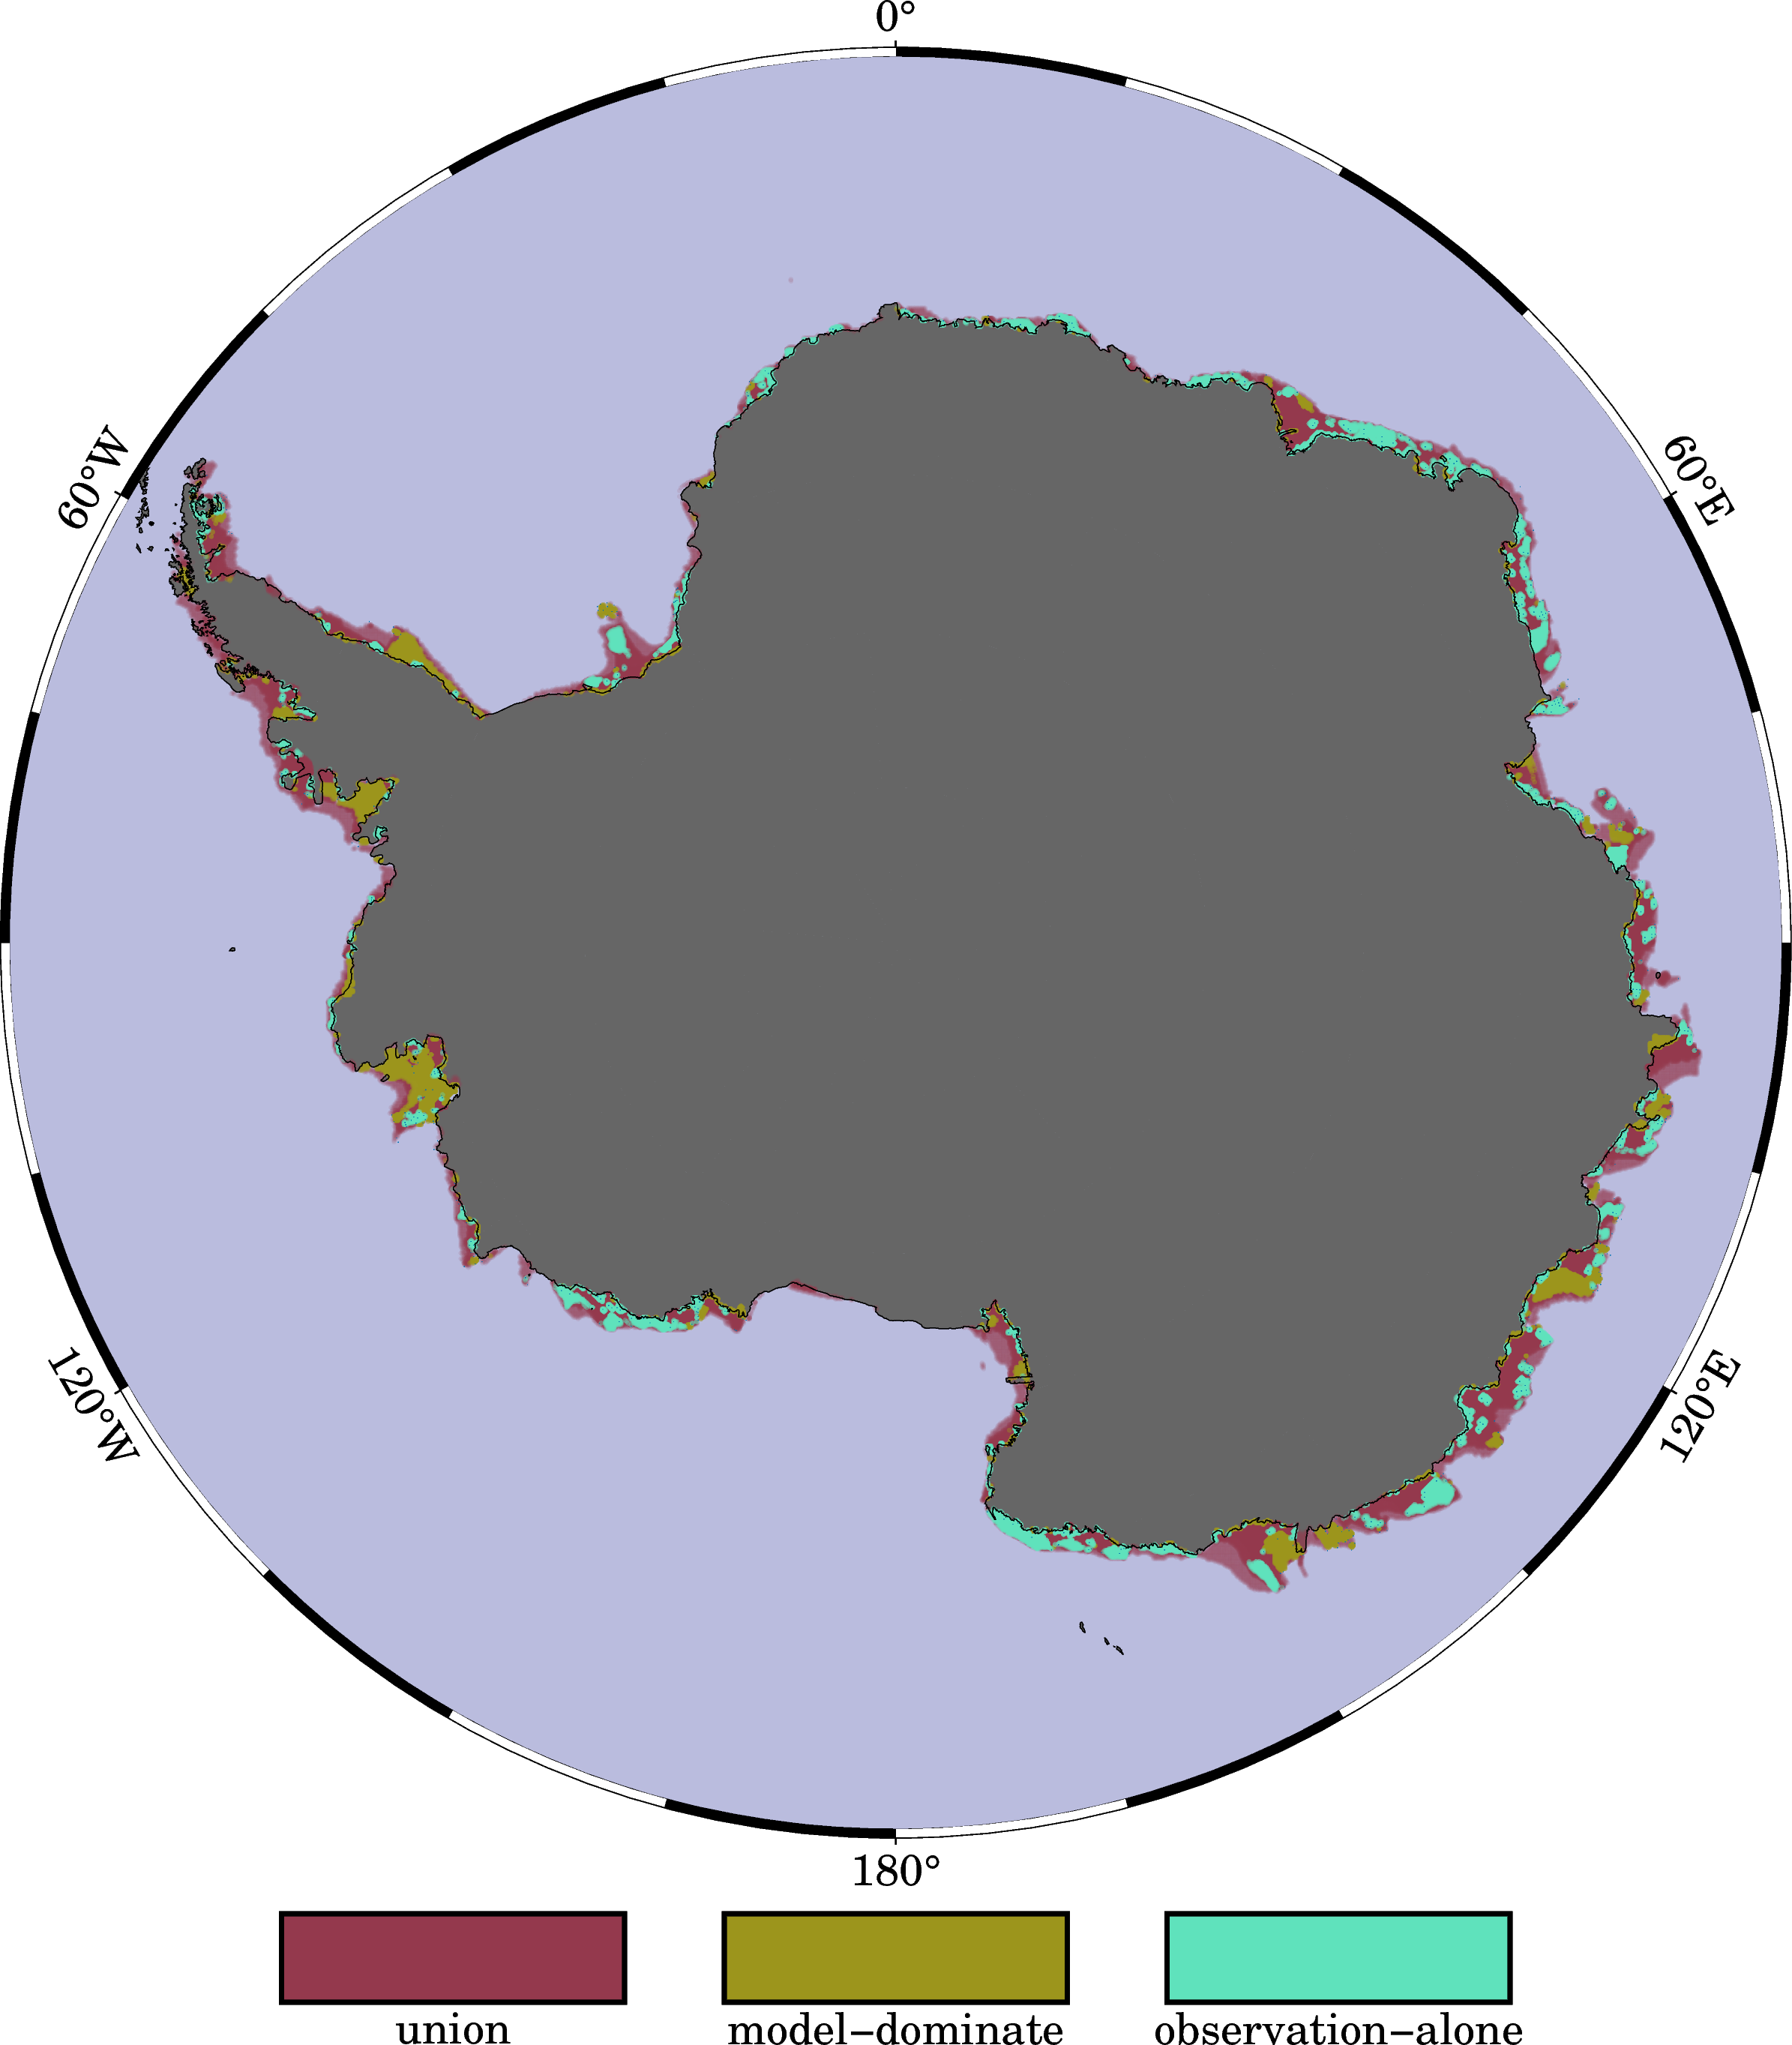

In [ ]:
fig = SI_tools.pygmt_FIP_figure(FIP['diff_cat'],
                       var_name      = "diff_cat",
                       weight_da     = w,
                       region        = region,
                       cmap          = cmap,
                       series        = [-1,1],
                       G_pt_size     = G_pt_size,
                       cbar_frame    = ["xa0.2f0.1+lFast Ice Persistence Difference (mod-obs)"],
                       P_png         = P_diff,
                       show_fig      = True,
                       plot_GI       = True,
                       GI_color      = "#0072B2",
                       cat_series    = (0,1,2),
                       basemap_frame = frame_diff,
                       cat_labels    = ["union", "model-dominate", "observation-alone"])

#### by region

2025-08-28 14:31:37,620 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:37,622 - INFO - Hemisphere slice applied on dims: nj & nj_b.


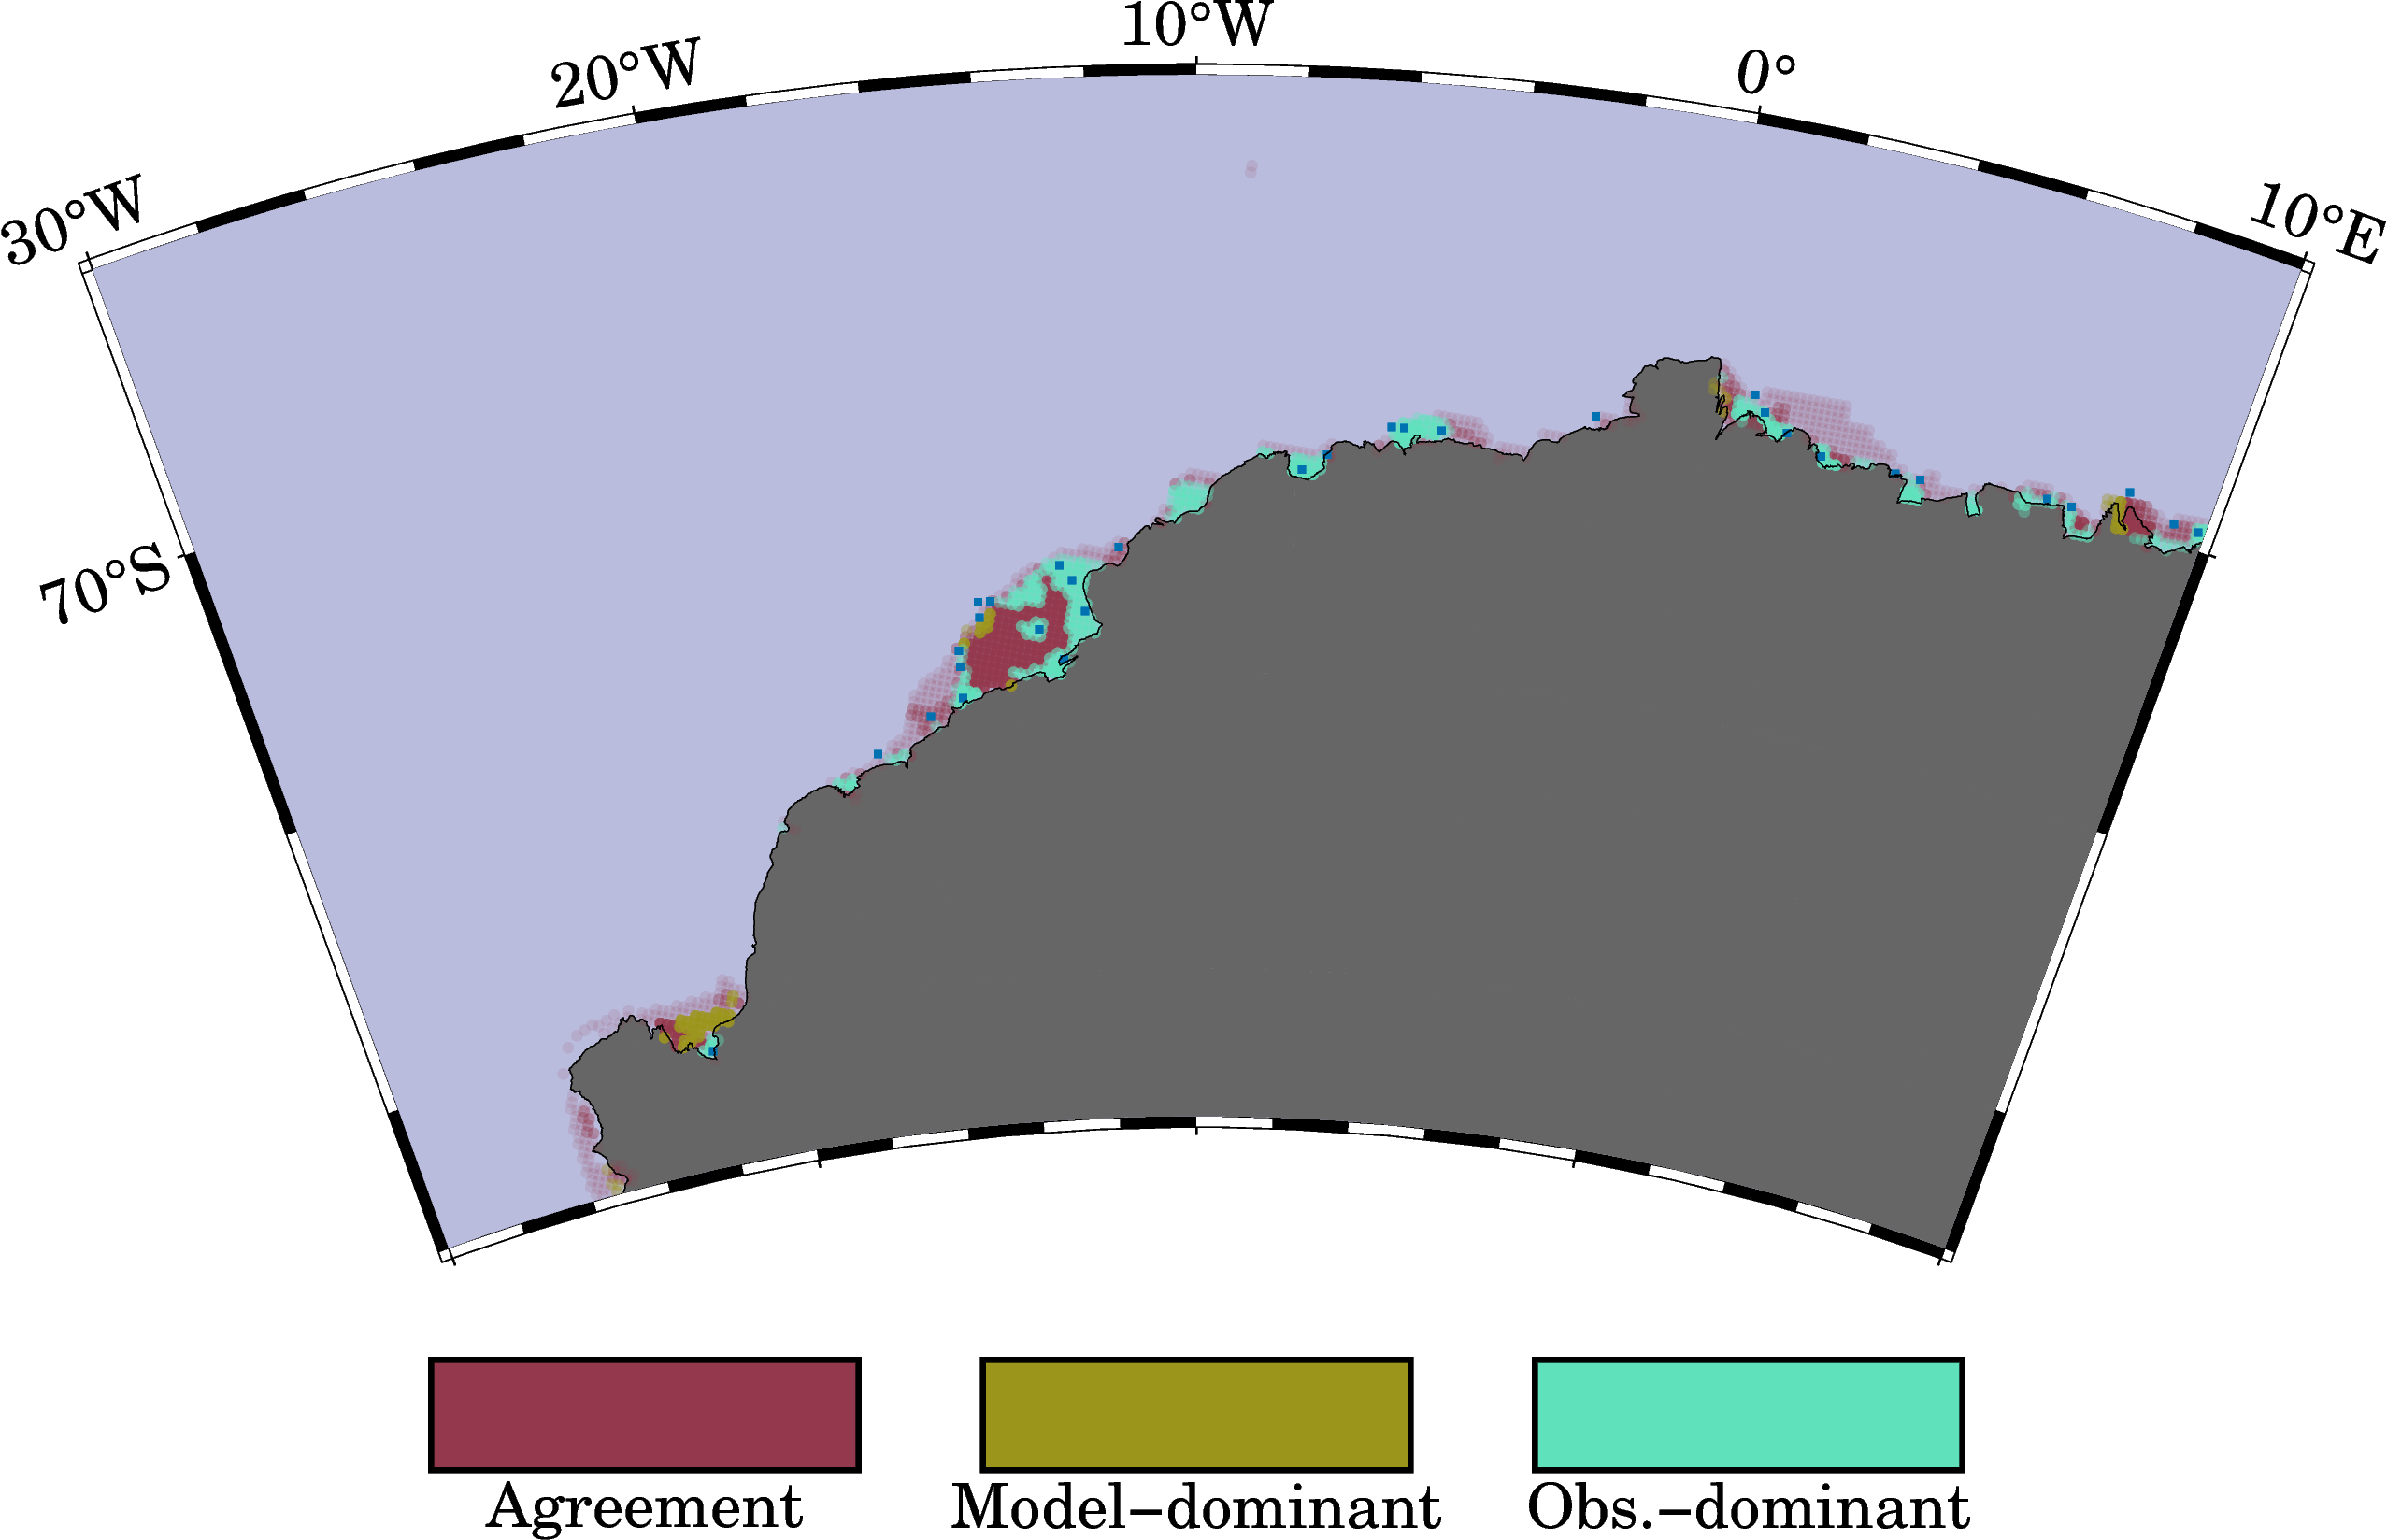

2025-08-28 14:31:40,213 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:40,215 - INFO - Hemisphere slice applied on dims: nj & nj_b.


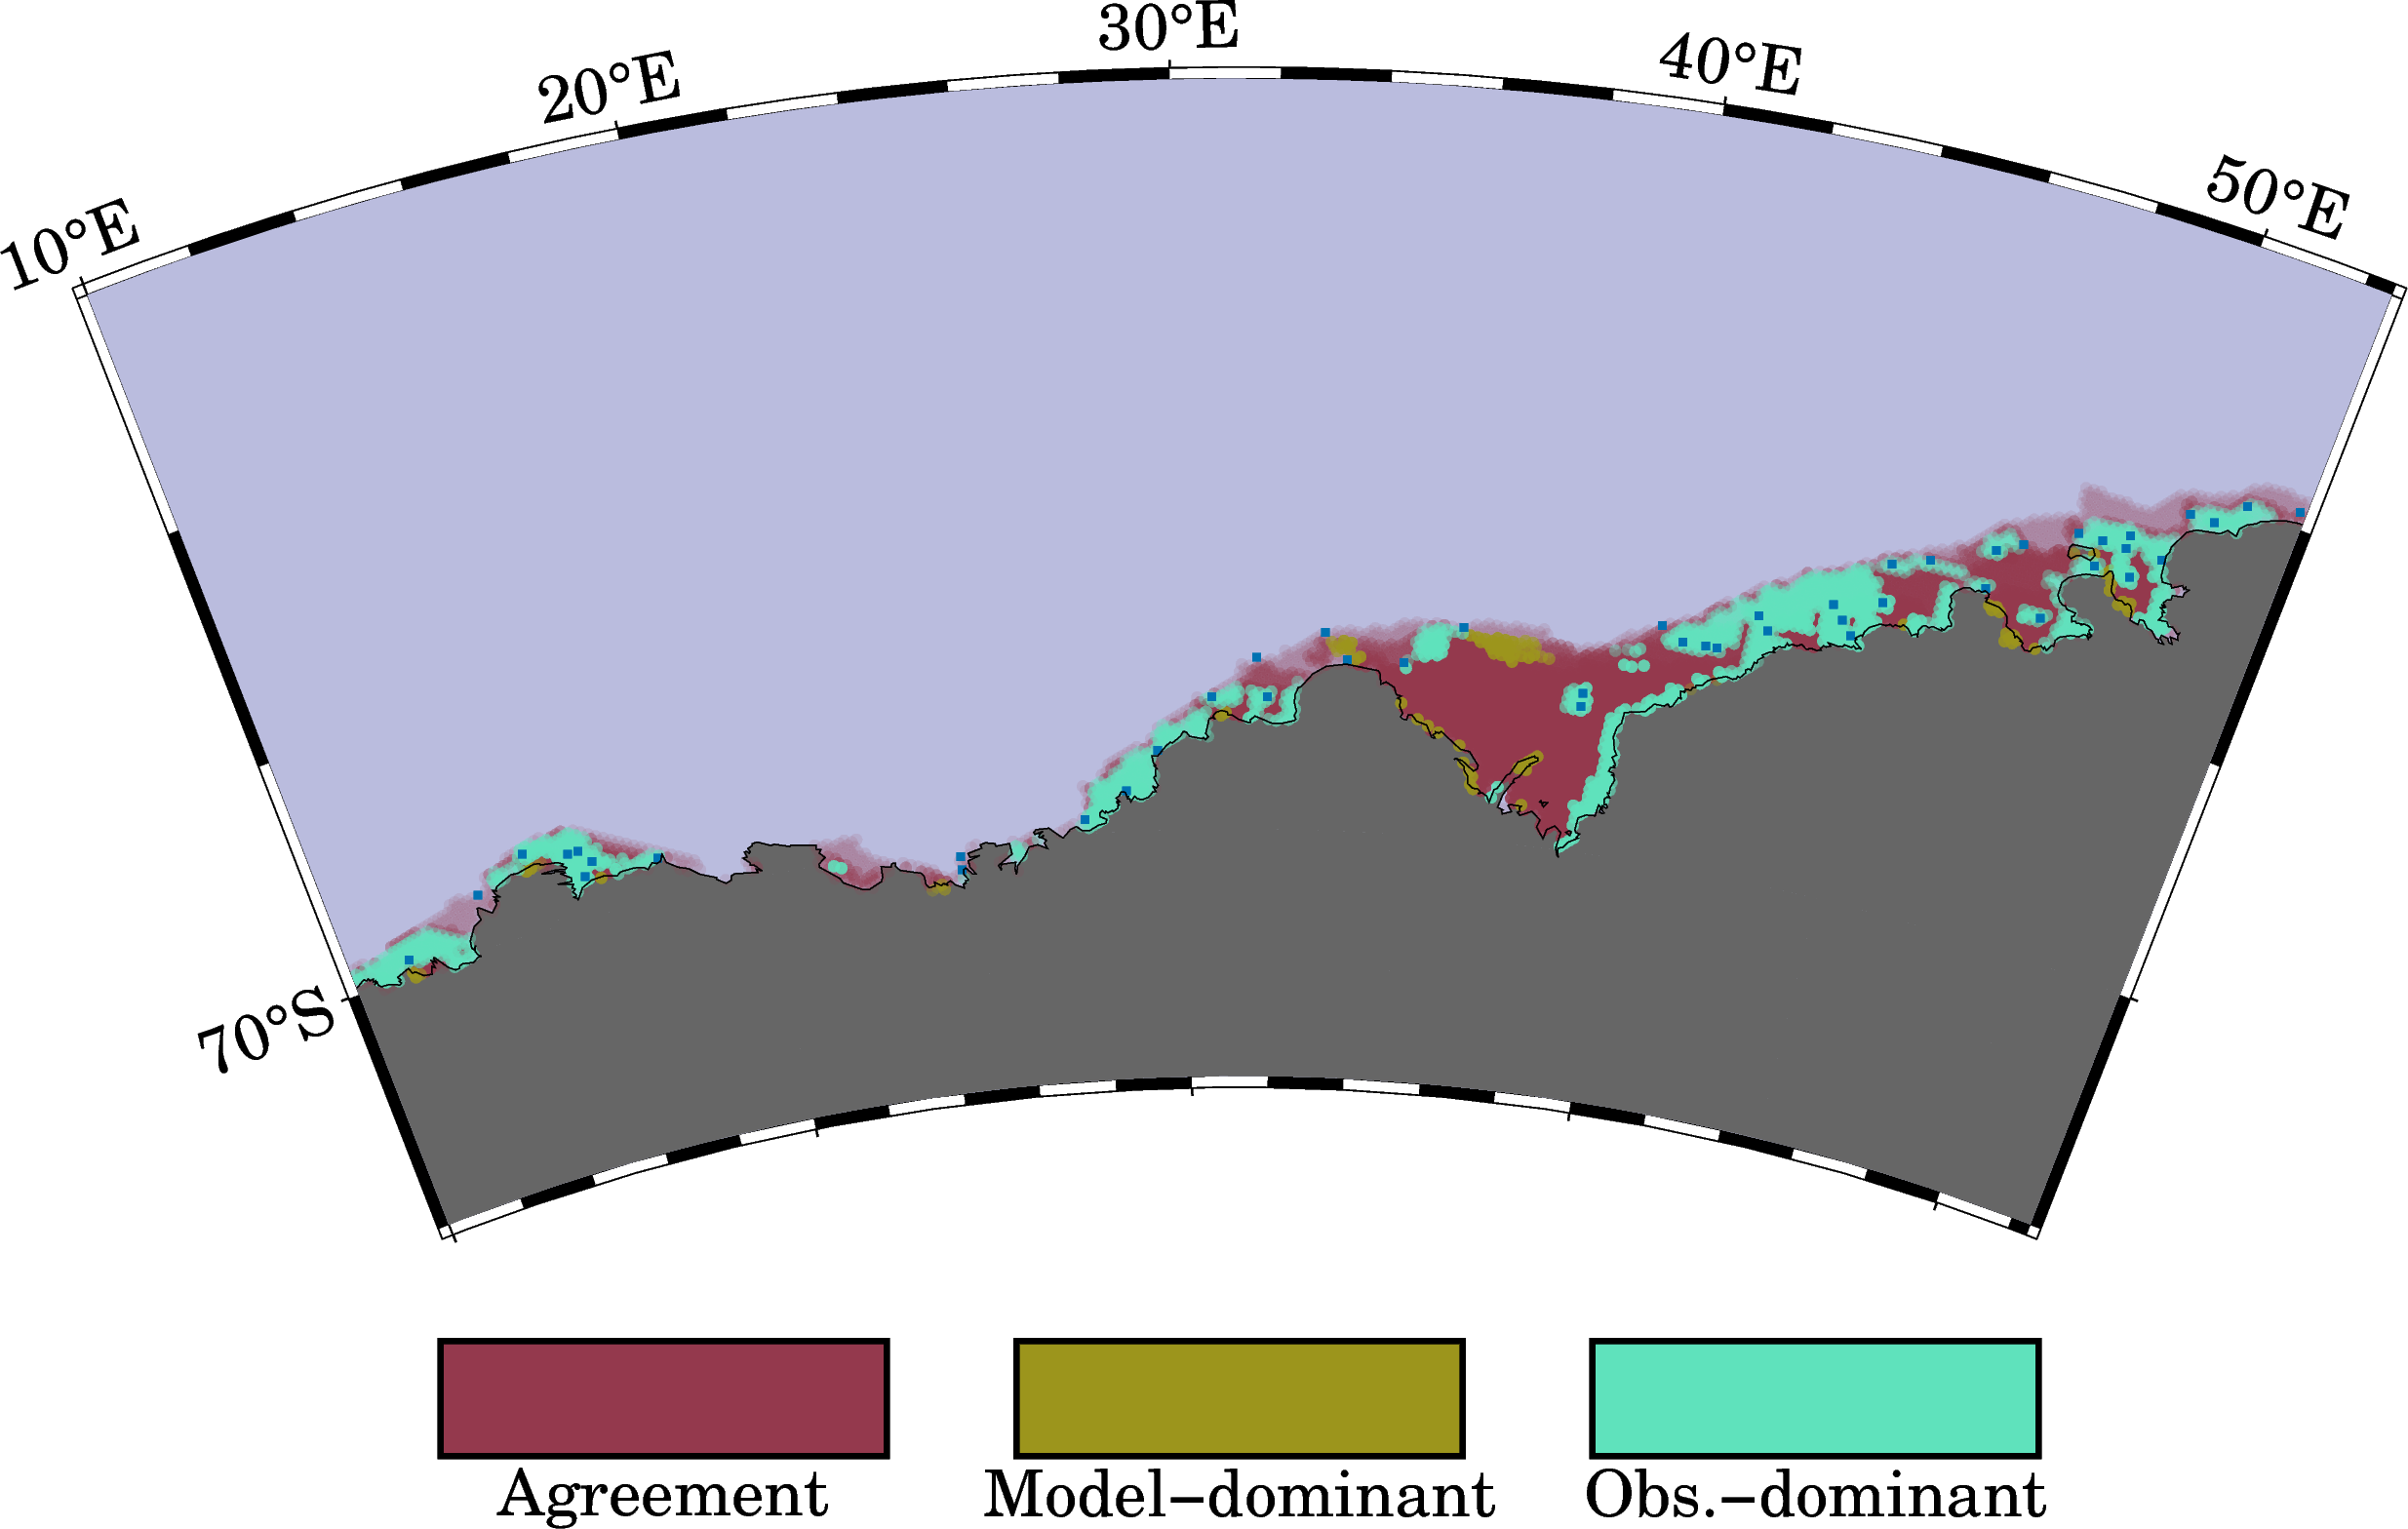

2025-08-28 14:31:43,002 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:43,004 - INFO - Hemisphere slice applied on dims: nj & nj_b.


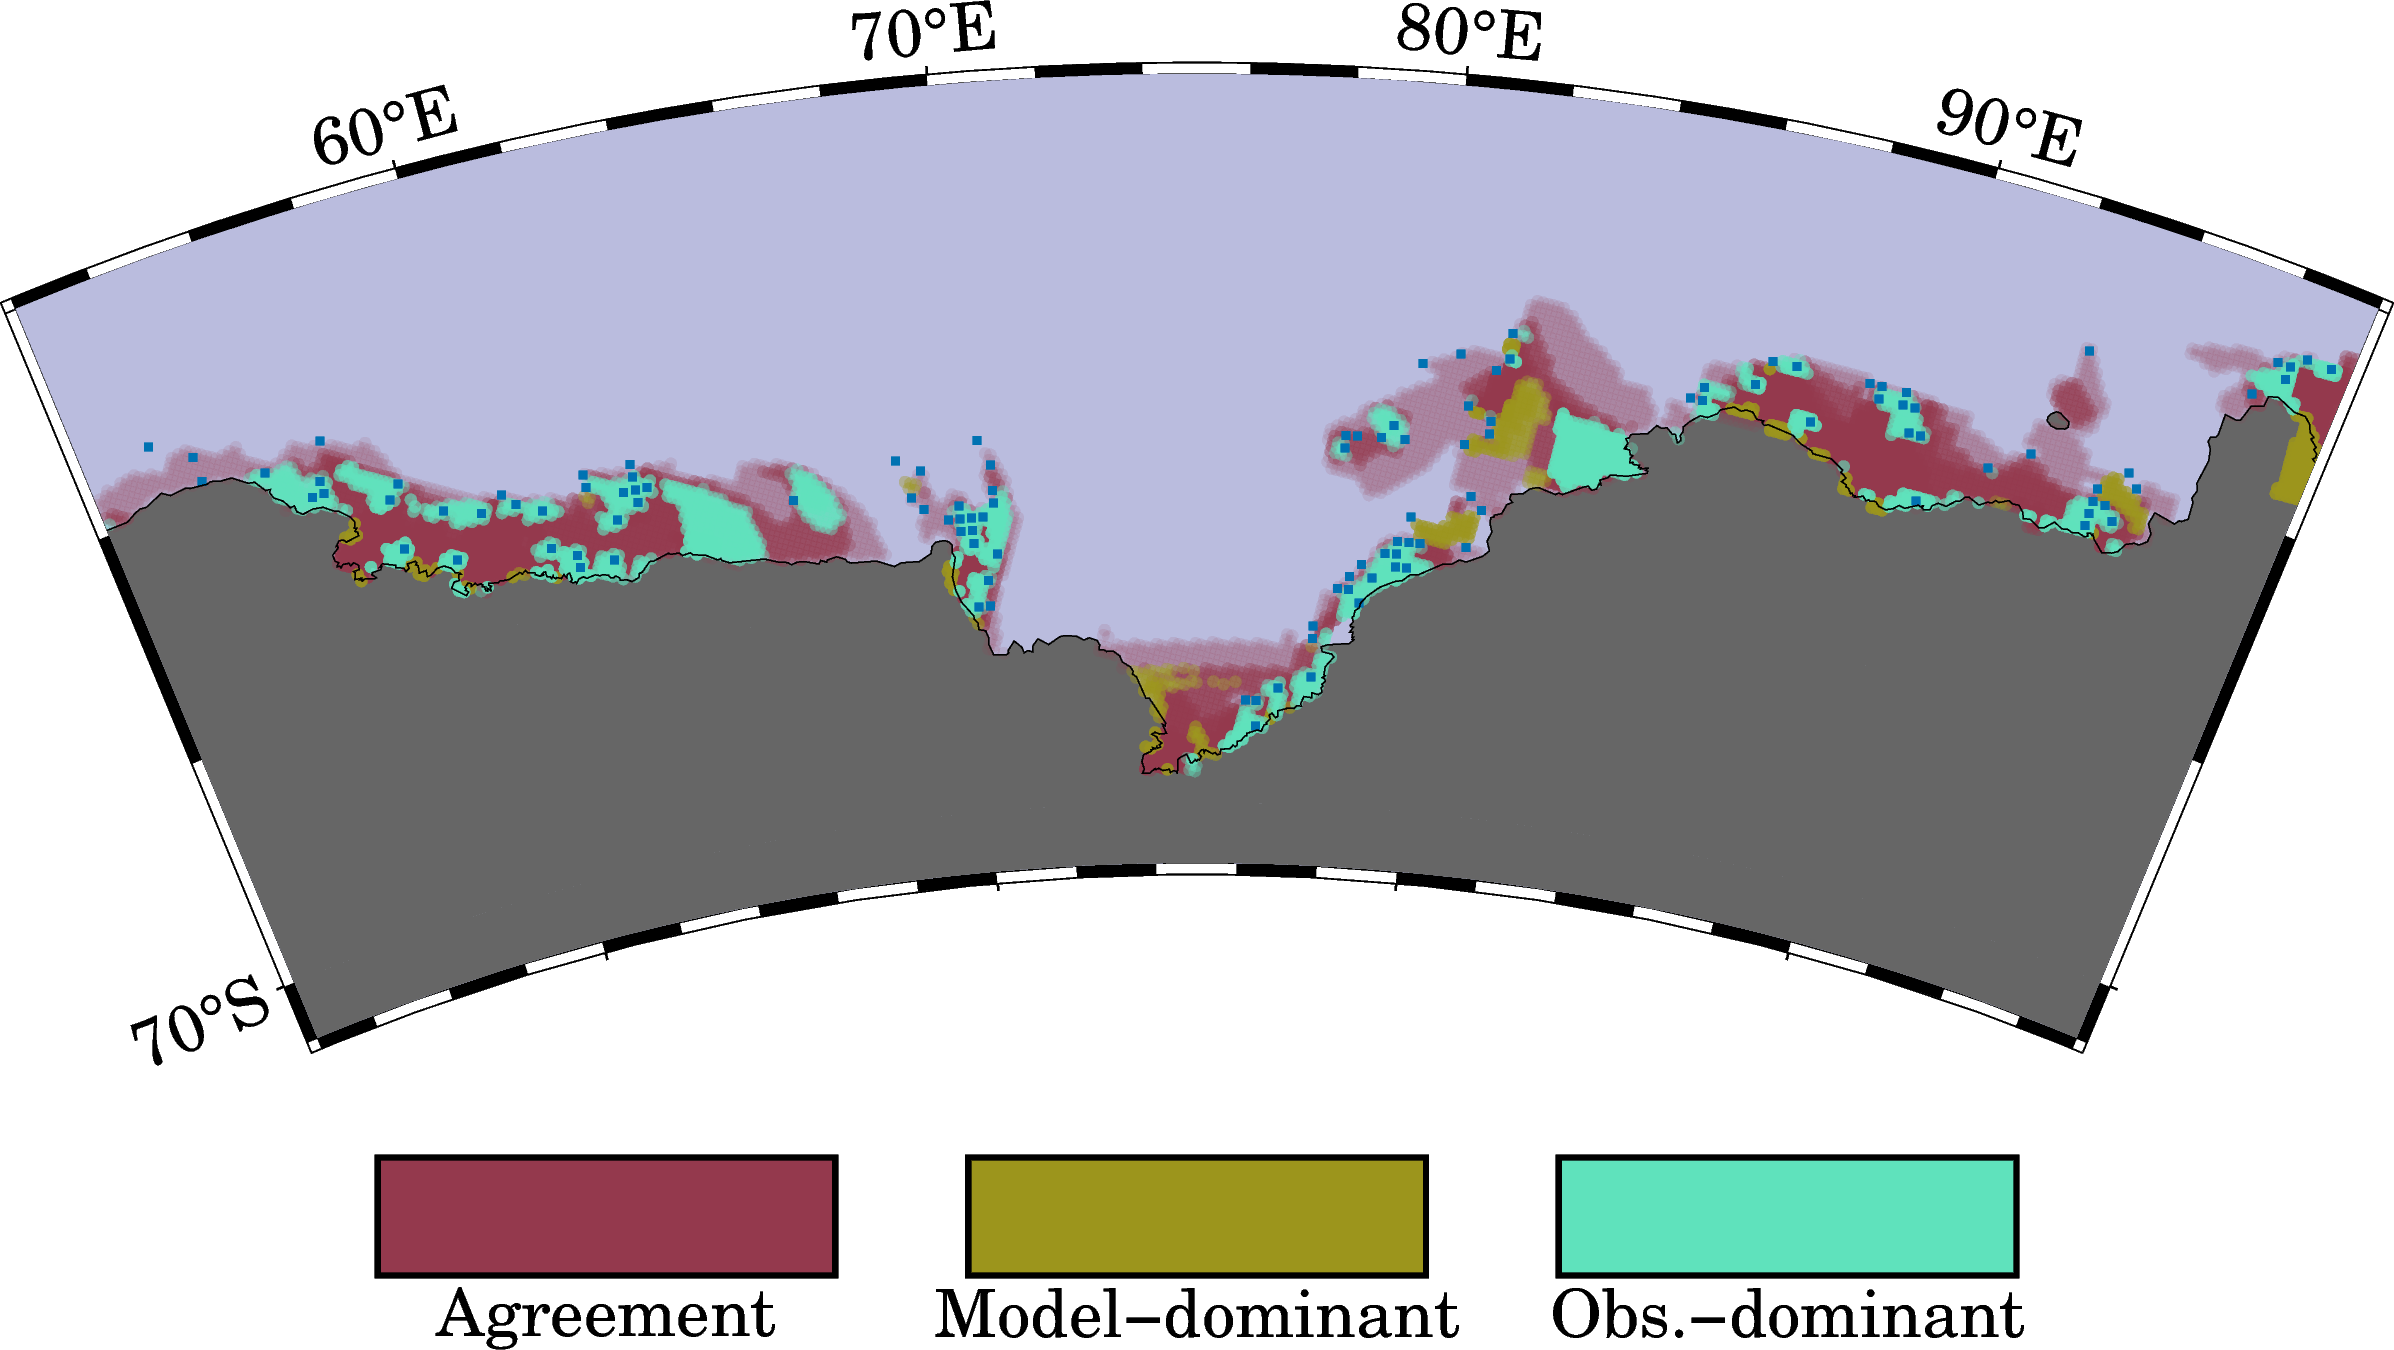

2025-08-28 14:31:46,136 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:46,139 - INFO - Hemisphere slice applied on dims: nj & nj_b.


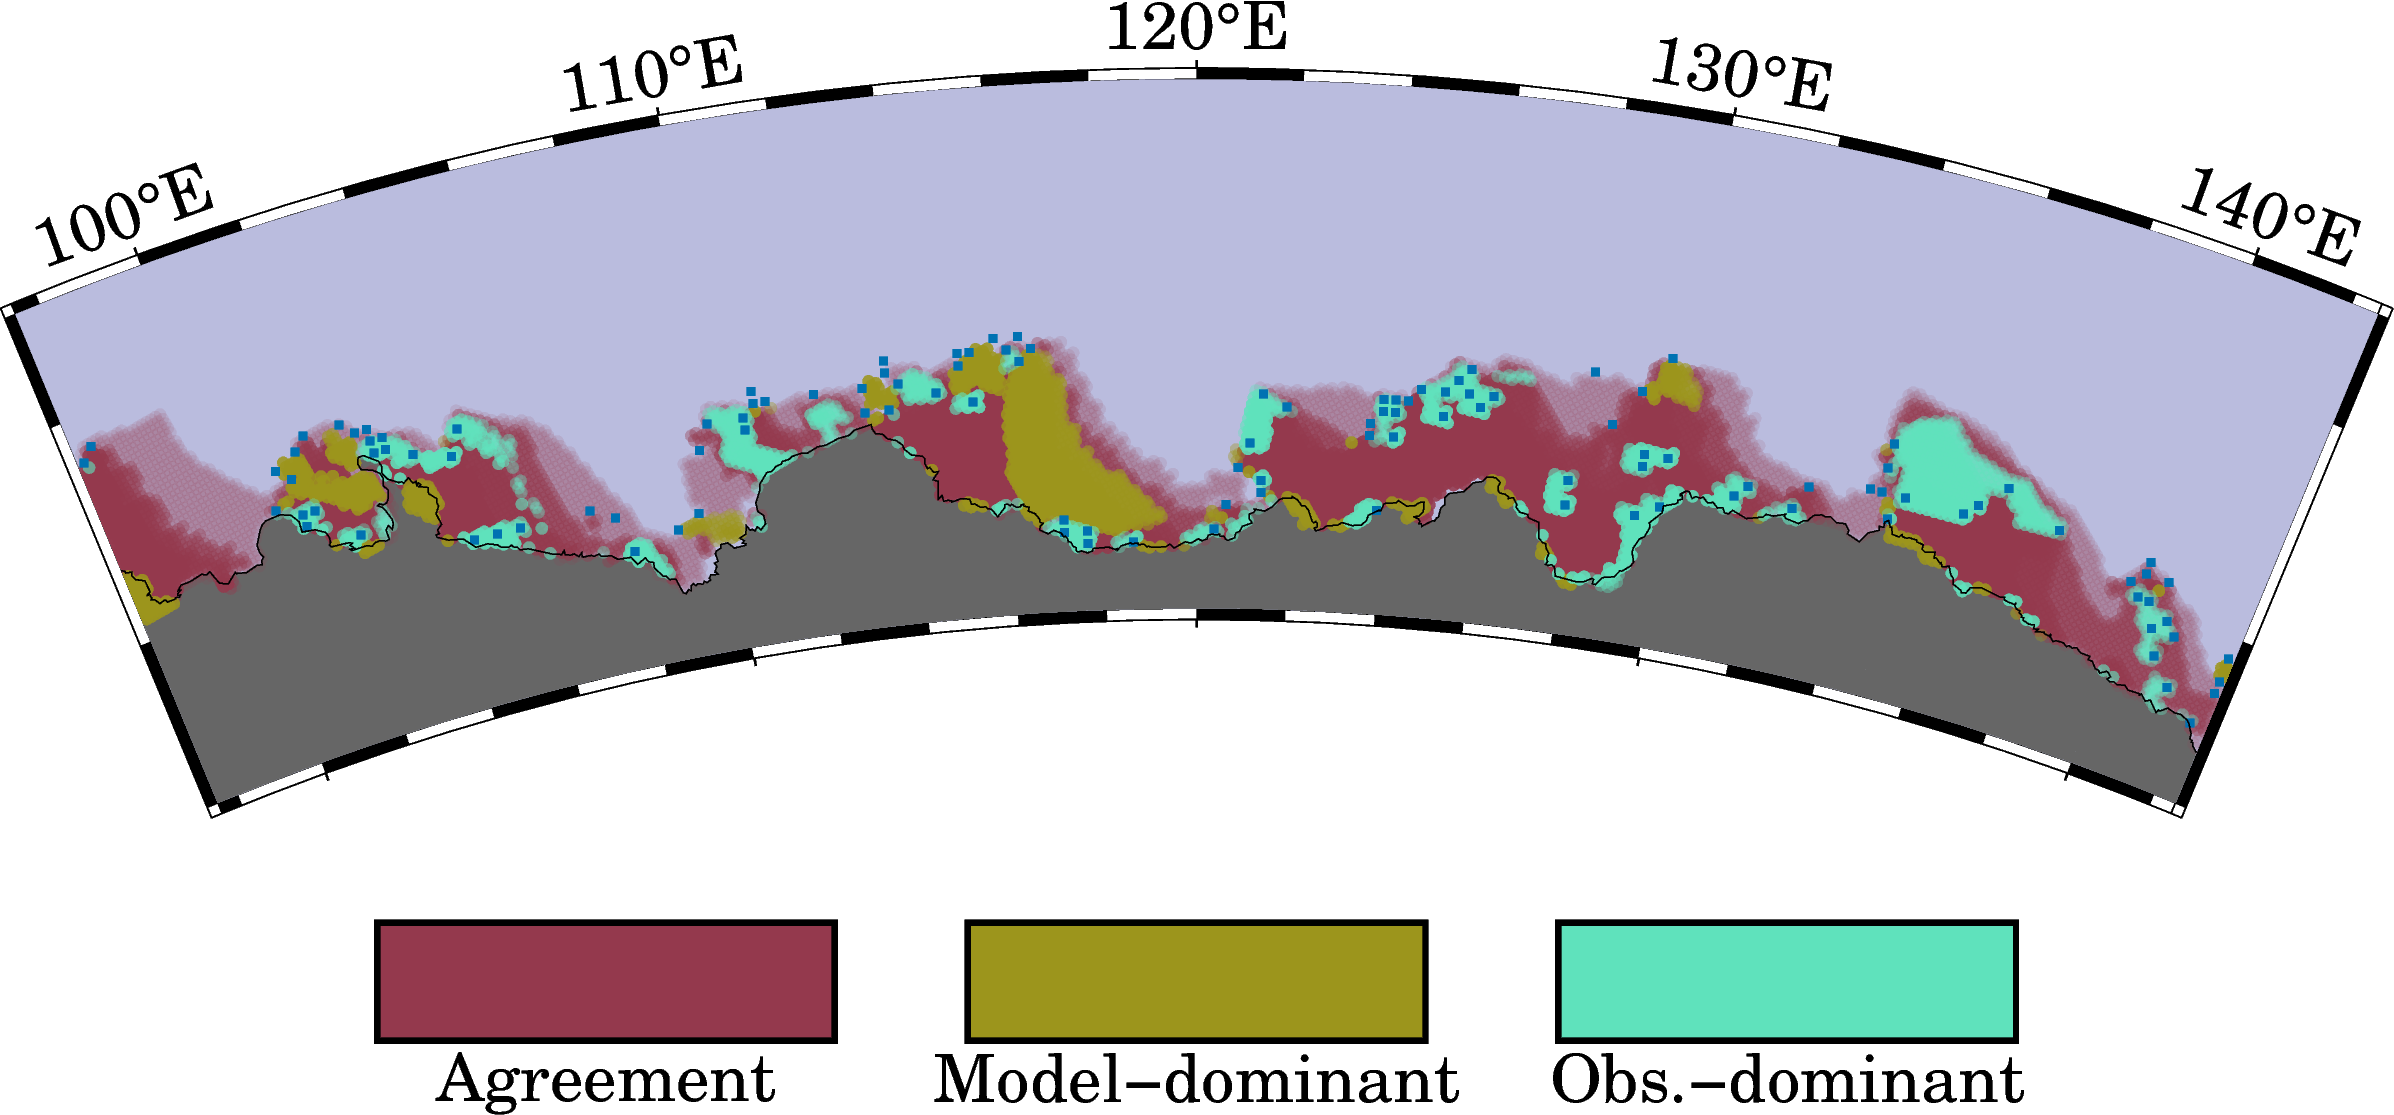

2025-08-28 14:31:49,593 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:49,594 - INFO - Hemisphere slice applied on dims: nj & nj_b.


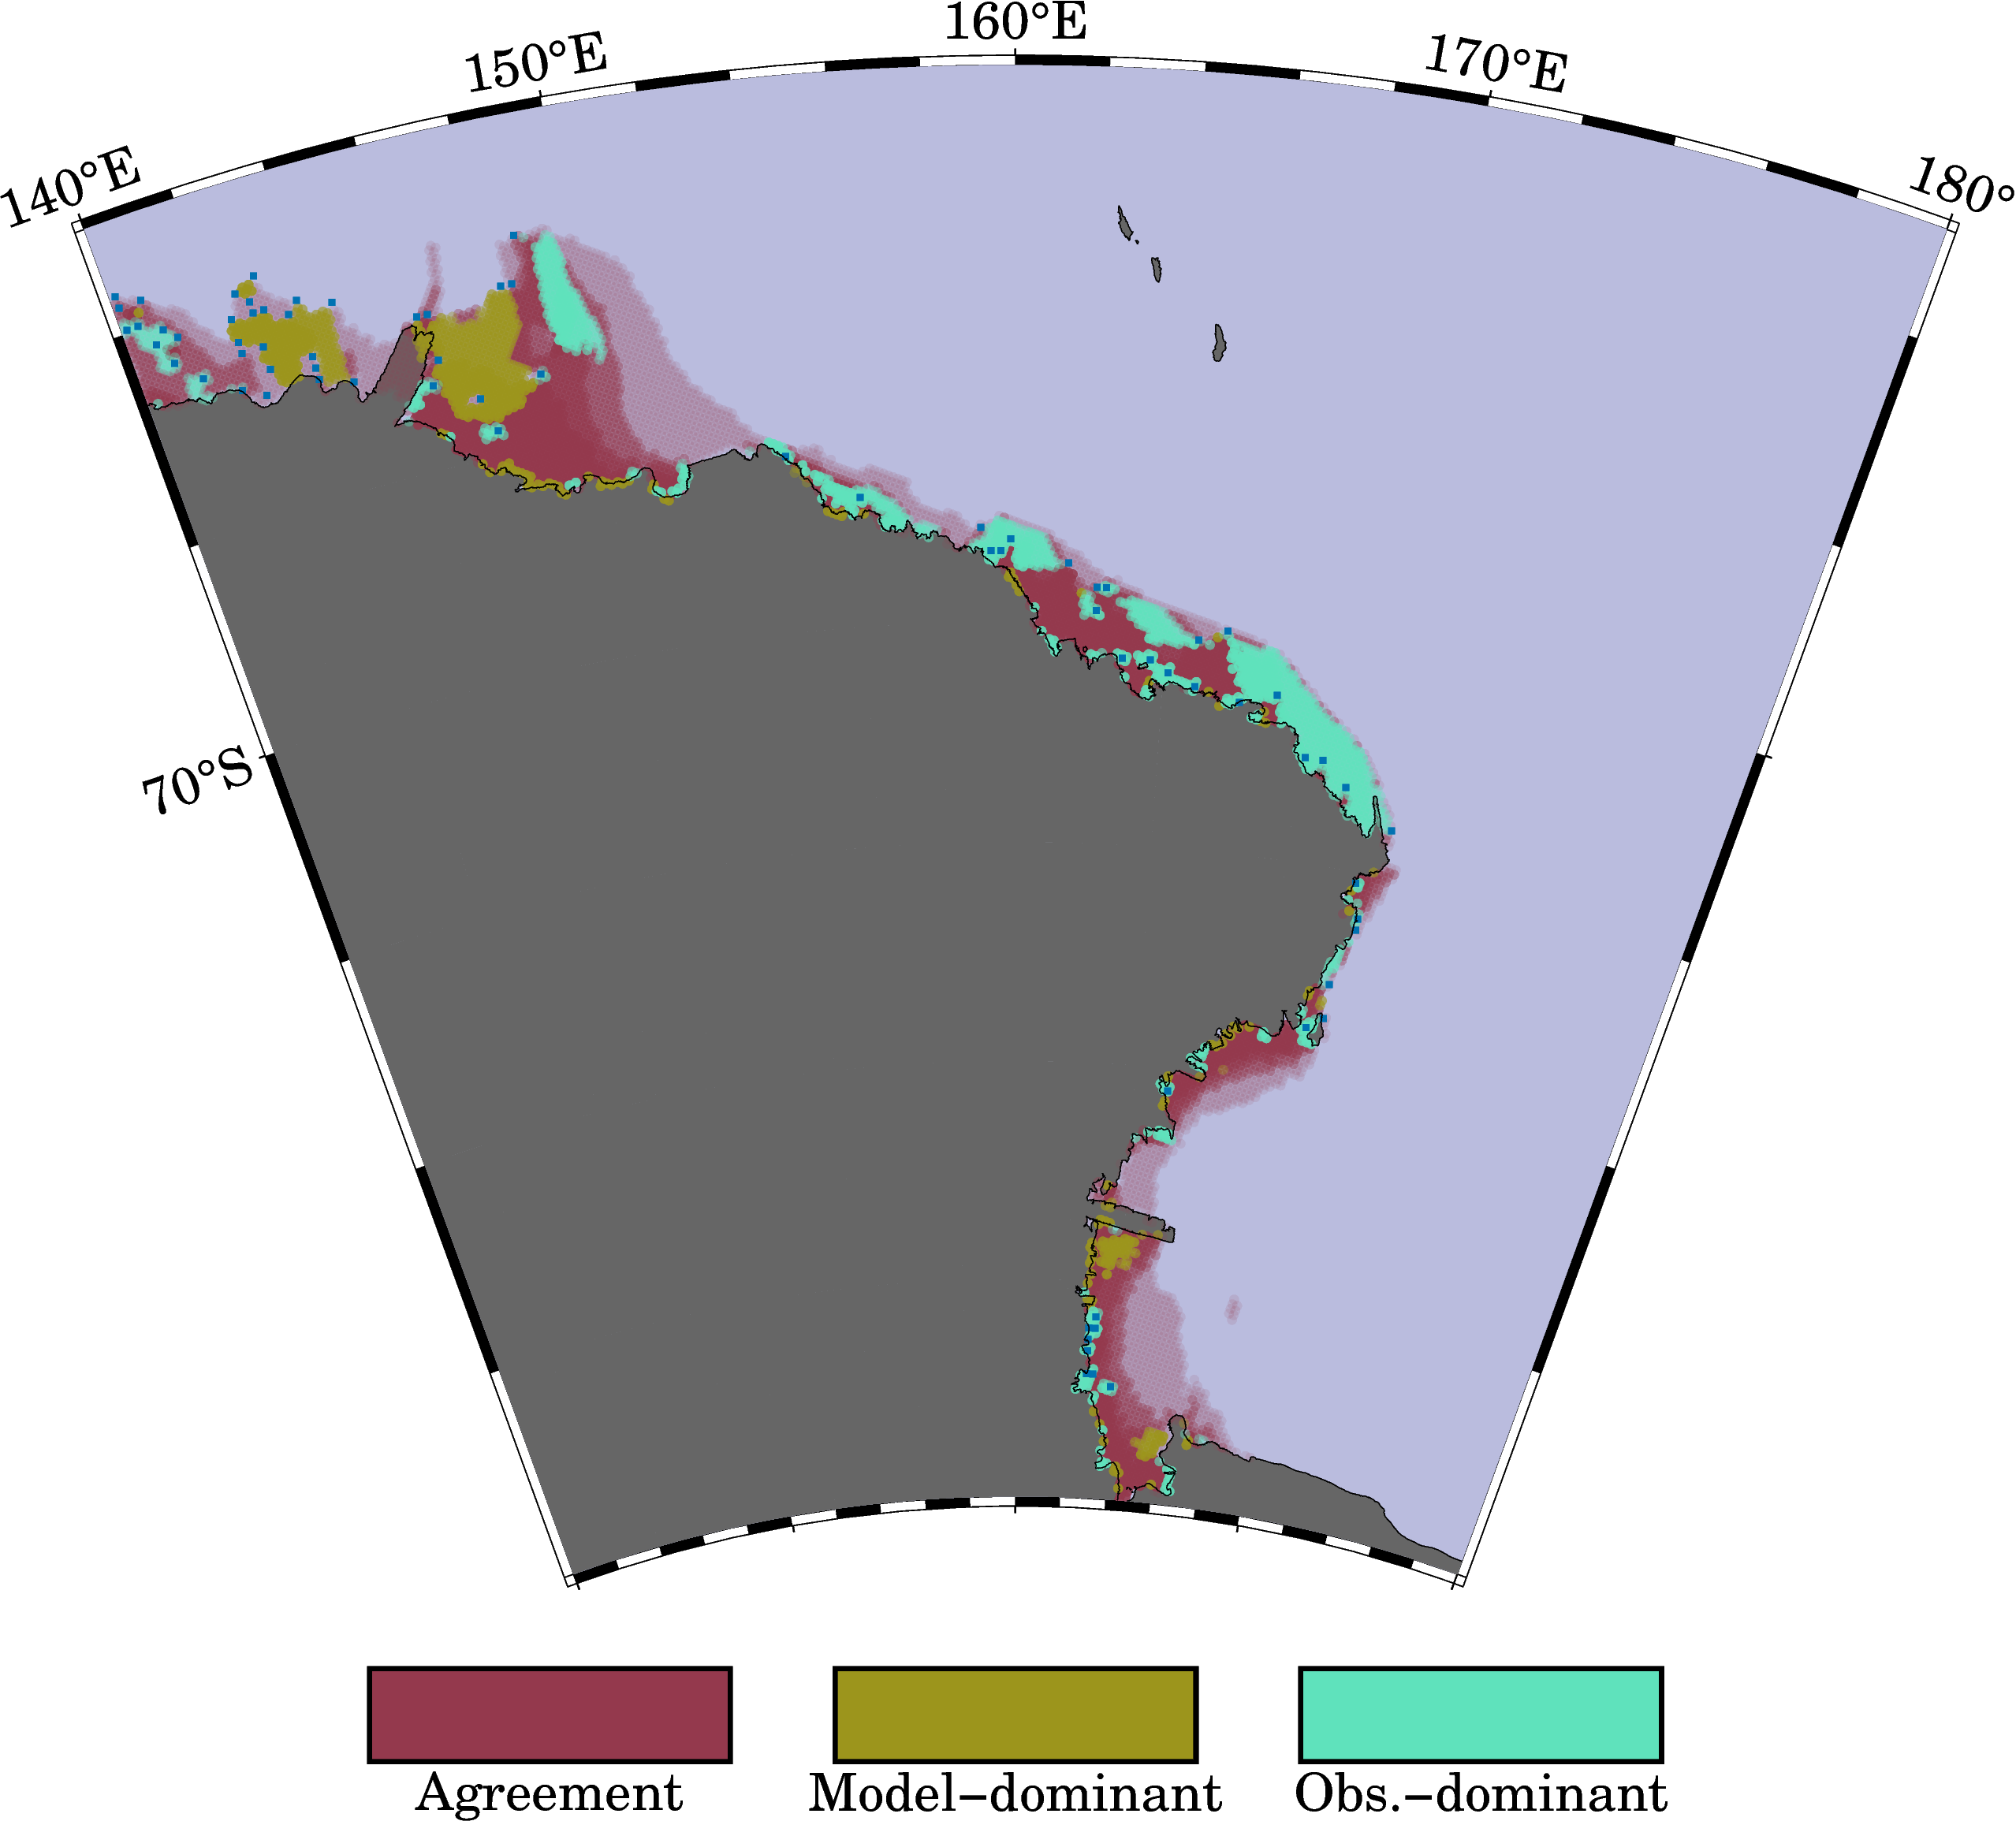

2025-08-28 14:31:53,350 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:53,352 - INFO - Hemisphere slice applied on dims: nj & nj_b.


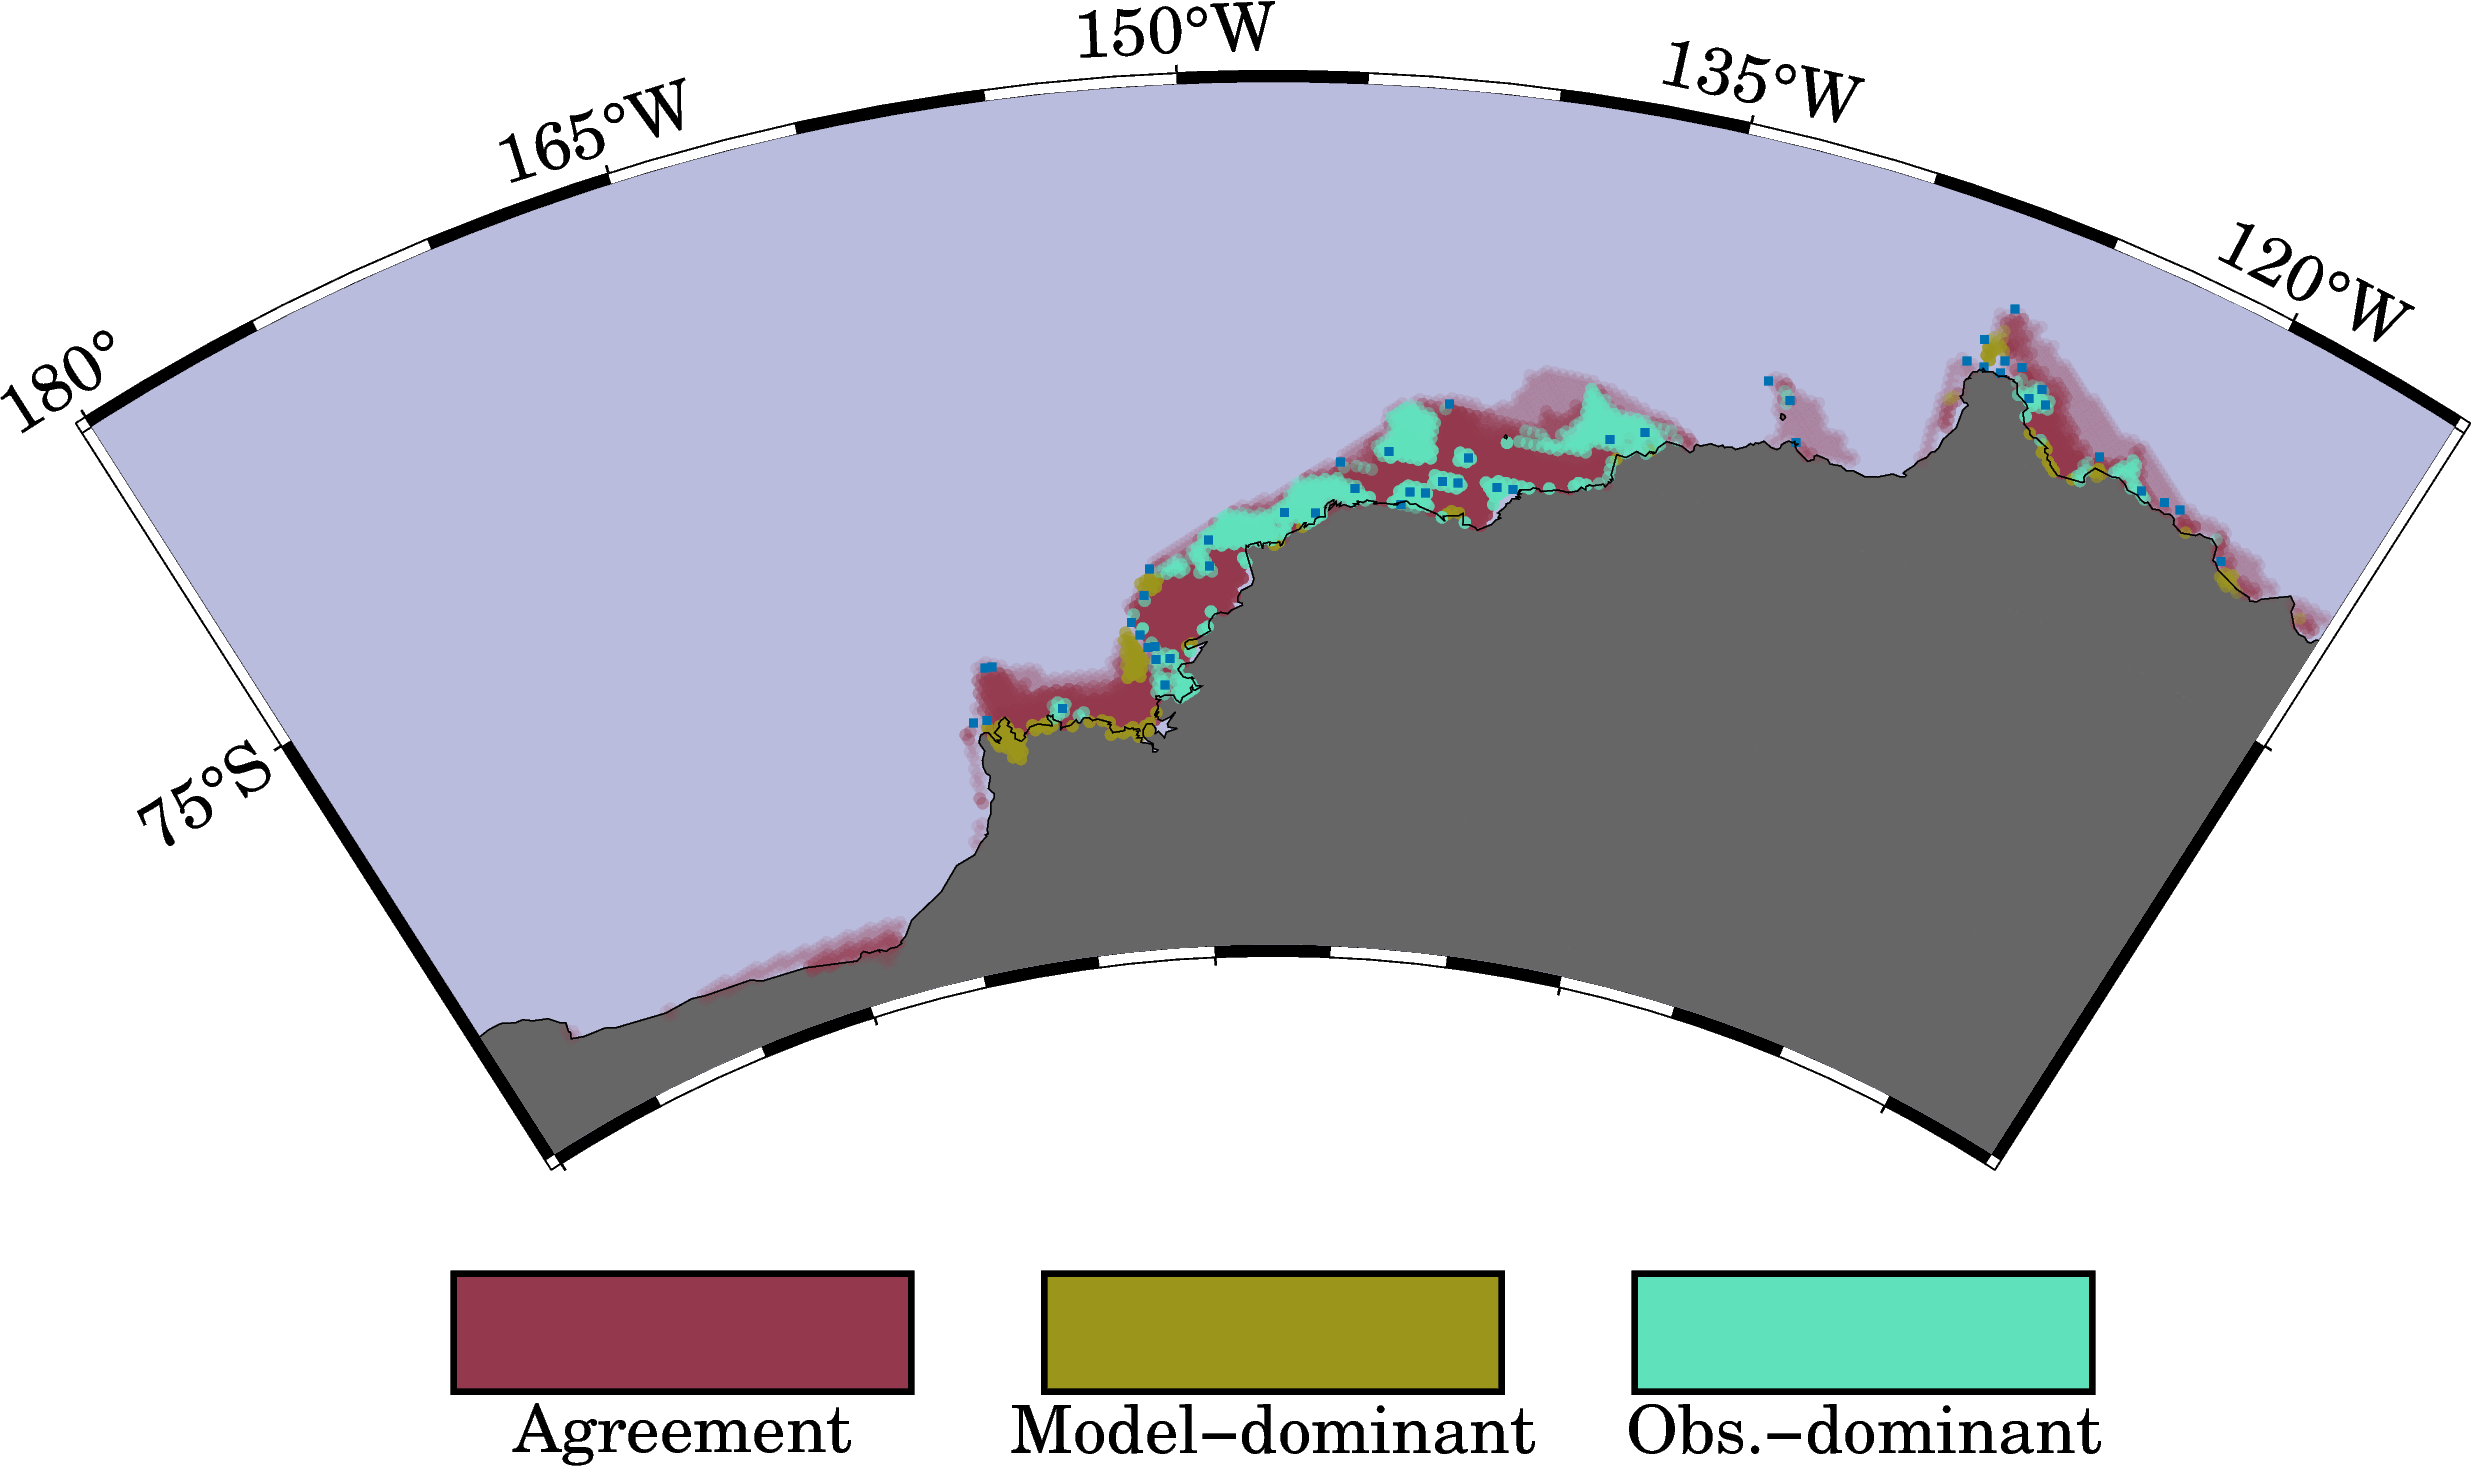

2025-08-28 14:31:56,108 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:56,109 - INFO - Hemisphere slice applied on dims: nj & nj_b.


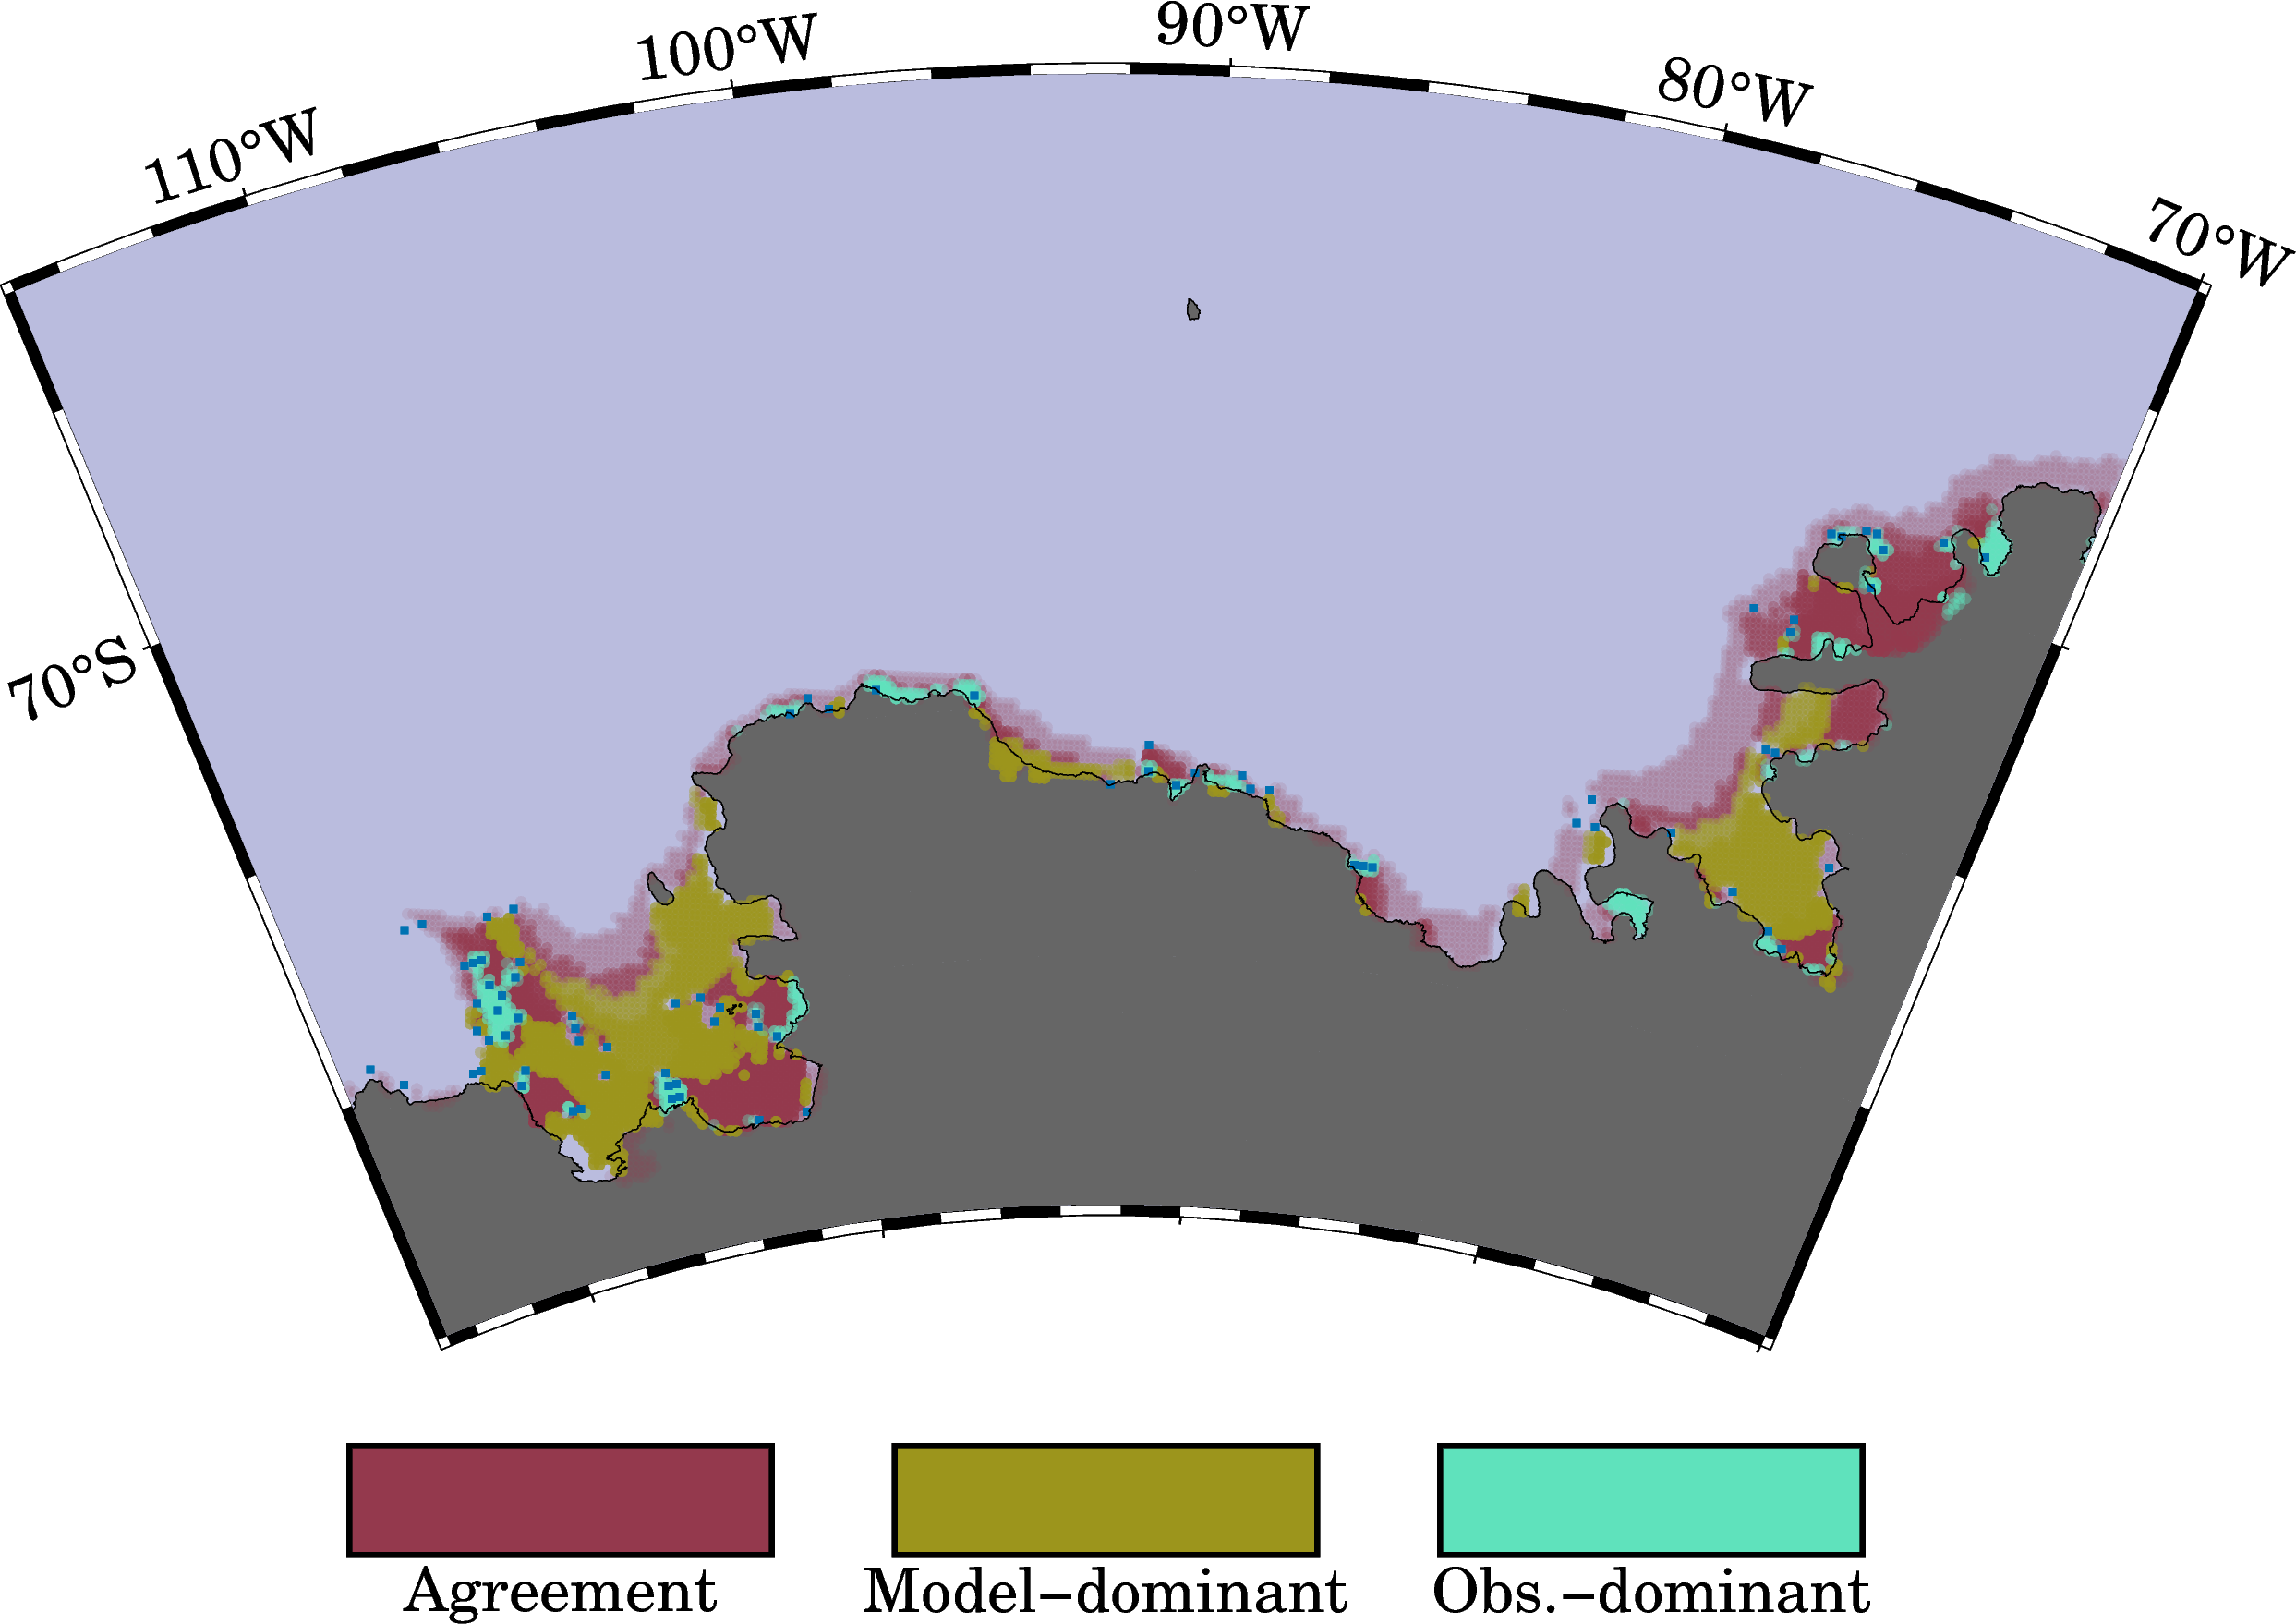

2025-08-28 14:31:59,409 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:59,411 - INFO - Hemisphere slice applied on dims: nj & nj_b.


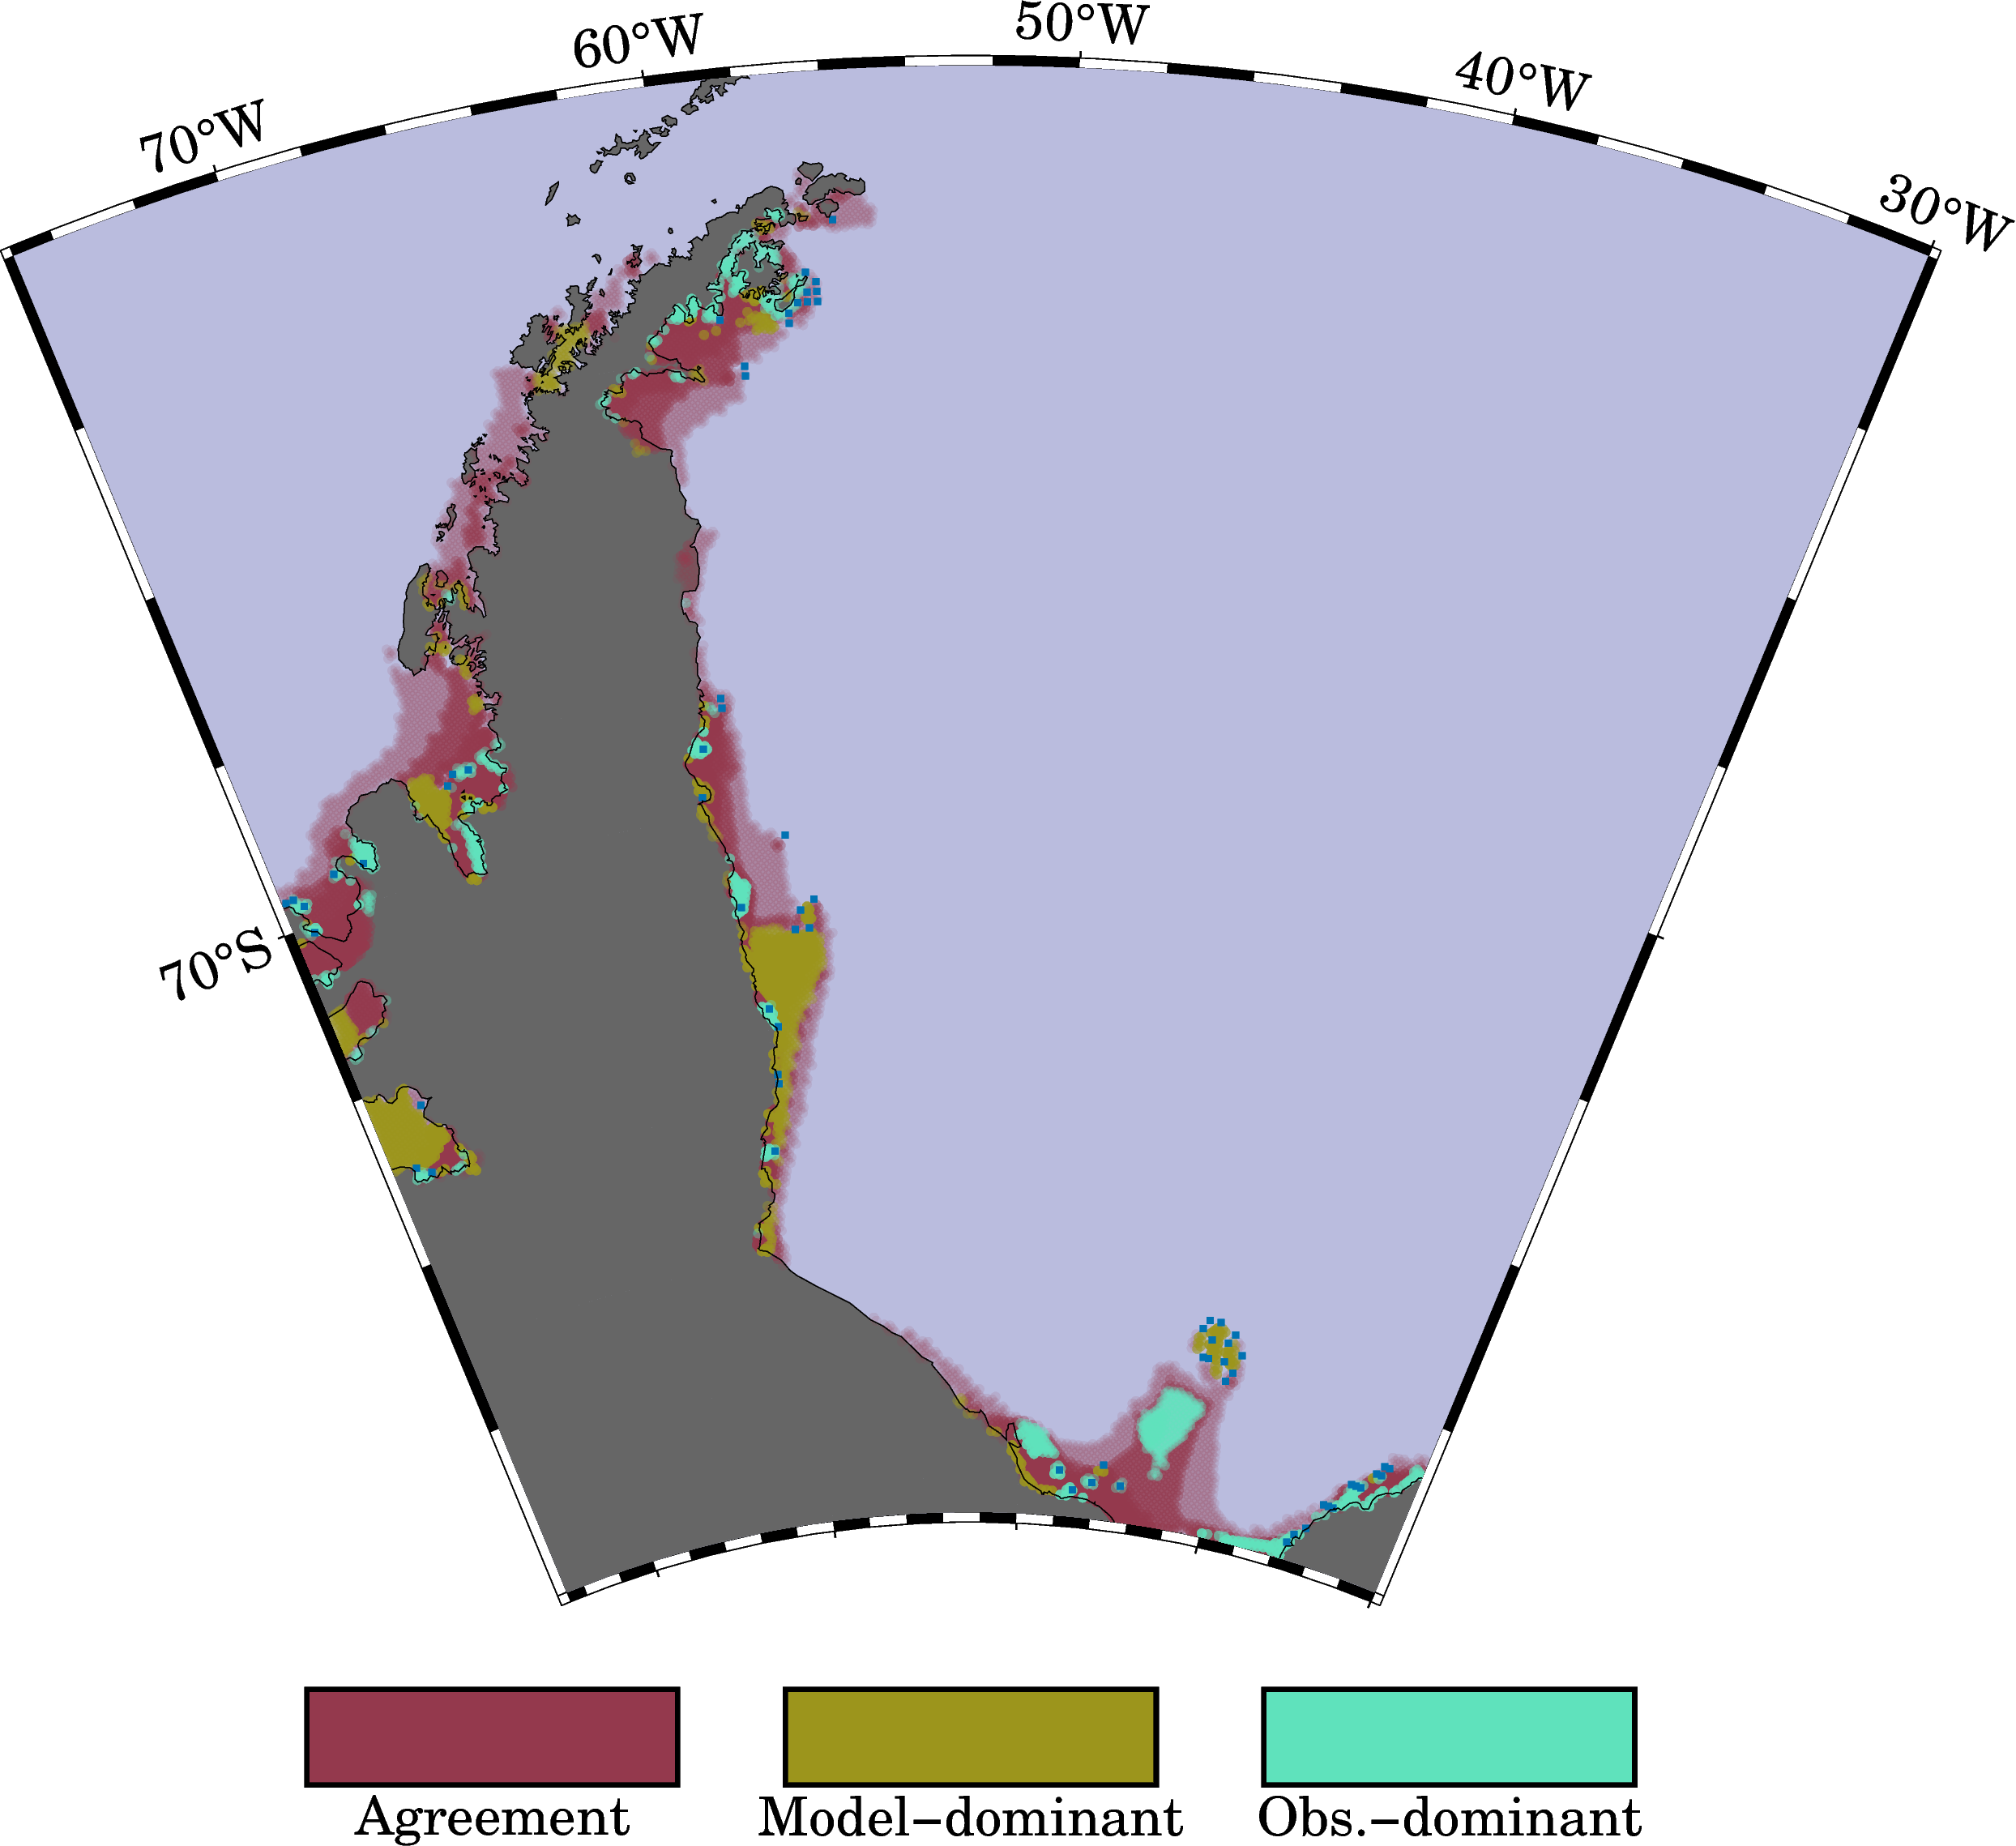

In [ ]:
for i, (reg_name, reg_vals) in enumerate(SI_tools.Ant_8sectors.items()):
    P_png      = SI_tools.D_graph / sim_name / reg_name / "FIP" / f"FIP-diff-cat_{sim_name}-AF2020_2000-2018_{reg_name}.png"
    region     = reg_vals['plot_region']
    projection = reg_vals['projection']
    MC         = SI_tools.get_meridian_center_from_geographic_extent(region)
    projection = projection.format(MC=MC, fig_size=fig_size)
    fig = SI_tools.pygmt_FIP_figure(FIP['diff_cat'],
                                    var_name      = "diff_cat",
                                    weight_da     = w,
                                    region        = region,
                                    projection    = projection,
                                    G_pt_size     = "0.1",
                                    P_png         = P_png,
                                    show_fig      = True,
                                    plot_GI       = True,
                                    GI_color      = "#0072B2",
                                    GI_size       = "0.1",
                                    cat_series    = (0,1,2),
                                    
                                    basemap_frame = frame_diff,
                                    plot_bathymetry = False,
                                    cat_labels    = ["Agreement", "Model-dominant", "Obs.-dominant"])

#### animation

In [2]:
sim_name = "elps-min"
for region in SI_tools.Ant_8sectors.keys():
    SI_tools = SeaIceToolbox(sim_name=sim_name)
    D_png = Path(SI_tools.D_graph, sim_name, region, "FI_diff")
    D_ani = Path(SI_tools.D_graph, "animations", sim_name, "FI_diff")
    F_ani = f"{sim_name}_FI-diff_{region}_2000-2018.mp4"
    P_ani = Path(D_ani,F_ani)
    P_mp4 = Path.home() / "AFIM" / "src" / "AFIM" / "docs" / "figures" / F_ani
    D_ani.mkdir(parents=True, exist_ok=True)
    frames = sorted([f for f in os.listdir(D_png) if f.endswith(".png")])
    os.system(f"rm {SI_tools.D_tmp}/frame_*.png")
    for i, f in enumerate(frames):
        src = D_png / f
        dst = Path(SI_tools.D_tmp) / f"frame_{i:04d}.png"
        if not dst.exists():
            os.symlink(src, dst)
    os.system(f"ffmpeg -y -r 2 -i {SI_tools.D_tmp}/frame_%04d.png -vf \"scale=iw:ih+mod(2-ih\\,2)\" -c:v libx264 -pix_fmt yuv420p {P_ani}")
    os.system(f"cp {P_ani} {P_mp4}")
    

NameError: name 'SI_tools' is not defined

## Figure 16: Interannual Variability

In [ ]:
FIA_dict    = {}
sim_name    = "elps-min"
dt0_str     = "2000-01-01"
dtN_str     = "2018-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                      dtN_str  = dtN_str,
                                      sim_name = sim_name)
FIA_dict['AF2020']  = {'FIA' : SI_tools.load_AF2020_FIA_summary()['FIA_obs']}
P_zarr              = Path(SI_tools.D_ispd_thresh, "FI_BT_bin_mets.zarr")
SI_tools.logger.info(f"opening zarr met file: {P_zarr}")
ds                   = xr.open_zarr(P_zarr, consolidated=False)
FIA_dict[sim_name]   = {'FIA'   : ds['FIA']}
print(FIA_dict)

In [ ]:
from matplotlib.ticker import MaxNLocator

# -----------------------------
# Config
# -----------------------------
ANNUAL_AGG = "mean"  # choose: "mean", "max", or "min"
T0 = np.datetime64("2000-03-01")
T1 = np.datetime64("2018-03-01")
OUTA = "/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figA.png"
OUTB = "/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figB.png"

# -----------------------------
# 1) Extract and harmonise
# -----------------------------
D = FIA_dict  # your dict

da_obs = D["AF2020"]["FIA"]
da_sim = D["elps-min"]["FIA"]

# Harmonise coord name + dtype + sort
if "date" in da_obs.coords:
    da_obs = da_obs.rename({"date": "time"})
da_obs = da_obs.assign_coords(time=pd.to_datetime(da_obs["time"].values)).sortby("time")
da_sim = da_sim.assign_coords(time=pd.to_datetime(da_sim["time"].values)).sortby("time")

# -----------------------------
# 2) Restrict to exact window
# -----------------------------
da_obs = da_obs.sel(time=slice(T0, T1))
da_sim = da_sim.sel(time=slice(T0, T1))

# -----------------------------
# 3) Fortnightly analysis (match obs sample rate)
#    We average within 14-day bins starting at T0
# -----------------------------
# Using resample('14D') after slicing at T0 aligns both to the same bin edges
obs_14d = da_obs.resample(time="14D", label="left").mean()
sim_14d = da_sim.resample(time="14D", label="left").mean()

# Ensure the two have identical time stamps (take safe intersection)
common_times = np.intersect1d(obs_14d["time"].values, sim_14d["time"].values)
obs_14d = obs_14d.sel(time=common_times)
sim_14d = sim_14d.sel(time=common_times)

# -----------------------------
# 4) Annual metrics from fortnightly means
# -----------------------------
def annual_from_fortnight(da, agg="mean"):
    r = da.resample(time="YS")
    if agg == "mean":
        out = r.mean()
    elif agg == "max":
        out = r.max()
    elif agg == "min":
        out = r.min()
    else:
        raise ValueError("agg must be one of: mean, max, min")
    # Index by calendar year for clean plotting
    s = out.to_series()
    s.index = s.index.year
    return s

ya_obs = annual_from_fortnight(obs_14d, ANNUAL_AGG)
ya_sim = annual_from_fortnight(sim_14d, ANNUAL_AGG)

years = ya_obs.index.intersection(ya_sim.index)
if len(years) < 3:
    raise RuntimeError(
        f"Insufficient overlapping years in [{T0} → {T1}]. "
        f"Obs years={ya_obs.index.min()}–{ya_obs.index.max()}, "
        f"Sim years={ya_sim.index.min()}–{ya_sim.index.max()}."
    )

yo = ya_obs.loc[years]
ys = ya_sim.loc[years]

# Anomalies for inter-annual variability skill
yo_anom = yo - yo.mean()
ys_anom = ys - ys.mean()

# Metrics
r = float(np.corrcoef(yo_anom, ys_anom)[0, 1])
rmse_anom = float(np.sqrt(np.mean((ys_anom - yo_anom) ** 2)))
bias = float(ys.mean() - yo.mean())
sigma_ratio = float(ys_anom.std(ddof=1) / (yo_anom.std(ddof=1) + 1e-12))

# -----------------------------
# 5) Plot styles (polish)
# -----------------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.frameon": False,
})

unit = r"×10$^{3}$ km$^{2}$"
title_span = f"{years.min()}–{years.max()} (from 14-day means; window {str(T0)[:10]}→{str(T1)[:10]})"

# -----------------------------
# 6A) FIG A — Annual series overlay
# -----------------------------
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(yo.index, yo.values, marker="o", linewidth=1.6, label="AF2020 (obs)")
ax.plot(ys.index, ys.values, marker="s", linewidth=1.6, label="elps-min (sim)")

ax.set_xlabel("Year")
ax.set_ylabel(f"Annual {ANNUAL_AGG} FIA ({unit})")
#ax.set_title(f"Circum-Antarctic FIA — Annual {ANNUAL_AGG}\n{title_span}")
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune="both"))
os.makedirs(os.path.dirname(OUTA), exist_ok=True)
fig.savefig(OUTA, bbox_inches="tight")
plt.close(fig)

# -----------------------------
# 6B) FIG B — Anomaly–anomaly scatter with 1:1 and LS fit
# -----------------------------
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(yo_anom.values, ys_anom.values, s=36)

# 1:1 line
lim = 1.1 * np.max(np.abs(np.r_[yo_anom.values, ys_anom.values]))
ax.plot([-lim, lim], [-lim, lim], linestyle="--", linewidth=1.2)

# Least-squares fit line
if len(yo_anom) >= 2:
    m, b = np.polyfit(yo_anom.values, ys_anom.values, 1)
    xfit = np.linspace(-lim, lim, 100)
    ax.plot(xfit, m * xfit + b, linewidth=1.2)

ax.set_xlim(-100,100)#-lim, lim)
ax.set_ylim(-100,100)#-lim, lim)
ax.set_aspect("equal", adjustable="box")

ax.set_xlabel(f"Obs anomaly ({unit})")
ax.set_ylabel(f"Sim anomaly ({unit})")
#ax.set_title(f"Inter-annual variability skill (annual anomalies)\n"
#             f"r={r:.2f}, σ$_{{sim}}$/σ$_{{obs}}$={sigma_ratio:.2f}, RMSE={rmse_anom:.1f} {unit}")

# Small metrics box for quick reading
#txt = (f"r = {r:.2f}\n"
#       f"σ_sim/σ_obs = {sigma_ratio:.2f}\n"
#       f"RMSE = {rmse_anom:.1f} {unit}\n"
#       f"Bias = {bias:.1f} {unit}")
#ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left",
#        fontsize=9, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))

fig.savefig(OUTB, bbox_inches="tight")
plt.close(fig)

print({
    "overlap_years": (int(years.min()), int(years.max())),
    "N_years": int(len(years)),
    "agg": ANNUAL_AGG,
    "corr_anom_r": r,
    "r2": r**2,
    "rmse_anom": rmse_anom,
    "bias_mean": bias,
    "sigma_ratio": sigma_ratio,
    "obs_mean": float(yo.mean()),
    "sim_mean": float(ys.mean()),
})
print(f"Saved: {OUTA}")
print(f"Saved: {OUTB}")

{'overlap_years': (2000, 2018), 'N_years': 19, 'agg': 'mean', 'corr_anom_r': 0.8391616003335335, 'r2': 0.704192191474337, 'rmse_anom': 31.790704866503148, 'bias_mean': 33.42257466951304, 'sigma_ratio': 0.5430854151412118, 'obs_mean': 442.45813211759634, 'sim_mean': 475.8807067871094}
Saved: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figA.png
Saved: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figB.png


# Appendix

## Grounded Icebergs

In [ ]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                      dtN_str  = dtN_str,
                                      sim_name = sim_name)
SI_tools.process_raw_grounded_iceberg_database()

In [ ]:
lon       = SI_tools.normalise_longitudes(SI_tools.G_t["lon"].values)
lat       = SI_tools.G_t["lat"].values
GI_cnts   = SI_tools.GI_cnts.values.astype(float)
mask      = (GI_cnts > 0) & np.isfinite(lon) & np.isfinite(lat) & (lat < -55)
print(np.shape(mask))
lon  = lon[mask]#.ravel()
lat  = lat[mask]#.ravel()
GI   = GI_cnts[mask]#.ravel()
print(np.shape(GI_cnts))
print(mask/GI_cnts)

(1080, 1440)
(1080, 1440)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/jobfs/151311047.gadi-pbs/ipykernel_54269/3475192706.py:10: RuntimeWarning: invalid value encountered in divide
  print(mask/GI_cnts)


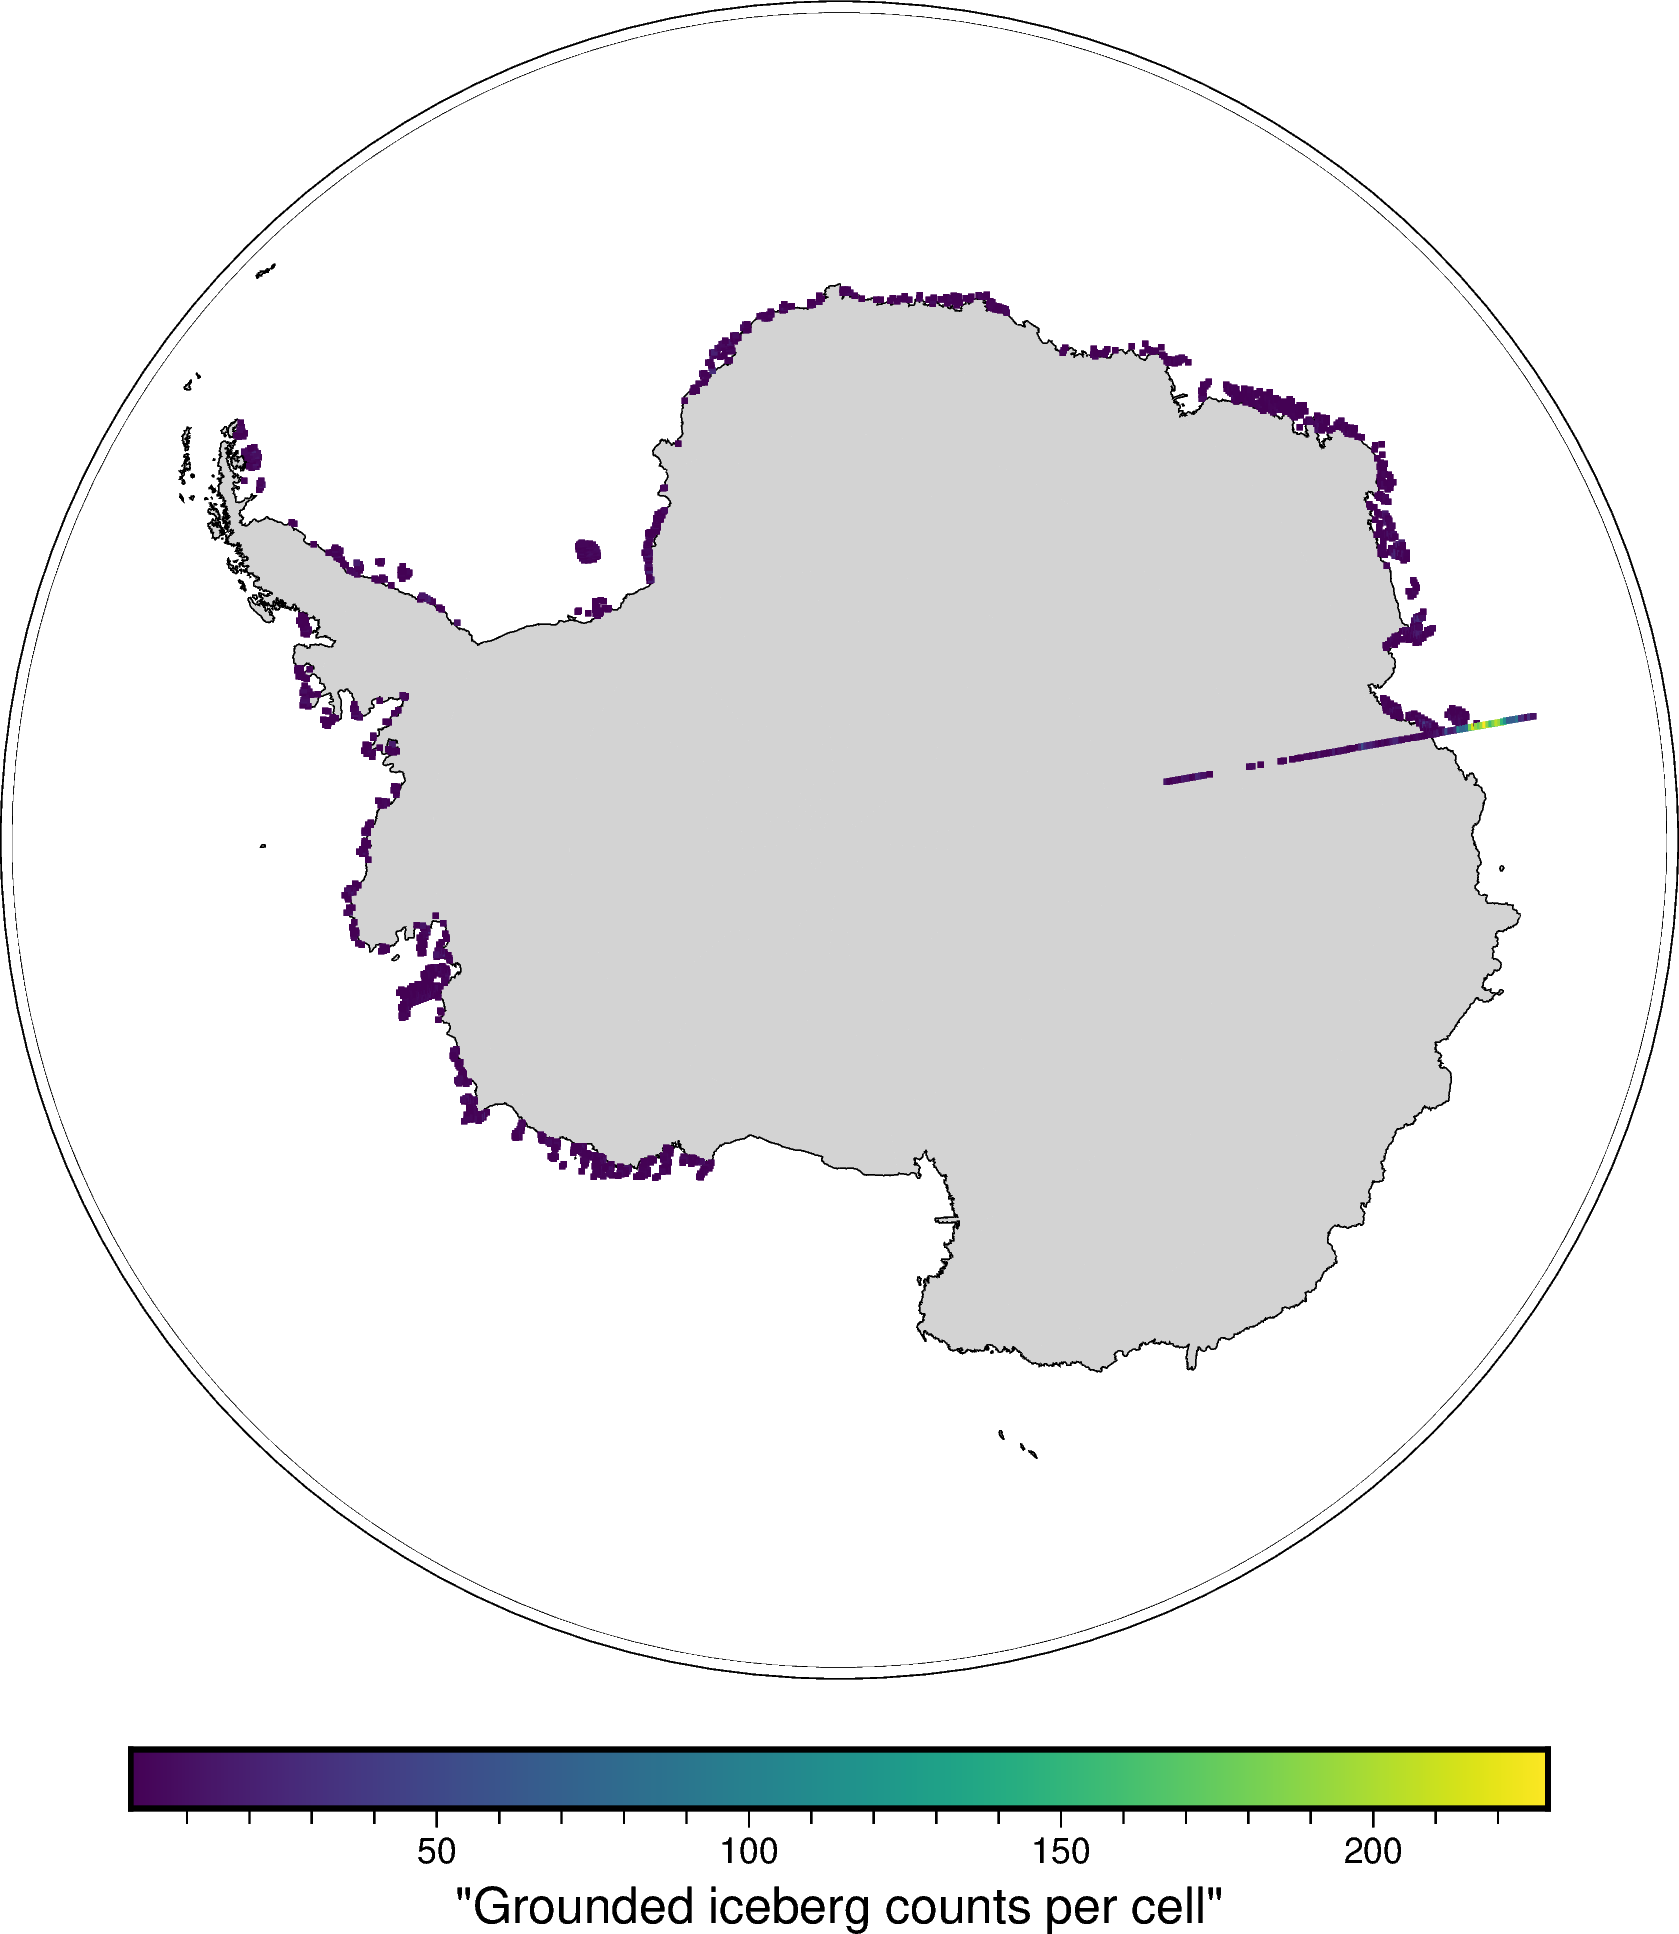

In [ ]:
fig = pygmt.Figure()
fig.basemap(region=[-180,180,-90,-60], projection="S0/-90/14c", frame="g")
fig.coast(shorelines="0.25p,black", land="lightgray", water="white", resolution="i")
pygmt.makecpt(cmap="viridis", series=[1, 228])
fig.plot(x=lon_flat, y=lat_flat, style="s0.07c", fill=GI_cnts, cmap=True)
fig.colorbar(position="JBC+w12c/0.5c+o0/0.7c", frame='af+l"Grounded iceberg counts per cell"')
fig.show()

## Fast Ice Classification Method Comparison

In [ ]:
files = sorted(glob.glob("/scratch/gv90/da1339/afim/methods_comp/elps-min/*.csv"))
CSV_GLOB = "/scratch/gv90/da1339/afim/methods_comp/elps-min/*.csv"
P_png = Path.home() / "graphical/AFIM/elps-min/FIA_pareto_bin_vs_roll_1994-1999_pygmt.png"

# --- Load & concat CSVs robustly (some files repeat headers) ---
dfs = []
for f in sorted(glob.glob(CSV_GLOB)):
    with open(f, "r") as fh:
        text = fh.read()
    chunks = [c for c in text.split("label,Bias,MAE,RMSE,SD_Model,Corr,SD_Obs,FIPSI,FIPmax") if c.strip()]
    for c in chunks:
        block = "label,Bias,MAE,RMSE,SD_Model,Corr,SD_Obs,FIPSI,FIPmax" + c
        dfs.append(pd.read_csv(io.StringIO(block)))
df = pd.concat(dfs, ignore_index=True)

# --- Parse label -> method, W, N ---
def parse_label(s):
    method = "bindays" if "bindays" in s else ("rollmean" if "rollmean" in s else "unknown")
    W = int(re.search(r"win(\d+)", s).group(1))
    mN = re.search(r"min(\d+)", s)
    N = int(mN.group(1)) if mN else np.nan
    return method, W, N

df[["method","W","N"]] = df["label"].apply(parse_label).apply(pd.Series)
df["abs_bias"] = df["Bias"].abs()

# --- Pareto frontier on (RMSE↓, 1-Corr↓, |Bias|↓) ---
A = np.c_[df["RMSE"].values, 1.0 - df["Corr"].values, df["abs_bias"].values]
dom = np.zeros(len(A), dtype=bool)
for i in range(len(A)):
    if dom[i]:
        continue
    for j in range(len(A)):
        if i == j:
            continue
        if np.all(A[j] <= A[i]) and np.any(A[j] < A[i]):
            dom[i] = True
            break
df["pareto"] = ~dom

# --- Short labels for sparse annotation ---
def short(row):
    if row["method"]=="bindays" and not math.isnan(row["N"]):
        return f"B W{int(row['W'])}/N{int(row['N'])}"
    if row["method"]=="rollmean":
        return f"R W{int(row['W'])}"
    return row["label"]
df["short"] = df.apply(short, axis=1)

# Annotate only: all Pareto + (B W10/N8, B W11/N9, B W12/N10, R W11)
want = df["pareto"].copy()
for tup in [("bindays",10,8),("bindays",11,9),("bindays",12,10)]:
    want |= (df["method"].eq(tup[0]) & df["W"].eq(tup[1]) & df["N"].eq(tup[2]))
want |= (df["method"].eq("rollmean") & df["W"].eq(11))

# --- Plot with PyGMT ---
fig = pygmt.Figure()
x = df["RMSE"].to_numpy()
y = df["Corr"].to_numpy()
size = 0.045 + 0.0012*df["abs_bias"].to_numpy()  # inches; tweak to taste

xmin, xmax = float(x.min())-5, float(x.max())+5
ymin, ymax = max(0, float(y.min())-0.05), min(1.0, float(y.max())+0.05)
fig.basemap(region=[xmin,130,0.5,ymax], projection="X12c/8c",
            frame=["WSne", "xaf+lRMSE", "yaf+lCorrelation"])

# rolling-mean (squares)
mask = df["method"].eq("rollmean")
fig.plot(x=x[mask], y=y[mask], style="s", size=size[mask]+0.2, pen="0.1p,black", fill="#DEC24E")

# binary-days (circles)
mask = df["method"].eq("bindays")
fig.plot(x=x[mask], y=y[mask], style="c", size=size[mask]+0.2, pen="0.1p,black", fill="#5596E0")

# Pareto ring (thicker outline)
# mask = df["pareto"].to_numpy()
# fig.plot(x=x[mask], y=y[mask], style="c", size=size[mask]+0.02, pen="0.8p,black")

# Sparse annotations
for _, r in df[want].iterrows():
    fig.text(text=r["short"], x=float(r["RMSE"]), y=float(r["Corr"]),
             font="8p,Helvetica,black", offset="0.12c/0.12c", justify="LM")

# Ticks/grid refinement
fig.basemap(frame=["xa20f10", "ya0.1f0.02"])

# Legend stubs (optional)
#fig.legend(position="JBL+jBL+o0.3c", box="+gwhite+p0.25p")
fig.show()
fig.savefig(P_png, dpi=300)
print("Wrote FIA_pareto_bin_vs_roll_1994-1999_pygmt.png")

## Justification for Ice Speed Threshold

In [ ]:
SIM        = "elps-min"
ARCH       = Path("/home/581/da1339/AFIM_archive") / SIM / "zarr"
MET_BIN    = "FI_BT_bin_mets.zarr"
MET_ROLL   = "FI_BT_roll_mets.zarr" 
VAR_MAX    = "FIA_Maximum Mean"
VAR_MIN    = "FIA_Minimum Mean"
T_LIST     = [1.0e-6, 3.0e-6, 5.0e-6, 7.0e-6, 9.0e-6,
              1.0e-5, 3.0e-5, 5.0e-5, 7.0e-5, 9.0e-5,
              1.0e-4, 3.0e-4, 5.0e-4, 7.0e-4, 9.0e-4,
              1.0e-3, 3.0e-3, 5.0e-3, 7.0e-3, 9.0e-3,
              1.0e-2, 3.0e-2, 5.0e-2, 7.0e-2, 9.0e-2]
OBS_MIN    = 221
OBS_MAX    = 601
BETA_MAIN  = 5.0e-4
BETA_ANNOT = None
YMIN, YMAX = 60, 1000
OUTPNG     = Path.home() / "graphical/AFIM" / SIM / "ispd-thresh_vs_FIA-min-max_pygmt.png"
DEBUG_LIST_FIRST = True  # set False to silence var listing

In [ ]:
# --------------------------------
def find_threshold_dirs(arch_root: Path, metric_dirname: str):
    """Return sorted list of (t_value, metric_path) that actually exist."""
    dirs = []
    for p in arch_root.glob("ispd_thresh_*"):
        m = re.search(r"ispd_thresh_([0-9.]+e[+-]?\d+)", p.name)
        if not m:
            continue
        t = float(m.group(1))
        metric_path = p / metric_dirname
        if metric_path.is_dir():
            dirs.append((t, metric_path))
    # sort by threshold
    dirs.sort(key=lambda x: x[0])
    return dirs

def read_scalar_component(metric_path: Path, varname: str) -> float:
    """
    Read a scalar metric when the layout is:
      <...>/<metric>.zarr/<varname>/
    and <varname> is a *Zarr array store* (has .zarray, .zattrs, chunk files).
    """
    comp = metric_path / varname
    if not comp.is_dir():
        raise FileNotFoundError(f"Missing variable dir: {comp}")
    arr = zarr.open(zarr.DirectoryStore(str(comp)), mode="r")   # <-- Zarr array
    return float(np.array(arr)[...].ravel()[0])

def read_scalar_any(metric_path: Path, varname: str) -> float:
    """
    First try opening the metric root as an xarray Dataset (vars with spaces work),
    else fall back to reading the component as a raw Zarr array.
    """
    try:
        ds = xr.open_zarr(metric_path, consolidated=False)
        return float(np.array(ds[varname]).ravel()[0])
    except Exception:
        return read_scalar_component(metric_path, varname)

def collect_series(arch_root: Path, metric_dirname: str):
    t_vals, v_max, v_min, fails = [], [], [], []
    for t, mpath in find_threshold_dirs(arch_root, metric_dirname):
        try:
            vmax = read_scalar_any(mpath, VAR_MAX)
            vmin = read_scalar_any(mpath, VAR_MIN)
            t_vals.append(t); v_max.append(vmax); v_min.append(vmin)
        except Exception as e:
            fails.append((t, str(e).splitlines()[0]))
    return (np.array(t_vals), np.array(v_max), np.array(v_min), fails)

In [ ]:
t_bin, max_bin, min_bin, fail_bin = collect_series(ARCH, MET_BIN)
t_roll = max_roll = min_roll = np.array([])
fail_roll = []
if MET_ROLL:
    t_roll, max_roll, min_roll, fail_roll = collect_series(ARCH, MET_ROLL)
if t_bin.size == 0 and t_roll.size == 0:
    msg = ["No data read. Sample failures:"]
    msg += [f"  BIN  t={t:.1e}: {r}" for t, r in fail_bin[:5]]
    msg += [f"  ROLL t={t:.1e}: {r}" for t, r in fail_roll[:5]]
    raise RuntimeError("\n".join(msg))

In [ ]:
fig        = pygmt.Figure()
x_all      = np.r_[t_bin, t_roll] if t_roll.size else t_bin
xmin, xmax = float(x_all.min()), float(x_all.max())
fig.basemap(region     = [0, 0.001, YMIN, 800], 
            projection = "X16c/10c",
            frame      = ['WSen',
                          'xaf+l@[\\mathrm{Ice}\\ \\mathrm{Speed}\\ \\mathrm{Threshold}\\ (m/s)@[',
                          'yaf+l@[\\mathrm{Fast}\\ \\mathrm{Ice}\\ \\mathrm{Area}\\ (1\\times10^3-\\mathrm{km}^2)@['])
# AF2020 bounds
fig.plot(x=[xmin, xmax], y=[OBS_MIN, OBS_MIN], pen="1p,black,4_2:2p")
fig.plot(x=[xmin, xmax], y=[OBS_MAX, OBS_MAX], pen="1p,black,4_2:2p")
# binary-day
if t_bin.size:
    fig.plot(x=t_bin, y=min_bin, pen="1.5p,royalblue", label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\mathrm{bin}}\\ \\textsc{(FIA-min)}@[")
    fig.plot(x=t_bin, y=max_bin, pen="1.5p,gold",      label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\matchrm{bin}}\\ \\textsc{(FIA-max)}@[")
# rolling
if t_roll.size:
    fig.plot(x=t_roll, y=min_roll, pen="1.5p,forestgreen", label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\matchrm{roll}}\\ \\textsc{(FIA-min)}@[")
    fig.plot(x=t_roll, y=max_roll, pen="1.5p,red",         label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\matchrm{roll}}\\ \\textsc{(FIA-max)}@[")
# verticals
fig.plot(x=[4.0e-4,4.0e-4], y=[500, 700], pen="1p,gold,-")
fig.plot(x=[1.9e-4,1.9e-4], y=[100, 300], pen="1p,royalblue,-")
fig.plot(x=[3.4e-4,3.4e-4], y=[100, 300], pen="1p,forestgreen,-")
fig.plot(x=[6.5e-4,6.5e-4], y=[500, 700], pen="1p,red,-")
fig.plot(x=[5.0e-4,5.0e-4], y=[60, 800], pen="1p,grey,-")          #JF (default)
fig.legend(position="JTL+jTL+o0.4c/0.4c+w4.5c", box="+gwhite+p0.5p", transparency=10)
fig.show()
fig.savefig(OUTPNG, dpi=300)
print(f"Wrote {OUTPNG}")

## binary-day or rolling-mean?

+ create a dictionary of circumpolar fast ice area time series for one simulation (``elps-min``) for a range of different ``binary-day`` and ``rolling-mean`` configurations
+ calculate relevant statistical skills for each configuration against fast ice area observations (``AF2020``)
+ come up with a metric (normalisation-score) for determining the best performing configuration

### How to run the cells in this section:

+ the first cell is meant to provide the rationale for why the comparison should be done (it does assume that the user knows the ``F2020`` fortnightly-climatological "shape" of the plot)
+ the second cell below runs the main analysis script in a small test case

However, to run the main analysis script as intended (to regenerate the figure results) then:
```
cd ~/AFIM/src/AFIM/scripts/classification/
qsub -J 7-16 FI_classify_methods_comparison.pbs
qsub -J 17-20 FI_classify_methods_comparison.pbs
qsub -J 1 -v MERGE=1 -W ./FI_classify_methods_comparison.pbs
```

Batch jobs can be monitored using:
```
qstat -t NNNNNNNNNN[].gadi-pbs
```

In [ ]:
FIA_dict    = {}
vars_load   = ['aice','tarea','hi']
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1994-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name,
                                      dt0_str  = dt0_str,
                                      dtN_str  = dtN_str,
                                      ice_speed_threshold = 5e-4)
_, FI_bin_dsA, FI_roll_ds = SI_tools.classify_fast_ice(bin_win_days         = 7,
                                                      bin_min_days          = 5,
                                                      enable_rolling_output = True,
                                                      roll_win_days         = 7)
_, FI_bin_dsB, FI_roll_ds = SI_tools.classify_fast_ice(bin_win_days         = 7,
                                                      bin_min_days          = 7,
                                                      enable_rolling_output = True,
                                                      roll_win_days         = 7)
CICE_SO       = SI_tools.load_cice_zarr(slice_hem=True, variables=['aice','tarea'], dt0_str = "1994-01-01", dtN_str = "1994-12-31",)
FI_bin_maskA  = FI_bin_dsA["FI_mask"] > 0
FI_bin_maskB  = FI_bin_dsB["FI_mask"] > 0
FI_roll_mask  = FI_roll_ds["FI_mask"] > 0 
# 1) Compute masks locally so no graph is serialized
with dask.config.set(scheduler="single-threaded"):
    FI_bin_maskA_c = FI_bin_dsA["FI_mask"].astype("bool").compute()
    FI_bin_maskB_c = FI_bin_dsB["FI_mask"].astype("bool").compute()
    FI_roll_mask_c = FI_roll_ds["FI_mask"].astype("bool").compute()
# 2) Now do the masking and area with local compute as well (or re-chunk afterwards)
with dask.config.set(scheduler="single-threaded"):
    aice_binA  = CICE_SO["aice"].where(FI_bin_maskA_c).compute()
    area_binA  = CICE_SO["tarea"].where(FI_bin_maskA_c).compute()
    aice_binB  = CICE_SO["aice"].where(FI_bin_maskB_c).compute()
    area_binB  = CICE_SO["tarea"].where(FI_bin_maskB_c).compute()
    aice_roll  = CICE_SO["aice"].where(FI_roll_mask_c).compute()
    area_roll  = CICE_SO["tarea"].where(FI_roll_mask_c).compute()
spat = SI_tools.CICE_dict["spatial_dims"]
FIA_binA = (aice_binA * area_binA).sum(dim=spat).rename("FIA")/1e9
FIA_binB = (aice_binB * area_binB).sum(dim=spat).rename("FIA")/1e9
FIA_roll = (aice_roll * area_roll).sum(dim=spat).rename("FIA")/1e9
plt.rcParams['font.family'] = 'Courier New'
fig, ax = plt.subplots(figsize=(9,4))
# overlay on same axis with distinct styles
FIA_binA.plot(ax=ax, label=r'bin-days  : 5/7-days', color='tab:blue'  , linewidth=1.8)
FIA_binB.plot(ax=ax, label=r'bin-days  : 7/7-days', color='tab:orange', linewidth=1.8)
FIA_roll.plot(ax=ax, label=r'roll-mean : 7-days'  , color='tab:green' , linewidth=1.8)
ax.set_title('FIA classification method comparison')
ax.set_ylabel('FIA (10^3 km^2)')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()

In [ ]:
from pathlib import Path
import os, getpass, subprocess

WIN       = 9
CNT_SPAN  = 3
SIM_NAME  = "elps-min"
DT0       = "1994-01-01"
DTN       = "1995-12-31"
ISPD_THR  = "5e-4"

USER   = getpass.getuser()
OUTDIR = Path(f"/scratch/gv90/{USER}/afim/methods_comp/elps-min_test")
OUTDIR.mkdir(parents=True, exist_ok=True)
os.environ["DASK_TEMPORARY_DIRECTORY"] = str(OUTDIR / "dask-tmp")
Path(os.environ["DASK_TEMPORARY_DIRECTORY"]).mkdir(parents=True, exist_ok=True)

SCRIPT = str(Path.home() / "AFIM/src/AFIM/scripts/classification/FI_classify_methods_comparison.py")
cmd    = ["python", "-u", SCRIPT, 
          "--sim-name", SIM_NAME,
           "--dt0", DT0, 
           "--dtN", DTN,
           "--ispd", ISPD_THR,
           "--win", str(WIN),
           "--min-days-span", str(CNT_SPAN),
           "--out-dir", str(OUTDIR),]
print("Running:", " ".join(cmd))
res = subprocess.run(cmd)
if res.returncode != 0:
    raise RuntimeError(f"Driver exited with code {res.returncode}")

print("Wrote:", OUTDIR / f"metrics_win{WIN:02d}.csv")

In [ ]:
FIA_dict   = {}
FIV_dict   = {}
sim_name   = "elps-min"
dt0_str    = "1994-01-01"
dtN_str    = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name,
                                      dt0_str  = dt0_str,
                                      dtN_str  = dtN_str)
FI_raw, CICE = SI_tools.load_processed_cice( zarr_CICE = True )

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34659 instead
  warnings.warn(
2025-09-15 12:31:07,131 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-09-15 12:31:07,153 - INFO - Dask Client Connected
  Dashboard      : /proxy/34659/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-09-15 12:31:07,154 - INFO - hemisphere initialised: SH
2025-09-15 12:31:07,157 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-15 12:31:07,180 - INFO -  self.ice_class defined as FI_BT
2025-09-15 12:31:07,181 - INFO - --- SeaIceToolbox Summary ---
2025-09-15 12:31:07,183 - INFO - Simulation Name     : elps-min
2025-09-15 12:31:07,184 - INFO - An

#### compute binary-days 
+ this will be binary-days for 7 out of 7, 6 out of 7, 5 out of 7, 8 out of 8, 7 out of 8, 6 out of 8, and so on, until 13 out of 15.
  

In [ ]:
CICE_SO = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
for win in np.arange(7, 16):  # window sizes: 7 to 15 inclusive
    for cnt in np.arange(win, win - 3, -1):  # max, max-1, max-2 (e.g., 7,6,5)
        key_name = f"elps-min_bin-day_{cnt}of{win}"
        FI_bool               = SI_tools.boolean_fast_ice(FI_raw['FI_mask'], window=win, min_count=cnt)
        aice_bool             = CICE_SO['aice'].where(FI_bool)
        hi_bool               = CICE_SO['hi'].where(FI_bool)
        tarea_bool            = CICE_SO['tarea'].where(FI_bool)
        #P_bool                = CICE_SO['strength'].where(FI_bool)
        #divu_bool             = CICE_SO['divu'].where(FI_bool)
        #dvidtt_bool           = CICE_SO['dvidtt'].where(FI_bool)
        FIA_dict[key_name]    = SI_tools.compute_ice_area(FI_bool, tarea_bool)
        FIV_dict[key_name]    = SI_tools.compute_ice_volume(FI_bool, hi_bool, tarea_bool)
        #P_dict[key_name]      = P_bool.sum(dim=('nj','ni'))
        #divu_dict[key_name]   = divu_bool.sum(dim=('nj','ni'))
        #dvidtt_dict[key_name] = dvidtt_bool.sum(dim=('nj','ni'))

#### compute rolling-mean

+ this will be rolling-means over 7, 10, 13, 16 and 19 day periods
+ then compute FIA on each of those

In [ ]:
for i in np.arange(7,20,3):
    roll_name  = f"elps-min_roll-day_{i:d}"
    CICE_rolls = SI_tools.process_rolling_cice(sim_name         = sim_name,
                                               dt0_str          = dt0_str,
                                               dtN_str          = dtN_str,
                                               mean_period      = i,
                                               ivec_type        = "BT",
                                               write_zarr_group = False)
    FIA_dict[roll_name]    = SI_tools.compute_ice_area(CICE_rolls['FI_mask'], CICE_rolls['tarea'])
    FIV_dict[roll_name]    = SI_tools.compute_ice_volume(CICE_rolls['FI_mask'], CICE_rolls['hi'], CICE_rolls['tarea'])
    #P_FI_roll              = CICE_rolls['strength'].where(CICE_rolls['FI_mask'])
    #divu_FI_roll           = CICE_rolls['divu'].where(CICE_rolls['FI_mask'])
    #dvidtt_FI_roll         = CICE_rolls['dvidtt'].where(CICE_rolls['FI_mask'])
    #P_dict[roll_name]      = P_FI_roll.sum(dim=('nj','ni'))
    #divu_dict[roll_name]   = divu_FI_roll.sum(dim=('nj','ni'))
    #dvidtt_dict[roll_name] = dvidtt_FI_roll.sum(dim=('nj','ni'))

#### compute statistics for each configuration

In [ ]:
# ts_ds     = SI_tools.dict_to_ds(FIA_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FIA_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(FIV_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FIV_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(P_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-strength_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(divu_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-strain-rate_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(dvidtt_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-thermo-vol-tend_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
AF_clim = SI_tools.load_AF2020_FIA_summary(start="1994-01-01", end="1999-12-31")
obs_fia = SI_tools.AF2020_clim_to_model_time( FIA_dict['elps-min_bin-day_7of7'] , AF_clim["FIA_clim"].sel(region="circumpolar"))
FIA_stats = {}
for key in FIA_dict.keys():
    print(key)
    FIA_stats[key] = SI_tools.compute_skill_statistics( FIA_dict[key], obs_fia )

#### compute a normalised-score to rank the configurations

In [ ]:
df['Abs_Bias'] = np.abs(df['Bias'])
df['SD_Diff']  = np.abs(df['SD_Model'] - df['SD_Obs'])
df['score']    = (df['Abs_Bias'] / df['Abs_Bias'].max() +
                   df['RMSE']     / df['RMSE'].max() +
                   df['MAE']      / df['MAE'].max() +
                   df['SD_Diff']  / df['SD_Diff'].max() +
                   (1 - df['Corr']) / (1 - df['Corr'].min()))
best_method    = df['score'].idxmin()
df_sorted      = df.sort_values(by='score')
print("Best-aligned method with observed FIA:", best_method)
df_sorted[['Bias', 'RMSE', 'MAE', 'Corr', 'SD_Model', 'SD_Obs']].head(5)

#### Taylor Diagram

In [ ]:
def plot_taylor_nonlinear_zoom(stats_dict, color_metric="Bias", corr_lims=(0.4, 0.1), std_lims=(0.75, 1.0)):
    def nonlinear_theta(corr, exponent=0.5):
        corr = np.clip(corr, 0, 1)
        linear_angle = np.arccos(corr)
        return np.power(linear_angle / np.pi, exponent) * np.pi
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(-1)
    # Colormap with centered zero
    color_vals = np.array([v[color_metric] for v in stats_dict.values()])
    vmin, vmax = color_vals.min(), color_vals.max()
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap = cm.RdBu_r
    # Set zoomed radial and angular limits
    ax.set_rmin(std_lims[0])
    ax.set_rmax(std_lims[1])
    ax.set_rticks(np.round(np.linspace(*std_lims, 3), 2))
    ax.set_rlabel_position(135)
    corr_min, corr_max = corr_lims
    tick_corrs = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    tick_angles = [np.degrees(nonlinear_theta(c)) for c in tick_corrs]
    ax.set_thetamin(min(tick_angles))
    ax.set_thetamax(max(tick_angles))
    ax.set_thetagrids(tick_angles, labels=[f"{c:.2f}" for c in tick_corrs])
    # Reference std circle at r = 1
    ref_theta = np.linspace(0, np.pi, 500)
    ax.plot(nonlinear_theta(np.cos(ref_theta)), np.ones_like(ref_theta), 'k-', lw=1.2)
    # RMSD arcs
    ref_std = list(stats_dict.values())[0]['SD_Obs']
    rs = np.linspace(std_lims[0], std_lims[1], 400)
    rms_levels = [20, 50, 100]
    for rms in rms_levels:
        rms_norm = rms / ref_std
        theta = np.arccos(np.clip((1 + rs**2 - rms_norm**2) / (2 * rs), -1, 1))
        scaled_theta = nonlinear_theta(np.cos(theta))
        valid = (scaled_theta >= np.radians(ax.get_thetamin())) & (scaled_theta <= np.radians(ax.get_thetamax()))
        ax.plot(scaled_theta[valid], rs[valid], '--', color='lightgray', lw=0.8)
        if np.any(valid):
            label_theta = scaled_theta[valid][5]
            label_r = rs[valid][5] + 0.01
            ax.text(label_theta, label_r, f'RMSE={rms}', fontsize=7, color='gray')

    # Plot data points with external annotations and arrows
    for i, (label, stat) in enumerate(stats_dict.items()):
        corr = np.clip(stat["Corr"], 0, 1)
        std_ratio = stat["SD_Model"] / stat["SD_Obs"]
        angle = nonlinear_theta(corr)
        r = std_ratio
        color = cmap(norm(stat[color_metric]))
        ax.plot(angle, r, 'o', markersize=6, color=color)
        # Offset annotation radially outward
        r_annot = r + 0.05
        ax.annotate(label,
            xy=(angle, r),
            xytext=(angle*0.9, r_annot),
            textcoords='data',
            ha='center', va='center',
            fontsize=8,
            arrowprops=dict(arrowstyle="->", color="gray", lw=0.7)
        )

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.2, orientation="horizontal", shrink=0.75)
    cbar.set_label(f"{color_metric} (m/s)")
    
    plt.tight_layout()
    plt.show()

In [ ]:
sim_name   = "elps-min"
SI_tools   = SeaIceToolbox( sim_name = sim_name )
AF2020_CSV = SI_tools.load_AF2020_FIA_summary()
obs_FIA    = AF2020_CSV['FIA_clim_repeat'].sel(region='circumpolar')
FIA_sim    = xr.open_zarr(Path(Path.home(),"AFIM_archive","elps-min","FIA_time-series_multi-bin-days_multi-roll-days.zarr"))
dt         = pd.to_datetime(FIA_sim["time"].values)
valid_dt   = dt.year > 1993 
FIA_sim    = FIA_sim.sel(time=valid_dt)
print(FIA_sim.time.values)

In [ ]:
AF_clim = SI_tools.load_AF2020_FIA_summary(start="1994-01-01", end="1999-12-31")
obs_fia = SI_tools.AF2020_clim_to_model_time( FIA_sim['elps-min_bin-day_7of7'] , AF_clim["FIA_clim"].sel(region="circumpolar"))
FIA_stats = {}
for key in FIA_sim.keys():
    print(key)
    FIA_stats[key] = SI_tools.compute_skill_statistics( FIA_sim[key], obs_fia )

In [ ]:
# import json
# with open("/g/data/gv90/da1339/afim_output/elps-min/FIA_skill_statistics_1994-1999.json", "w") as f:
#     json.dump(FIA_stats, f, indent=2)
#plot_taylor(FIA_stats)
plot_taylor_nonlinear_zoom(FIA_stats,color_metric="Bias",std_lims=(0.8, 1))

In [ ]:
FIA_dict = {"AF2020"                  : obs_FIA,
            "elps-min_bin-day_13of15"  : FIA_sim['elps-min_bin-day_13of15'],
            "elps-min_bin-day_14of15" : FIA_sim['elps-min_bin-day_14of15'],
            "elps-min_bin-day_15of15" : FIA_sim['elps-min_bin-day_15of15'],
            "elps-min_roll-day_16"    : FIA_sim['elps-min_roll-day_16']}
SI_tools.plot_timeseries_matplotlib(FIA_dict,
                        ylabel    = "Fast Ice Area (1000-km²)",
                        P_png     = Path(SI_tools.D_graph,"timeseries","FIA_elps-min_bin-day_comparison_15day.png"))
SI_tools.plot_monthly_ice_metric_by_year(FIA_dict,
                                        ice_type         = "FIA",
                                        figsize          = (18, 10),
                                        P_png            = Path(SI_tools.D_graph,sim_name,"FIA_elps-min_bin-day_comparison_15day_by_doy.png"),
                                        plot_annotations = False)

#
---------------------

# ACCESS-OM2-025-ERA5 sea ice data 
**needs only to be run once, after which data can be extracted from local zarr files**
+ this uses [ACCESS-NRI intake catalog](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html) through a ``SeaIceToolbox`` method ``load_ACCESS_OM_CICE``

In [ ]:
dt0_str        = "2000-01-01"
dtN_str        = "2023-12-31"
dt_rng_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type       = "FI_BT"
SIA_dict       = {}
FIA_dict       = {}
SI_tools       = SeaIceToolbox(sim_name             = "AOM2-ERA5",
                               dt0_str              = dt0_str,
                               dtN_str              = dtN_str,
                               ice_speed_threshold  = 5e-4,
                               ice_speed_type       = "BT",
                               ice_type             = "FI_BT",
                               overwrite_zarr       = False,
                               save_new_figs        = True,
                               show_figs            = True,
                               overwrite_saved_figs = True)

## load ACCESS-OM-025-ERA5 data from ESM datastore then convert to zarr files for easy of use later
+ loading and saving only needs to be done if it has not been done previously
+ running both of these cells takes approximately an hour with the bottleneck at writing to zarr

In [ ]:
AOM2 = SI_tools.load_ACCESS_OM_CICE()

In [ ]:
SI_tools.write_ACCESS_to_monthly_zarr(AOM2)

## run ACCESS-OM-025-ERA5 through fast ice classification workflow
+ this is a quick process and will save masked zarr dataset

In [ ]:
AOM2_FI_raw = SI_tools.process_daily_cice(ispd_thresh=5e-4,
                                          ivec_type="BT",
                                          overwrite_zarr_group=True)

In [ ]:
AOM2_FI_roll = SI_tools.process_rolling_cice(ispd_thresh=5e-4,
                                             ivec_type="BT",
                                             overwrite_zarr_group=True)

### Seasonality and inter-annual variability

In [ ]:
sim_name            = "elps-min"
SI_tools            = SeaIceToolbox(sim_name = sim_name)
FI_mets             = xr.open_dataset(Path(SI_tools.D_zarr,"ispd_thresh_5.0e-4","metrics","FI_BT_bool_mets.zarr"))
FIA_obs             = SI_tools.load_AF2020_FI_area_timeseries()
FIA_dict            = {}
FIA_dict['FIA_obs'] = FIA_obs
FIA_dict['FIA_sim'] = FI_mets['FIA']
FIA_obs_df          = FIA_dict['FIA_obs']  # pandas DataFrame
FIA_sim             = FIA_dict['FIA_sim']  # xarray DataArray with .time and daily frequency
obs_daily_list      = []
for year in FIA_obs_df['Year'].unique():
    subset     = FIA_obs_df[FIA_obs_df['Year'] == year]
    doys       = ((subset['DOY_start'] + subset['DOY_end']) // 2).values
    dates      = pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(doys - 1, unit='D')
    ts         = pd.Series(subset['circumpolar'].values, index=dates)
    full_range = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='D')
    ts_daily   = ts.reindex(full_range).interpolate("linear").ffill().bfill()
    obs_daily_list.append(ts_daily)
FIA_obs_daily   = pd.concat(obs_daily_list).sort_index()
sim_dates       = pd.to_datetime(FIA_sim['time'].values)
FIA_obs_aligned = FIA_obs_daily.reindex(sim_dates).interpolate("linear").ffill().bfill()
FIA_obs_aligned = FIA_obs_aligned/1e3
FIA_sim_smooth  = FIA_sim.rolling(time=15, center=True).mean()
FIA_diff_norm   = (FIA_obs_aligned - FIA_sim_smooth) / FIA_obs_aligned 
fig, ax1        = plt.subplots(figsize=(20, 12))
ax1.plot(sim_dates, FIA_sim_smooth, label="model (CICE6-standalone)", color='blue', linewidth=1)
ax1.plot(sim_dates, FIA_obs_aligned, label="observed", color='black', linestyle='--')
ax1.tick_params(size=14, axis='y', labelcolor='black')
ax2 = ax1.twinx()
ax2.plot(sim_dates, FIA_diff_norm, label="(Obs - Sim) / Obs [%]", color='gray', alpha=0.5)
ax2.tick_params(size=14, axis='y', labelcolor='gray')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title("Circumpolar Antarctic Fast Ice Area 2000-2018: Observations vs Model", fontsize=20)
ax1.set_ylabel("Area (1000 km²)", fontsize=18)
ax2.set_ylabel("Relative Difference (%)", color='gray', fontsize=18)
ax1.set_xlabel("Date", fontsize=18)
ax1.set_ylim([100, 800])
ax2.set_ylim([-1,1])
ax1.set_xlim(pd.Timestamp("2000-03-01"), pd.Timestamp("2018-03-01"))
plt.tight_layout()
plt.show()
results = []
for year in range(2000, 2019):
    t0 = pd.Timestamp(f"{year}-01-01")
    tN = pd.Timestamp(f"{year}-12-31")
    sim_year = FIA_sim_smooth.sel(time=slice(t0, tN)).to_series()
    obs_year = FIA_obs_aligned.loc[t0:tN]
    sim_year = sim_year.dropna()
    obs_year = obs_year.dropna()
    if len(sim_year) == 0 or len(obs_year) == 0:
        continue
    sim_min_val    = sim_year.min()
    sim_min_day    = sim_year.idxmin()
    sim_max_val    = sim_year.max()
    sim_max_day    = sim_year.idxmax()
    obs_min_val    = obs_year.min()
    obs_min_day    = obs_year.idxmin()
    obs_max_val    = obs_year.max()
    obs_max_day    = obs_year.idxmax()
    delta_min_mag  = sim_min_val - obs_min_val
    delta_min_time = (sim_min_day - obs_min_day).days
    delta_max_mag  = sim_max_val - obs_max_val
    delta_max_time = (sim_max_day - obs_max_day).days
    results.append({"year"     : year,
                    "sim_min"  : sim_min_val,
                    "obs_min"  : obs_min_val,
                    "Δmin_mag" : delta_min_mag,
                    "Δmin_day" : delta_min_time,
                    "sim_max"  : sim_max_val,
                    "obs_max"  : obs_max_val,
                    "Δmax_mag" : delta_max_mag,
                    "Δmax_day" : delta_max_time})
comparison_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_mag'], label='Δmin_mag (Obs - Sim)', color='steelblue')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_mag'], label='Δmax_mag (Obs - Sim)', color='coral')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Magnitude (km²)")
ax.set_title("Observed - Model Min/Max FIA Magnitude per Year")
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_day'], label='Δmin_day (days)', color='slategray')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_day'], label='Δmax_day (days)', color='darkorange')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Timing (days)")
ax.set_title("Observed - Model Timing of Min/Max FIA per Year")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


# Is there a relationship between sea ice speed threshold and fast ice area?

In [48]:

# Assumes your SeaIceToolboxManager + toolbox loader are already available
# from your environment
# from your_pkg import SeaIceToolboxManager

def _get_scalar(ds, name, default=np.nan):
    """Safely fetch a scalar from an xarray.Dataset (variable can be 0-D or length-1)."""
    if name not in ds:
        return default
    v = ds[name]
    try:
        # 0-D (scalar) or length-1
        return float(v.values) if np.size(v.values) == 1 else float(v.values.squeeze())
    except Exception:
        return default

def load_metrics_for_experiment(sim_name, dt0_str, dtN_str, P_log=None):
    """Load the computed metrics (mets) dataset for one experiment."""
    SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
    SI_tools    = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
    mets        = SI_tools.load_computed_metrics(ice_type="FI_BT")
    return mets

def build_fia_skill_table(
    experiments,
    dt0_str="1994-01-01",
    dtN_str="1999-12-31",
    P_log=None,
    round_map=None
):
    """
    For each experiment in `experiments`, load `mets` and extract:
      Bias, Corr, MAE, RMSE, SD_Model, SD_Obs,
      persistence_stability_index, persistence_max_distance, persistence_mean_distance,
      FIA_Maximum Mean, FIA_Minimum Mean, FIA_DOY Max Mean, FIA_DOY Min Mean.

    Returns
    -------
    df : pandas.DataFrame
        Tidy table ready for LaTeX.
    latex_str : str
        A LaTeX tabular environment (no surrounding table environment),
        matching column order and formatting.
    """
    cols = [
        ("Experiment", "experiment"),
        ("Bias", "Bias"),
        ("Corr", "Corr"),
        ("MAE", "MAE"),
        ("RMSE", "RMSE"),
        (r"SD\textsubscript{model}", "SD_Model"),
        (r"SD\textsubscript{obs}",   "SD_Obs"),
        (r"FIPSI",                   "persistence_stability_index"),
        (r"FIPmax (km)",             "persistence_max_distance"),
        (r"FIPmean (km)",            "persistence_mean_distance"),
        (r"FIA\_Maximum Mean",       "FIA_Maximum Mean"),
        (r"FIA\_Minimum Mean",       "FIA_Minimum Mean"),
        (r"FIA\_DOY Max Mean",       "FIA_DOY Max Mean"),
        (r"FIA\_DOY Min Mean",       "FIA_DOY Min Mean"),
    ]

    rows = []
    for sim_name in experiments:
        mets = load_metrics_for_experiment(sim_name, dt0_str, dtN_str, P_log=P_log)

        row = {"experiment": sim_name}
        # Pull scalars
        row["Bias"]  = _get_scalar(mets, "Bias")
        row["Corr"]  = _get_scalar(mets, "Corr")
        row["MAE"]   = _get_scalar(mets, "MAE")
        row["RMSE"]  = _get_scalar(mets, "RMSE")

        row["SD_Model"] = _get_scalar(mets, "SD_Model")
        # SD_Obs appears to be scalar in mets; if not present, set to your known benchmark (e.g., 127)
        sd_obs_val = _get_scalar(mets, "SD_Obs")
        row["SD_Obs"] = sd_obs_val

        # Persistence metrics
        row["persistence_stability_index"] = _get_scalar(mets, "persistence_stability_index")
        row["persistence_max_distance"]    = _get_scalar(mets, "persistence_max_distance")
        row["persistence_mean_distance"]   = _get_scalar(mets, "persistence_mean_distance")

        # FIA summaries
        row["FIA_Maximum Mean"] = _get_scalar(mets, "FIA_Maximum Mean")
        row["FIA_Minimum Mean"] = _get_scalar(mets, "FIA_Minimum Mean")
        row["FIA_DOY Max Mean"] = _get_scalar(mets, "FIA_DOY Max Mean")
        row["FIA_DOY Min Mean"] = _get_scalar(mets, "FIA_DOY Min Mean")

        rows.append(row)

    df = pd.DataFrame(rows)

    # Order and rename columns for LaTeX
    latex_columns = [c[0] for c in cols]
    internal_keys = [c[1] for c in cols]
    df = df.rename(columns={"experiment": "Experiment"})  # to match label above
    df = df[ [ ("Experiment" if k=="experiment" else k) for k in internal_keys ] ]
    df.columns = latex_columns

    # Optional rounding for neatness
    if round_map is None:
        round_map = {
            "Bias": 1, "Corr": 3, "MAE": 1, "RMSE": 1,
            r"SD\textsubscript{model}": 1, r"SD\textsubscript{obs}": 0,
            "FIPSI": 3, "FIPmax (km)": 1, "FIPmean (km)": 1,
            "FIA\\_Maximum Mean": 1, "FIA\\_Minimum Mean": 1,
            "FIA\\_DOY Max Mean": 0, "FIA\\_DOY Min Mean": 0,
        }
    for col, ndig in round_map.items():
        if col in df.columns:
            df[col] = np.where(pd.notnull(df[col]), np.round(df[col].astype(float), ndig), df[col])

    # Build a LaTeX tabular (no outer table env) using siunitx S columns would be ideal,
    # but to keep it simple/robust here we’ll output a standard tabular string:
    col_fmt = "l" + "r"*(len(df.columns)-1)
    header = " & ".join(df.columns) + r" \\"
    lines  = [ " & ".join(map(str, r)) + r" \\" for r in df.values ]
    latex_str = (
        "\\begin{tabular}{" + col_fmt + "}\n\\toprule\n" +
        header + "\n\\midrule\n" +
        "\n".join(lines) + "\n\\bottomrule\n\\end{tabular}"
    )
    return df, latex_str

# --- Example usage (matching the experiments in your current table order) ---
experiments = [
    "elps-min","elps-ext","elps-mid","elps-max","FI-heavy","ry93",
    "Pstar-max","Pstar-min","Cstar-min","Cstar-max",
    "gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi",
    "ktens-max","ktens-min","ktens-nil","ktens-ext",
]
# Map these to your actual sim_name strings if they differ
df, latex_tab = build_fia_skill_table(experiments, dt0_str="1994-01-01", dtN_str="1999-12-31", P_log=Path.home()/ "logs/paper1_sandbox.log")
print(latex_tab)


2025-09-13 17:46:30,216 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-09-13 17:46:35,965 - INFO - Dask Client Connected
  Dashboard      : /proxy/42051/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-09-13 17:46:35,973 - INFO - hemisphere initialised: SH
2025-09-13 17:46:35,976 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-13 17:46:35,979 - INFO -  self.ice_class defined as FI_BT
2025-09-13 17:46:35,981 - INFO - --- SeaIceToolbox Summary ---
2025-09-13 17:46:35,982 - INFO - Simulation Name     : elps-min
2025-09-13 17:46:35,983 - INFO - Analysis Start Date : 1994-01-01
2025-09-13 17:46:35,984 - INFO - Analysis End Date   : 1999-12-31
2025-09-13 17:46:35,985 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-09-13 17:46:35,986 - INFO - Speed Type(s)       : BT
2025-09-13 17:46:35,987 - INFO - Ice 

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
Experiment & Bias & Corr & MAE & RMSE & SD\textsubscript{model} & SD\textsubscript{obs} & FIPSI & FIPmax (km) & FIPmean (km) & FIA\_Maximum Mean & FIA\_Minimum Mean & FIA\_DOY Max Mean & FIA\_DOY Min Mean \\
\midrule
elps-min & 20.4 & 0.849 & 58.8 & 70.4 & 101.8 & 127.0 & 0.185 & 67.2 & 10.8 & 646.5 & 255.7 & 293.0 & 76.0 \\
elps-ext & 71.5 & 0.912 & 72.2 & 89.0 & 106.7 & 127.0 & 0.204 & 62.1 & 10.8 & 694.4 & 289.3 & 281.0 & 72.0 \\
elps-mid & -69.8 & 0.837 & 83.5 & 99.9 & 89.6 & 127.0 & 0.15 & 57.6 & 9.4 & 538.7 & 194.8 & 290.0 & 76.0 \\
elps-max & -197.3 & 0.859 & 197.3 & 212.1 & 66.5 & 127.0 & 0.094 & 41.5 & 6.2 & 387.7 & 123.6 & 286.0 & 75.0 \\
FI-heavy & 158.0 & 0.778 & 158.0 & 177.1 & 106.1 & 127.0 & 0.275 & 54.3 & 10.3 & 776.4 & 378.2 & 327.0 & 77.0 \\
ry93 & -239.9 & 0.706 & 239.9 & 256.8 & 72.2 & 127.0 & 0.099 & 53.9 & 7.2 & 356.8 & 78.8 & 330.0 & 86.0 \\
Pstar-max & -95.2 & 0.918 & 95.2 & 109.2 & 98.5 & 127.0 & 0.137 & 41.5 & 7.3 & 522

---------------------------------------

# B-grid re-gridding comparison

In [ ]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1995-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str, list_of_composite_grids=['Tb'])
SI_tools.define_datetime_vars()

/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38807 instead
  warnings.warn(
2025-12-01 11:16:28,790 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-12-01 11:16:28,799 - INFO - Dask Client Connected
  Dashboard      : http://127.0.0.1:38807/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-12-01 11:16:28,800 - INFO - hemisphere initialised: SH
2025-12-01 11:16:28,801 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-12-01 11:16:28,824 - INFO -  self.ice_class defined as FI_BT
2025-12-01 11:16:28,827 - INFO - --- SeaIceToolbox Summary ---
2025-12-01 11:16:28,829 - INFO - Simulation Name     : elps-min
2025-12-01 11:16:28,830 - INFO - Analysis Start 

In [ ]:
for yr0_str, yrN_str in zip(SI_tools.yr0_strs, SI_tools.yrN_strs):
    yr_str = yr0_str[:4]
    print(f"looping over each month in year {yr_str}")
    SI_tools.define_datetime_vars(dt0_str=yr0_str, dtN_str=yrN_str)
    FI_mo, FI_bin_mo, FI_roll_mo, ispd_dy_mo, ispd_rl_mo = [], [], [], [], []
    for mo0_str, moN_str in zip(SI_tools.mo0_strs, SI_tools.moN_strs):
        FI_raw, FI_bin, FI_roll, ispds = SI_tools.classify_fast_ice(dt0_str=mo0_str, dtN_str=moN_str, enable_rolling_output=True)
        FI_mo.append(FI_raw)
        FI_bin_mo.append(FI_bin)
        FI_roll_mo.append(FI_roll)
        ispd_dy_mo.append(ispds['daily'])
        ispd_rl_mo.append(ispds['rolly'])
    FI_yr      = xr.concat(FI_mo, dim="time").chunk(SI_tools.CICE_dict["FI_chunks"])
    FI_bin_yr  = xr.concat(FI_bin_mo, dim="time").chunk(SI_tools.CICE_dict["FI_chunks"])
    FI_roll_yr = xr.concat(FI_roll_mo, dim="time").chunk(SI_tools.CICE_dict["FI_chunks"]) 
    ispd_dy_yr = xr.concat(ispd_dy_mo, dim="time").chunk(SI_tools.CICE_dict["FI_chunks"])
    ispd_rl_yr = xr.concat(ispd_rl_mo, dim="time").chunk(SI_tools.CICE_dict["FI_chunks"])                        

looping over each month in year 1994


2025-12-01 11:16:29,663 - INFO - Reusing regrid weights: /g/data/gv90/da1339/grids/weights/map_AOM2_u_to_t_0p25_bilinear_with_mask.nc
2025-12-01 11:16:36,846 - INFO - loading model data between 1993-12-25 and 1994-02-07
2025-12-01 11:16:37,717 - INFO - Loading Zarr groups between 1993-12-25 and 1994-02-07
2025-12-01 11:17:12,746 - INFO -    thresholding (daily): aice>0.15 and 0<speed<=5.000e-04
2025-12-01 11:17:14,193 - INFO - classifying binary-day fast ice mask
2025-12-01 11:17:14,250 - INFO - applying rolling mean on T-grid speed (period=15)
2025-12-01 11:17:14,497 - INFO -    thresholding (rolling-mean): aice>0.15 and 0<speed<=5.000e-04
2025-12-01 11:17:16,539 - INFO - Reusing regrid weights: /g/data/gv90/da1339/grids/weights/map_AOM2_u_to_t_0p25_bilinear_with_mask.nc
2025-12-01 11:17:24,061 - INFO - loading model data between 1994-01-25 and 1994-03-07
2025-12-01 11:17:24,778 - INFO - Loading Zarr groups between 1994-01-25 and 1994-03-07
2025-12-01 11:17:42,614 - INFO -    threshol

looping over each month in year 1995


2025-12-01 11:22:41,254 - INFO - Reusing regrid weights: /g/data/gv90/da1339/grids/weights/map_AOM2_u_to_t_0p25_bilinear_with_mask.nc
2025-12-01 11:22:47,153 - INFO - loading model data between 1994-12-25 and 1995-02-07
2025-12-01 11:22:47,655 - INFO - Loading Zarr groups between 1994-12-25 and 1995-02-07
2025-12-01 11:23:06,550 - INFO -    thresholding (daily): aice>0.15 and 0<speed<=5.000e-04
2025-12-01 11:23:07,472 - INFO - classifying binary-day fast ice mask
2025-12-01 11:23:07,531 - INFO - applying rolling mean on T-grid speed (period=15)
2025-12-01 11:23:07,707 - INFO -    thresholding (rolling-mean): aice>0.15 and 0<speed<=5.000e-04
2025-12-01 11:23:10,116 - INFO - Reusing regrid weights: /g/data/gv90/da1339/grids/weights/map_AOM2_u_to_t_0p25_bilinear_with_mask.nc
2025-12-01 11:23:17,411 - INFO - loading model data between 1995-01-25 and 1995-03-07
2025-12-01 11:23:17,924 - INFO - Loading Zarr groups between 1995-01-25 and 1995-03-07
2025-12-01 11:23:34,368 - INFO -    threshol

In [ ]:
load_vars = ['aice','tarea','hi','strength','dvidtt','daidtt','dvidtd','daidtd']
CICE_SO   = SI_tools.load_cice_zarr(slice_hem=True, variables=load_vars)
A         = CICE_SO['tarea'].isel(time=0)
FI_daily  = CICE_SO.where(FI_yr['FI_mask'])
FI_rolly  = CICE_SO.where(FI_roll_yr['FI_mask'])
FI_binly  = CICE_SO.where(FI_bin_yr['FI_mask'])
FI_dy     = SI_tools.fast_ice_metrics_data_dict(FI_yr, FI_daily, A)
FI_rl     = SI_tools.fast_ice_metrics_data_dict(FI_roll_yr, FI_rolly, A)
FI_bn     = SI_tools.fast_ice_metrics_data_dict(FI_bin_yr, FI_binly, A)
FIA_raw  = SI_tools.compute_hemisphere_ice_area(FI_dy['aice'], A, ice_area_scale=SI_tools.FIC_scale)
FIA_roll = SI_tools.compute_hemisphere_ice_area(FI_rl['aice'], A, ice_area_scale=SI_tools.FIC_scale)
FIA_bin  = SI_tools.compute_hemisphere_ice_area(FI_bn['aice'], A, ice_area_scale=SI_tools.FIC_scale)
FIA_dict = {"FI_BT"     : {'FIA'      : FIA_raw.compute(),
                           "leg_lab"  : "@[\\mathcal{M}_{\\mathrm{FI\\_daily}}@[",
                           "line_pen" : "1p",
                           "line_clr" : "#000000"},
            "FI_BT_bin" : {'FIA'      : FIA_bin.compute(),
                           "leg_lab"  : "@[\\mathcal{M}_{\\mathrm{FI\\_bin}}@[",
                           "line_pen" : "2p",
                           "line_clr" : "#D55E00"}, 
            "FI_BT_roll": {'FIA'      : FIA_roll.compute(),
                           "leg_lab"  : "@[\\mathcal{M}_{\\mathrm{FI\\_roll}}@[",
                           "line_pen" : "1.5p",
                           "line_clr" : "#56B4E9"}}
FIA = FIA_dict

2025-11-27 17:46:58,128 - INFO - Loading Zarr groups between 1994-01-01 and 1995-12-31
2025-11-27 17:47:01,479 - INFO -   slicing hemisphere
2025-11-27 17:47:01,626 - INFO - Computing Ice **AREA** for Hemisphere
2025-11-27 17:47:02,081 - INFO - GI-area_calc: grid (G_t) lon min: -180.0
2025-11-27 17:47:02,083 - INFO - GI-area_calc: grid (G_t) lon max: 179.99492982355082
2025-11-27 17:47:02,085 - INFO - GI-area_calc: grid (G_t) lat min: -81.0770008338366
2025-11-27 17:47:02,087 - INFO - GI-area_calc: grid (G_t) lat max: 89.94042815946277
2025-11-27 17:47:02,118 - INFO - Computing Ice **AREA** for Hemisphere
2025-11-27 17:47:02,460 - INFO - GI-area_calc: grid (G_t) lon min: -180.0
2025-11-27 17:47:02,462 - INFO - GI-area_calc: grid (G_t) lon max: 179.99492982355082
2025-11-27 17:47:02,464 - INFO - GI-area_calc: grid (G_t) lat min: -81.0770008338366
2025-11-27 17:47:02,466 - INFO - GI-area_calc: grid (G_t) lat max: 89.94042815946277
2025-11-27 17:47:02,480 - INFO - Computing Ice **AREA** f

In [ ]:
FI  = {'FI_daily' : FI_daily,
        'FI_binly' : FI_binly,
        'FI_rolly' : FI_rolly}
FI_binly.to_netcdf("/home/581/da1339/AFIM_archive/elps-min/ispd_regrid_analysis/elps-min_Tb.nc")
# print(FIA_Tb)
# print(FI_Tb)

In [ ]:
D_out = Path(SI_tools.D_sim) / "ispd_regrid_analysis"
D_out.mkdir(parents=True, exist_ok=True)
FIA_ds = xr.Dataset({"FI_BT"      : (("time",), FIA["FI_BT"]["FIA"].values),
                     "FI_BT_bin"  : (("time",), FIA["FI_BT_bin"]["FIA"].values),
                     "FI_BT_roll" : (("time",), FIA["FI_BT_roll"]["FIA"].values)},
                    coords = {"time": FIA["FI_BT"]["FIA"]["time"].values},
                    attrs  = {"title"   : f"Fast-ice area time series ({SI_tools.sim_name})",
                              "units"   : "10^3 km^2",
                              "source"  : "AFIM / SeaIceClassification -- Tb,Tx",
                              "contact" : "daniel.atwater@utas.edu.au",})
for key in ["FI_BT", "FI_BT_bin", "FI_BT_roll"]:
    FIA_ds[key].attrs.update({"legend_label": FIA[key]["leg_lab"],
                              "line_pen"    : FIA[key]["line_pen"],
                              "line_color"  : FIA[key]["line_clr"]})
# NetCDF (compressed)
P_nc = D_out / f"FIA_{SI_tools.sim_name}_{SI_tools.dt0_str[:4]}-{SI_tools.dtN_str[:4]}_TbTx.nc"
enc  = {v: {"zlib": True, "complevel": 4, "dtype": "f4", "_FillValue": np.nan} for v in FIA_ds.data_vars}
FIA_ds.to_netcdf(P_nc, encoding=enc)
print(f"Saved FIA to {P_nc}")



Saved FIA to /g/data/gv90/da1339/afim_output/elps-min/ispd_regrid_analysis/FIA_elps-min_1994-1995_TbTx.nc


In [ ]:
D_out = Path(SI_tools.D_sim) / "ispd_regrid_analysis" / f"{SI_tools.sim_name}_TbTx.zarr"
D_out.parent.mkdir(parents=True, exist_ok=True)
def _save_group(ds: xr.Dataset, group: str, first: bool = False):
    varname = "FI_mask" if "FI_mask" in ds.data_vars else list(ds.data_vars)[0]
    out     = ds[[varname]].astype("uint8")   # keep it small
    for v in out.data_vars:
        out[v].encoding = {}
    mode = "w" if (first or not D_out.exists()) else "a"
    out.to_zarr(str(D_out), group=group, mode=mode, consolidated=True, zarr_version=2)
_save_group(FI["FI_daily"], group="FI_daily", first=True)
_save_group(FI["FI_binly"], group="FI_bin")
_save_group(FI["FI_rolly"], group="FI_roll")
print(f"Saved FI masks to {D_out}")

/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


Saved FI masks to /g/data/gv90/da1339/afim_output/elps-min/ispd_regrid_analysis/elps-min_TbTx.zarr


2025-11-26 12:41:30,233 - INFO - FI_BT simulation will be included in extract_min_max_dates()
2025-11-26 12:41:30,237 - INFO - FI_BT_bin simulation will be included in extract_min_max_dates()
2025-11-26 12:41:30,239 - INFO - FI_BT_roll simulation will be included in extract_min_max_dates()
2025-11-26 12:41:30,736 - INFO - pulling out data array for FI_BT and putting into dataframe
2025-11-26 12:41:30,738 - INFO - legend label: @[\mathcal{M}_{\mathrm{FI\_daily}}@[
2025-11-26 12:41:30,740 - INFO - line color  : #000000
2025-11-26 12:41:30,813 - INFO - pulling out data array for FI_BT_bin and putting into dataframe
2025-11-26 12:41:30,814 - INFO - legend label: @[\mathcal{M}_{\mathrm{FI\_bin}}@[
2025-11-26 12:41:30,815 - INFO - line color  : #D55E00
2025-11-26 12:41:30,853 - INFO - pulling out data array for FI_BT_roll and putting into dataframe
2025-11-26 12:41:30,854 - INFO - legend label: @[\mathcal{M}_{\mathrm{FI\_roll}}@[
2025-11-26 12:41:30,855 - INFO - line color  : #56B4E9


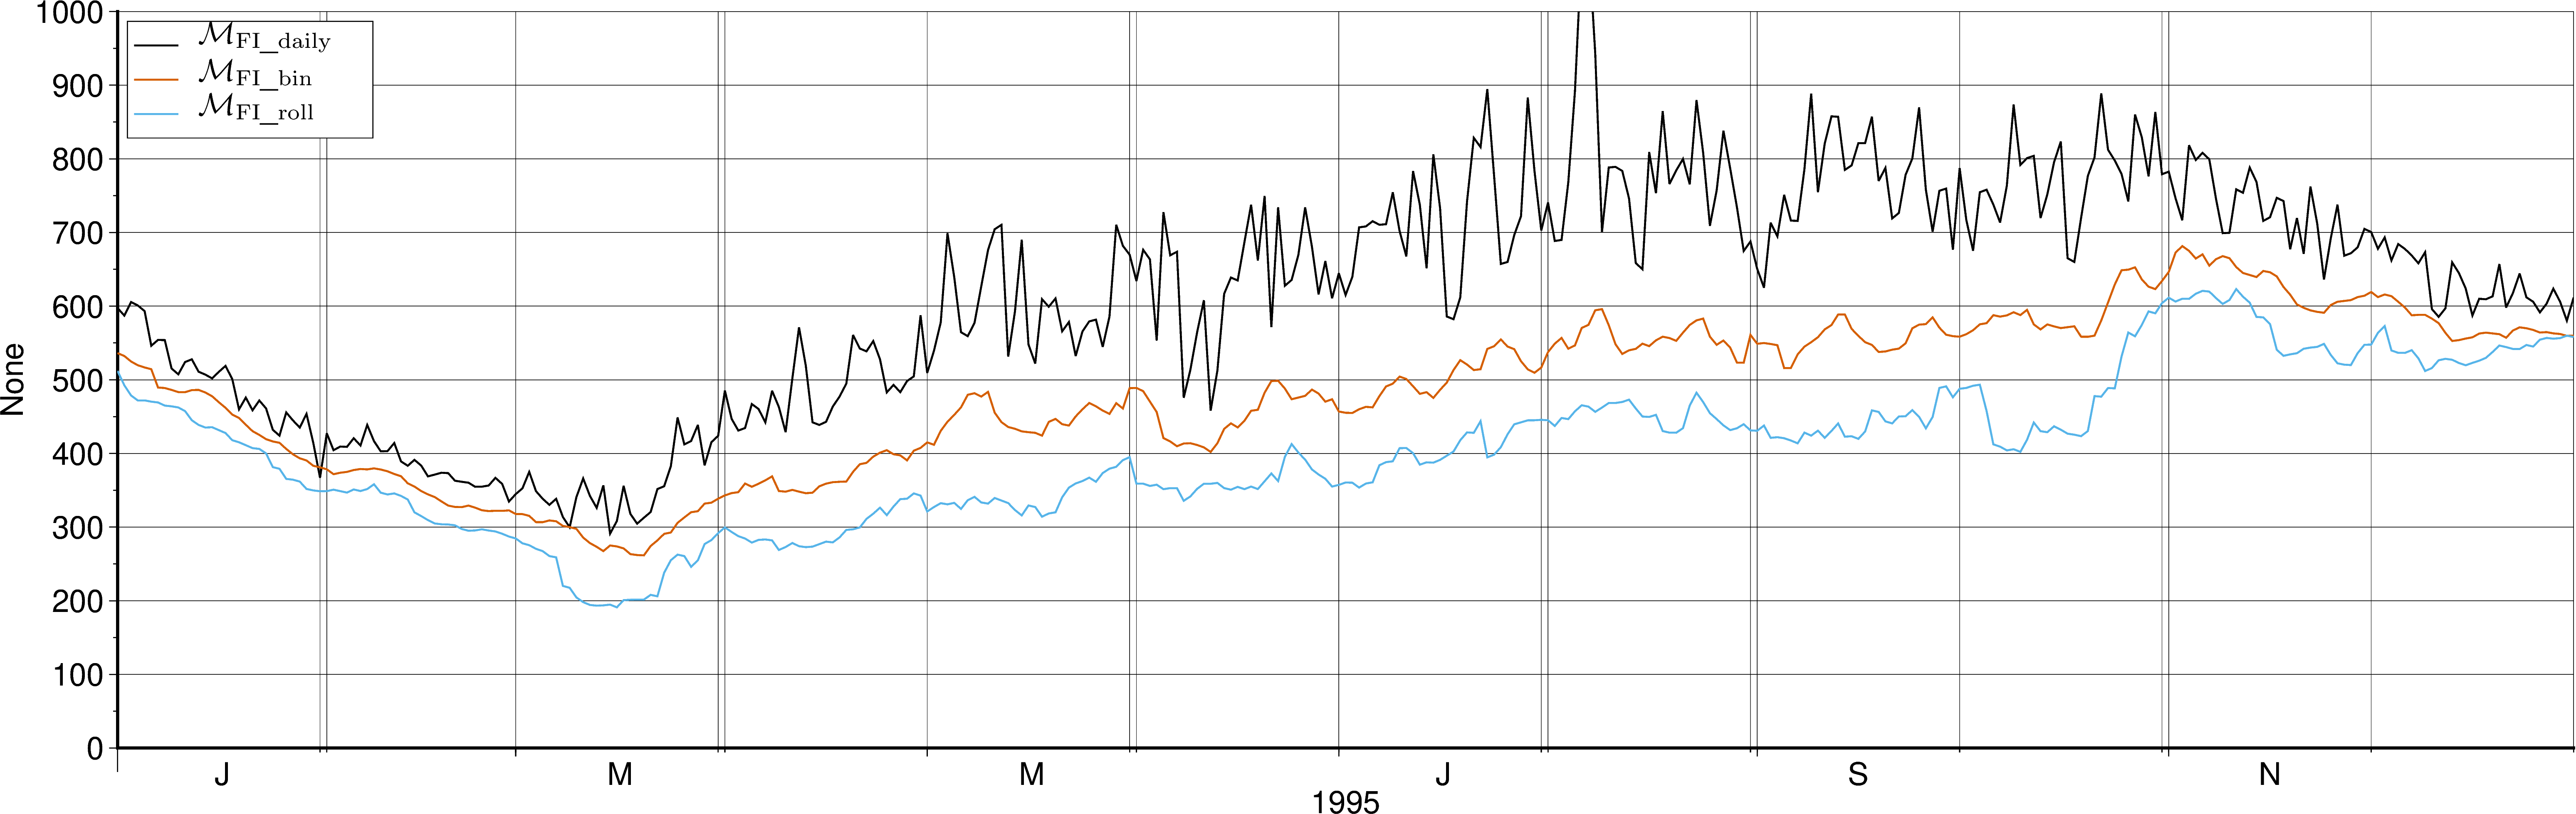

In [ ]:
fig = SI_tools.pygmt_timeseries(ts_dict   = FIA_dict,
                                primary_key = "FIA",
                                legend_pos  = "JTL+jTL+o0.2c+w5c",
                                #P_png=Path(SI_tools.P_figs, f"FIA_timeseries_{SI_tools.sim_name}_1995.png"),
                                save_fig  = False,
                                show_fig  = True)

# Sensitivity Table

In [ ]:
ARCHIVE_DIR = Path.home() / "AFIM_archive"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", f"paper1_sandbox_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
# Metrics variable name mapping (left = what this script looks for, right = fallback names in your zarr)
VAR_CANDIDATES = {"bias":               ["bias", "fia_bias", "FIA_bias"],
                  "corr":               ["corr", "correlation", "pearson_r"],
                  "mae":                ["mae", "mean_abs_error"],
                  "rmse":               ["rmse", "root_mean_sq_error"],
                  "fipsi":              ["fipsi", "FIPSI", "persistence_stability_index"],
                  "fipmax":             ["fipmax", "FIP_max", "persistence_max_distance", "fip_max_km"],
                  "fia_max_area":       ["fia_max_area", "FIA_max_area", "fia_area_max", "fia_max_kkm2"],
                  "fia_min_area":       ["fia_min_area", "FIA_min_area", "fia_area_min", "fia_min_kkm2"],
                  "fia_max_onset_doy":  ["fia_max_onset_doy", "FIA_max_onset_doy", "onset_max_doy", "fia_onset_max"],
                  "fia_min_onset_doy":  ["fia_min_onset_doy", "FIA_min_onset_doy", "onset_min_doy", "fia_onset_min"],}
AREA_UNITS = "m2"  # one of {"kkm2", "km2", "m2"}
# Map archive folder names -> LaTeX \gls{} macros
GLOSS_MAP = {"elps-min":  r"\gls{elpsmin}",
             "elps-ext":  r"\gls{elpsext}",
             "elps-mid":  r"\gls{elpsmid}",
             "elps-max":  r"\gls{elpsmax}",
             "FI-heavy":  r"\gls{fiheavy}",
             "ry93":      r"\gls{ry}",
             "Pstar-max": r"\gls{pstarmax}",
             "Pstar-min": r"\gls{pstarmin}",
             "Cstar-max": r"\gls{cstarmax}",
             "Cstar-min": r"\gls{cstarmin}",
             "gi-max":    r"\gls{gimax}",
             "gi-mid":    r"\gls{gimid}",
             "gi-min":    r"\gls{gimin}",
             "gi-nil":    r"\gls{ginil}",
             "gi-nil-def":r"\gls{ginildef}",
             "notensnogi":r"\gls{nofi}",
             "ktens-max": r"\gls{ktensmax}",
             "ktens-min": r"\gls{ktensmin}",
             "ktens-nil": r"\gls{ktensnil}",
             "ktens-ext": r"\gls{ktensext}"}
# Preferred row order (match paper)
PREFERRED_ORDER = ["elps-min","elps-ext","elps-mid","elps-max","FI-heavy","ry93",
                   "Pstar-max","Pstar-min","Cstar-min","Cstar-max",
                   "gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi",
                   "ktens-max","ktens-min","ktens-nil","ktens-ext"]

def _get_scalar(ds: xr.Dataset, keys: list[str], default=np.nan):
    """Return a Python float from ds[key], trying keys in order; supports DataArray or 0-d variable."""
    for k in keys:
        if k in ds:
            v = ds[k]
            try:
                # xr.DataArray(…)-> .item(); if it has dims, reduce if size==1
                return float(v.item() if v.size == 1 else v.values.squeeze().item())
            except Exception:
                pass
    return float(default)
    
def _area_to_kkm2(val: float) -> float:
    if np.isnan(val):
        return np.nan
    if AREA_UNITS == "kkm2":  # already in 1e3 km^2
        return float(val)
    if AREA_UNITS == "km2":
        return float(val) / 1e3
    if AREA_UNITS == "m2":
        return float(val) / 1e9  # m^2 -> (1e3 km^2)
    return float(val)

import pandas as pd
import math

def _latex_escape(s: str) -> str:
    """Escape minimal LaTeX specials in text fields."""
    if s is None:
        return ""
    rep = {
        "\\": r"\textbackslash{}",
        "&": r"\&",
        "%": r"\%",
        "$": r"\$",
        "#": r"\#",
        "_": r"\_",
        "{": r"\{",
        "}": r"\}",
        "~": r"\textasciitilde{}",
        "^": r"\textasciicircum{}",
    }
    out = str(s)
    for k, v in rep.items():
        out = out.replace(k, v)
    return out

def format_table_latex(
    df: pd.DataFrame,
    max_width="\\linewidth",
    label="tab:FIA_skill_metrics_ext",
    caption=None
) -> str:
    """
    Build a LaTeX tabular string with a units row, using booktabs + adjustbox.
    Requires in preamble:
        \\usepackage{booktabs}
        \\usepackage{siunitx}
        \\usepackage{adjustbox}
    """
    # Column order & pretty headers
    cols    = [
        "Experiment", "bias", "corr", "mae", "rmse", "fipsi", "fipmax",
        "fia_max_area", "fia_min_area", "fia_max_onset_doy", "fia_min_onset_doy"
    ]
    units   = [
        "",
        "", "", "", "", "",  # bias, corr, mae, rmse, fipsi
        r"\si{\kilo\metre}", r"$1\times10^3\ \mathrm{km}^2$", r"$1\times10^3\ \mathrm{km}^2$",
        r"\text{onset (DOY)}", r"\text{onset (DOY)}"
    ]
    headers = [
        r"\textbf{Experiment}",
        r"\textbf{\gls{bias}}",
        r"\textbf{\gls{corr}}",
        r"\textbf{\gls{mae}}",
        r"\textbf{\gls{rmse}}",
        r"\textbf{\gls{fipsi}}",
        r"\textbf{\gls{fipmax}}",
        r"\textbf{\gls{fia}$_\mathrm{max}$}",
        r"\textbf{\gls{fia}$_\mathrm{min}$}",
        r"\textbf{\gls{fia}$_\mathrm{max}$}",
        r"\textbf{\gls{fia}$_\mathrm{min}$}",
    ]

    # Alignment: 1 'l' + 10 'r'
    align = "l" + "r"*10

    # Ensure required columns exist
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in df: {missing}")

    # Format numbers per your style
    def f1(x): return "" if (x is None or (isinstance(x,float) and math.isnan(x))) else f"{x:.1f}"
    def f3(x): return "" if (x is None or (isinstance(x,float) and math.isnan(x))) else f"{x:.3f}"

    df_fmt = df.copy()
    df_fmt["Experiment"]        = df_fmt["Experiment"].map(_latex_escape)
    df_fmt["bias"]              = df_fmt["bias"].map(f1)
    df_fmt["corr"]              = df_fmt["corr"].map(f3)
    df_fmt["mae"]               = df_fmt["mae"].map(f1)
    df_fmt["rmse"]              = df_fmt["rmse"].map(f1)
    df_fmt["fipsi"]             = df_fmt["fipsi"].map(f3)
    df_fmt["fipmax"]            = df_fmt["fipmax"].map(f1)
    df_fmt["fia_max_area"]      = df_fmt["fia_max_area"].map(f1)
    df_fmt["fia_min_area"]      = df_fmt["fia_min_area"].map(f1)
    df_fmt["fia_max_onset_doy"] = df_fmt["fia_max_onset_doy"].map(f1)
    df_fmt["fia_min_onset_doy"] = df_fmt["fia_min_onset_doy"].map(f1)

    # Build LaTeX lines
    header_line = " & ".join(headers) + r" \\"
    units_line  = " & ".join(units)   + r" \\"

    rows = []
    for _, row in df_fmt[cols].iterrows():
        rows.append(" & ".join(str(v) for v in row.values) + r" \\")
    body = "\n".join(rows)

    # Wrap with table environment if caption/label provided
    top = ""
    bottom = ""
    if caption or label:
        cap = f"\\caption{{{caption}}}\n" if caption else ""
        lab = f"\\label{{{label}}}\n"    if label   else ""
        top = "\\begin{table}[t]\n" + cap + lab
        bottom = "\\end{table}"

    # IMPORTANT: double braces for literal braces in an f-string
    latex = fr"""{top}\begin{{adjustbox}}{{max width={max_width}}}
\begin{{tabular}}{{{align}}}
\toprule
{header_line}
{units_line}
\midrule
{body}
\bottomrule
\end{{tabular}}
\end{{adjustbox}}
{bottom}"""SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools = SI_tool_mgr.get_toolbox(dt0_str="1994-01-01", dtN_str="1999-12-31", sim_name="elps-min")
FI_bin = SI_tools.load_classified_ice(ice_type="FI")
    return latex


In [ ]:
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools = SI_tool_mgr.get_toolbox(dt0_str="1994-01-01", dtN_str="1999-12-31", sim_name="elps-min")
FI_bin = SI_tools.load_classified_ice(ice_type="FI")

In [ ]:
# Discover simulation names (folders) and exclude non-runs
EXCLUDE   = {"AOM2-ERA5"}  # add "*.json", "*.csv" are excluded automatically below
sim_names = sorted([p.name for p in ARCHIVE_DIR.iterdir() if p.is_dir() and (p.name not in EXCLUDE) and not p.name.endswith(".zarr")])
# Instantiate the toolbox manager (creates a toolbox per sim inside the loop)
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
rows        = []
skipped     = []
for sim_name in sim_names:
    # Build toolbox for this sim & window
    SI_tools = SI_tool_mgr.get_toolbox(dt0_str=dt0_str, dtN_str=dtN_str, sim_name=sim_name)
    # Load the precomputed metrics Zarr (defaults are fine unless you need specific grid/type)
    ds_mets = SI_tools.load_computed_metrics(ice_type="FI_BT")
    # Extract scalars (robust to different var names)
    bias              = ds_mets["Bias"].values
    corr              = ds_mets["Corr"].values
    mae               = ds_mets["MAE"].values
    rmse              = ds_mets["RMSE"].values
    print(ds_mets)
    fipsi             = ds_mets["persistence_stability_index"].values
    fipmax            = ds_mets["persistence_max_distance"].values
    fia_max_area      = _area_to_kkm2(_get_scalar(ds_mets, VAR_CANDIDATES["fia_max_area"]))
    fia_min_area      = _area_to_kkm2(_get_scalar(ds_mets, VAR_CANDIDATES["fia_min_area"]))
    fia_max_onset_doy = _get_scalar(ds_mets, VAR_CANDIDATES["fia_max_onset_doy"])
    fia_min_onset_doy = _get_scalar(ds_mets, VAR_CANDIDATES["fia_min_onset_doy"])
    # Experiment label as \gls macro if we know it; else raw folder name
    exp_label = GLOSS_MAP.get(sim_name, sim_name)
    rows.append({"Experiment"        : exp_label,
                 "sim_name"          : sim_name,  # keep raw for ordering/sorting
                 "bias"              : bias,
                 "corr"              : corr,
                 "mae"               : mae,
                 "rmse"              : rmse,
                 "fipsi"             : fipsi,
                 "fipmax"            : fipmax,
                 "fia_max_area"      : fia_max_area,
                 "fia_min_area"      : fia_min_area,
                 "fia_max_onset_doy" : fia_max_onset_doy,
                 "fia_min_onset_doy" : fia_min_onset_doy})
df = pd.DataFrame(rows)

In [ ]:
# Order rows to match your manuscript, with any extras appended alphabetically
order     = [s for s in PREFERRED_ORDER if s in df["sim_name"].values]
extras    = sorted(set(df["sim_name"].values) - set(order))
order_idx = order + extras
df        = df.set_index("sim_name").loc[order_idx].reset_index(drop=True)
# Reorder visible columns (drop sim_name)
df = df[["Experiment","bias","corr","mae","rmse","fipsi","fipmax","fia_max_area","fia_min_area","fia_max_onset_doy","fia_min_onset_doy"]]
# Show a quick preview
print(df)
latex_tabular = format_table_latex(df, max_width="\\linewidth", label="tab:FIA_skill_metrics_ext")
print(latex_tabular)
# save to tex file
OUT_TEX = Path.home() / "paper1_FIA_skill_metrics_table.tex"
OUT_TEX.write_text(latex_tabular)
print(OUT_TEX)

         Experiment        bias        corr                 mae  \
0     \gls{elpsmin}    20.41795  0.84908307  58.751434326171875   
1     \gls{elpsext}   71.541756  0.91170526   72.16920471191406   
2     \gls{elpsmid}   -69.77587   0.8370845    83.4891586303711   
3     \gls{elpsmax}  -197.29224    0.859317    197.292236328125   
4     \gls{fiheavy}   157.95804  0.77834547  157.95803833007812   
5          \gls{ry}   -239.8893   0.7060457  239.88929748535156   
6    \gls{pstarmax}   -95.17591  0.91759825   95.17591094970703   
7    \gls{pstarmin}  -229.19682   0.6248642   229.1968231201172   
8    \gls{cstarmin}   -82.38554  0.72937036   101.2900161743164   
9    \gls{cstarmax}   -175.8562  0.89001894    175.856201171875   
10      \gls{gimax}  -10.001062   0.8619092    67.2250747680664   
11      \gls{gimid}  -141.57361  0.86537826   141.5736083984375   
12      \gls{gimin}  -227.79462   0.7775309  227.79461669921875   
13      \gls{ginil}  -231.75964   0.6560695   231.759643554687